## TFM: ANÁLISIS Y PREDICCIÓN DE LA CALIDAD DEL AIRE EN LA COMUNIDAD DE MADRID

Alumno: Daniel de Miguel Bel


### Datos de la calidad del aire en los municipios y la ciudad de Madrid

Los dataset se han obtenido de la web de datos abiertos de la Comunidad de Madrid, en el siguiente enlace: 
https://datos.comunidad.madrid/dataset/calidad_aire_datos_historico

https://datos.comunidad.madrid/dataset/calidad_aire_datos_meteo_historico

Objetivo:  
- Análisis en profundidad de los datos relacionados con la calidad del aire.
- Encontrar patrones importantes entre la calidad del aire y otros procesos climatológicos y ambientales.
- Modelos de predicción para preveer el indice de la calidad del aire a futuro.

Preparación del entorno

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from scipy.stats import skew
import glob
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Lectura y unión de los datasets (Transformación a diario para crear 'df_ica')

In [3]:
df_aire = pd.read_csv('calidad_aire_cleaned.csv', sep=',', decimal='.')
df_meteo = pd.read_csv('meteo_cleaned.csv', sep=',', decimal='.')

In [4]:
df_aire["fecha"] = pd.to_datetime(df_aire["fecha"])

df_aire = df_aire[df_aire["fecha"].dt.year >= 2020]

In [5]:
df_aire.head()

Unnamed: 0         municipio magnitud  h01   h02   h03   h04   h05  \
278528      278563  ORUSCO DE TAJUÑA      SO2  1.0   1.0   1.0   1.0   1.0   
278529      278564  ORUSCO DE TAJUÑA       CO  0.3   0.3   0.3   0.3   0.3   
278530      278565  ORUSCO DE TAJUÑA       NO  1.0   1.0   1.0   1.0   1.0   
278531      278566  ORUSCO DE TAJUÑA      NO2  8.0   8.0   7.0   6.0   6.0   
278532      278567  ORUSCO DE TAJUÑA     PM10  8.0  15.0  13.0  11.0  12.0   

         h06   h07  ...  h16   h17   h18   h19   h20   h21   h22   h23   h24  \
278528   1.0   1.0  ...  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
278529   0.3   0.3  ...  0.3   0.3   0.4   0.4   0.4   0.4   0.4   0.4   0.4   
278530   1.0   1.0  ...  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
278531   6.0   7.0  ...  5.0   6.0   7.0   8.0   8.0   8.0   9.0  10.0   8.0   
278532  16.0  17.0  ...  7.0  14.0  22.0  22.0  16.0  16.0  17.0  17.0  17.0   

            fecha  
278528 2020-01-01  
278529 2020-01-01  
278530 2020-01-01  
278531 2020-01-01  
278532 2020-01-01  

[5 rows x 28 columns]

Pivotamos la columna de horas, pero para obtener una sola columna con el valor de ICA diario del contaminante

In [ ]:
horas_aire = [f"h{str(i).zfill(2)}" for i in range(1, 25)]
df_aire["valor_diario"] = df_aire[horas_aire].max(axis=1)

df_aire_diario = df_aire.pivot_table(
    index=["fecha", "municipio"],
    columns="magnitud",
    values="valor_diario"
).reset_index()

In [7]:
df_meteo.head()

municipio                      medida    h01    h02    h03    h04  \
0  ORUSCO DE TAJUÑA  Velocidad del viento (m/s)    1.1    1.0    1.1    1.0   
1  ORUSCO DE TAJUÑA            Temperatura (ºC)    2.7    2.6    2.1    1.9   
2  ORUSCO DE TAJUÑA        Humedad relativa (%)   86.0   87.0   89.0   91.0   
3  ORUSCO DE TAJUÑA  Presión atmosférica (mbar)  946.0  946.0  945.0  945.0   
4  ORUSCO DE TAJUÑA      Radiación solar (W/m²)   12.0   12.0   12.0   12.0   

     h05    h06    h07    h08  ...    h16    h17    h18    h19    h20    h21  \
0    1.2    1.2    1.5    1.6  ...    0.8    0.8    1.3    0.7    0.2    0.3   
1    1.6    1.6    0.0    0.1  ...   13.9   11.9    8.6    7.5    7.3    6.3   
2   92.0   92.0   96.0   96.0  ...   43.0   53.0   63.0   68.0   68.0   74.0   
3  944.0  945.0  946.0  947.0  ...  943.0  944.0  944.0  944.0  944.0  945.0   
4   12.0   12.0   12.0   22.0  ...  260.0  103.0   14.0   13.0   13.0   13.0   

     h22    h23    h24       fecha  
0    0.9    0.7    0.4  2020-01-01  
1    5.3    4.3    4.2  2020-01-01  
2   81.0   86.0   85.0  2020-01-01  
3  945.0  945.0  944.0  2020-01-01  
4   13.0   13.0   13.0  2020-01-01  

[5 rows x 27 columns]

In [8]:
horas = [f"h{str(i).zfill(2)}" for i in range(1, 25)]

df_meteo["media_diaria"] = df_meteo[horas].mean(axis=1)

df_meteo_diario = df_meteo.pivot_table(
    index=["fecha", "municipio"],
    columns="medida",
    values="media_diaria"
).reset_index()

df_meteo_diario.columns.name = None
df_meteo_diario.columns = [
    col.replace(" ", "_").replace("(", "").replace(")", "").replace("º", "o").replace("/", "_")
    for col in df_meteo_diario.columns
]

df_meteo_diario

fecha                   municipio  Humedad_relativa_%  \
0      2020-01-01           ALCALÁ DE HENARES           77.208333   
1      2020-01-01                  ALCOBENDAS           77.041667   
2      2020-01-01                    ALCORCÓN           78.083333   
3      2020-01-01                      ALGETE           73.583333   
4      2020-01-01                    ARANJUEZ           80.083333   
...           ...                         ...                 ...   
47904  2025-02-28  SAN SEBASTIÁN DE LOS REYES           73.166667   
47905  2025-02-28           TORREJÓN DE ARDOZ           66.416667   
47906  2025-02-28                   VALDEMORO           70.125000   
47907  2025-02-28             VILLA DEL PRADO           63.750000   
47908  2025-02-28       VILLAREJO DE SALVANÉS           60.958333   

       Precipitación  Presión_atmosférica_mbar  Radiación_solar_W_m²  \
0           0.008333                964.333333            100.500000   
1           0.008333                954.250000            102.083333   
2           0.000000                952.083333            115.583333   
3           0.000000                948.208333             97.541667   
4           0.012500                977.000000             67.500000   
...              ...                       ...                   ...   
47904       0.020833                937.041667            149.208333   
47905       0.000000                949.333333            133.791667   
47906       0.000000                943.458333            149.708333   
47907       0.000000                960.291667            179.750000   
47908       0.000000                929.250000            165.333333   

       Temperatura_oC  Velocidad_del_viento_m_s  
0            4.429167                  0.595833  
1            5.158333                  0.316667  
2            8.262500                  0.950000  
3            6.095833                  0.775000  
4            2.887500                  0.116667  
...               ...                       ...  
47904        7.566667                  0.679167  
47905       10.916667                  2.137500  
47906       10.495833                  2.020833  
47907       10.745833                  1.987500  
47908       10.570833                  1.904167  

[47909 rows x 8 columns]

In [9]:
df_meteo_diario["fecha"] = pd.to_datetime(df_meteo_diario["fecha"])
columnas_a_agregar = df_meteo_diario.columns.difference(["fecha", "municipio"])
df_ica = pd.merge(
    df_aire,
    df_meteo_diario[["fecha", "municipio"] + list(columnas_a_agregar)],
    on=["fecha", "municipio"],
    how="left"
)

Pivotamos también los contaminantes para que aparezcan como variables y que de cada uno aparezca su valor máximo diario, ya que es la manera de calcular el ICA en España y Europa

In [10]:
contaminantes_interes = [
    'SO2', 'NO2', 'PM10', 'NOx', 'O3', 'Tolueno', 'Benceno',
    'Hidrocarburos totales', 'NO', 'Hidrocarburos no metánicos',
    'M/P-xileno', 'PM2.5', 'CO'
]

horas = [f"h{str(i).zfill(2)}" for i in range(1, 25)]
df_ica["valor_diario"] = df_ica[horas].max(axis=1)

df_contaminantes = df_ica[df_ica["magnitud"].isin(contaminantes_interes)]

df_contaminantes_pivot = df_contaminantes.pivot_table(
    index=["fecha", "municipio"],
    columns="magnitud",
    values="valor_diario"
).reset_index()

df_ica_base = (
    df_ica.drop(columns=horas + ["magnitud", "valor_diario"])
          .drop_duplicates()
          .groupby(["fecha", "municipio"], as_index=False)
          .first()
)

df_ica = pd.merge(
    df_ica_base,
    df_contaminantes_pivot,
    on=["fecha", "municipio"],
    how="left"
)

In [11]:
df_ica

fecha                   municipio  Unnamed: 0  Humedad_relativa_%  \
0     2020-01-01           ALCALÁ DE HENARES      278656           77.208333   
1     2020-01-01                  ALCOBENDAS      278674           77.041667   
2     2020-01-01                    ALCORCÓN      278695           78.083333   
3     2020-01-01                      ALGETE      278711           73.583333   
4     2020-01-01                    ARANJUEZ      278581           80.083333   
...          ...                         ...         ...                 ...   
47994 2025-02-28  SAN SEBASTIÁN DE LOS REYES      593680           73.166667   
47995 2025-02-28           TORREJÓN DE ARDOZ      593690           66.416667   
47996 2025-02-28                   VALDEMORO      593709           70.125000   
47997 2025-02-28             VILLA DEL PRADO      593714           63.750000   
47998 2025-02-28       VILLAREJO DE SALVANÉS      593722           60.958333   

       Precipitación  Presión_atmosférica_mbar  Radiación_solar_W_m²  \
0           0.008333                964.333333            100.500000   
1           0.008333                954.250000            102.083333   
2           0.000000                952.083333            115.583333   
3           0.000000                948.208333             97.541667   
4           0.012500                977.000000             67.500000   
...              ...                       ...                   ...   
47994       0.020833                937.041667            149.208333   
47995       0.000000                949.333333            133.791667   
47996       0.000000                943.458333            149.708333   
47997       0.000000                960.291667            179.750000   
47998       0.000000                929.250000            165.333333   

       Temperatura_oC  Velocidad_del_viento_m_s  Benceno  ...  \
0            4.429167                  0.595833      NaN  ...   
1            5.158333                  0.316667      2.6  ...   
2            8.262500                  0.950000      NaN  ...   
3            6.095833                  0.775000      NaN  ...   
4            2.887500                  0.116667      NaN  ...   
...               ...                       ...      ...  ...   
47994        7.566667                  0.679167      NaN  ...   
47995       10.916667                  2.137500      NaN  ...   
47996       10.495833                  2.020833      NaN  ...   
47997       10.745833                  1.987500      NaN  ...   
47998       10.570833                  1.904167      NaN  ...   

       Hidrocarburos totales  M/P-xileno     NO   NO2    NOx     O3  PM10  \
0                        NaN         NaN  269.0  86.0  498.0   36.0  74.0   
1                        2.3         8.7  158.0  86.0  329.0   30.0  85.0   
2                        NaN         NaN  137.0  90.0  297.0   24.0   NaN   
3                        NaN         NaN   31.0  26.0   73.0   39.0   NaN   
4                        NaN         NaN   87.0  51.0  183.0   26.0  58.0   
...                      ...         ...    ...   ...    ...    ...   ...   
47994                    NaN         NaN    9.0  32.0   46.0   93.0  18.0   
47995                    NaN         NaN   26.0  43.0   83.0   92.0  28.0   
47996                    NaN         NaN   13.0  59.0   64.0   92.0   NaN   
47997                    NaN         NaN    4.0  15.0   19.0   80.0  18.0   
47998                    NaN         NaN    7.0  24.0   32.0  101.0   NaN   

       PM2.5  SO2  Tolueno  
0       50.0  5.0      NaN  
1        NaN  NaN     16.7  
2      264.0  NaN      NaN  
3       45.0  NaN      NaN  
4        NaN  NaN      NaN  
...      ...  ...      ...  
47994    NaN  NaN      NaN  
47995   16.0  NaN      NaN  
47996   32.0  NaN      NaN  
47997   11.0  4.0      NaN  
47998   11.0  NaN      NaN  

[47999 rows x 22 columns]

Cambiamos los datos erróneos del viento de Parla

In [12]:
df_ica[
    (df_ica['municipio'] == 'PARLA') & 
    (df_ica['Velocidad_del_viento_m_s'] > 50)
]

fecha municipio  Unnamed: 0  Humedad_relativa_%  Precipitación  \
28587 2023-04-04     PARLA      468870           19.916667            0.0   
28614 2023-04-05     PARLA      469045           14.458333            0.0   
28641 2023-04-06     PARLA      469220           19.666667            0.0   
28668 2023-04-07     PARLA      469395           22.041667            0.0   
28695 2023-04-08     PARLA      469570           22.916667            0.0   
28722 2023-04-09     PARLA      469745           29.208333            0.0   
28749 2023-04-10     PARLA      469920           27.750000            0.0   
28776 2023-04-11     PARLA      470095           33.125000            0.0   
28803 2023-04-12     PARLA      470270           52.416667            0.0   

       Presión_atmosférica_mbar  Radiación_solar_W_m²  Temperatura_oC  \
28587                       NaN            266.666667       13.200000   
28614                       NaN            264.208333       13.187500   
28641                       NaN            262.291667       15.187500   
28668                       NaN            263.833333       15.650000   
28695                       NaN            264.208333       17.604167   
28722                       NaN            243.875000       18.208333   
28749                       NaN            237.166667       19.229167   
28776                       NaN            266.416667       18.358333   
28803                       NaN            198.375000       13.816667   

       Velocidad_del_viento_m_s  Benceno  ...  Hidrocarburos totales  \
28587                938.191667      NaN  ...                    NaN   
28614                941.287500      NaN  ...                    NaN   
28641                940.862500      NaN  ...                    NaN   
28668                940.016667      NaN  ...                    NaN   
28695                940.370833      NaN  ...                    NaN   
28722                943.575000      NaN  ...                    NaN   
28749                945.608333      NaN  ...                    NaN   
28776                943.825000      NaN  ...                    NaN   
28803                939.112500      NaN  ...                    NaN   

       M/P-xileno  NO  NO2  NOx  O3  PM10  PM2.5  SO2  Tolueno  
28587         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28614         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28641         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28668         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28695         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28722         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28749         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28776         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  
28803         NaN NaN  NaN  NaN NaN   NaN    NaN  NaN      NaN  

[9 rows x 22 columns]

In [13]:
indices_a_eliminar = [28587, 28614, 28641, 28668, 28695, 28722, 28749, 28776, 28803]

df_ica = df_ica.drop(index=indices_a_eliminar)

#### Limpieza, calidad y comprobación del dataframe

In [14]:
df_ica.shape

(47990, 22)

In [15]:
df_ica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47990 entries, 0 to 47998
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   fecha                       47990 non-null  datetime64[ns]
 1   municipio                   47990 non-null  object        
 2   Unnamed: 0                  47990 non-null  int64         
 3   Humedad_relativa_%          47895 non-null  float64       
 4   Precipitación               47898 non-null  float64       
 5   Presión_atmosférica_mbar    47890 non-null  float64       
 6   Radiación_solar_W_m²        47886 non-null  float64       
 7   Temperatura_oC              47115 non-null  float64       
 8   Velocidad_del_viento_m_s    46454 non-null  float64       
 9   Benceno                     7518 non-null   float64       
 10  CO                          11288 non-null  float64       
 11  Hidrocarburos no metánicos  7429 non-null   float64       


In [16]:
df_ica.columns

Index(['fecha', 'municipio', 'Unnamed: 0', 'Humedad_relativa_%',
       'Precipitación', 'Presión_atmosférica_mbar', 'Radiación_solar_W_m²',
       'Temperatura_oC', 'Velocidad_del_viento_m_s', 'Benceno', 'CO',
       'Hidrocarburos no metánicos', 'Hidrocarburos totales', 'M/P-xileno',
       'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'SO2', 'Tolueno'],
      dtype='object')

Borro columnas innecesarias y renombramos el resto para que sean más fáciles, intuitivas y en formato PEP8

In [17]:
df_ica.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
df_ica.rename(columns={'magnitud': 'contaminante', 'Humedad_relativa_%': 'humedad_relativa', 'Precipitación': 'precipitacion',
       'Presión_atmosférica_mbar': 'presion_atmosferica', 'Radiación_solar_W_m²': 'radiación_solar',
       'Temperatura_oC': 'temperatura', 'Velocidad_del_viento_m_s': 'velocidad_viento'}, inplace=True)

In [19]:
cols = df_ica.columns.tolist()
cols.insert(0, cols.pop(cols.index("fecha")))
df_ica = df_ica[cols]

Transformaciones de formato

In [ ]:
cols_meteo = [
    'humedad_relativa',
    'precipitacion',
    'presion_atmosferica',
    'radiación_solar',
    'temperatura',
    'velocidad_viento'
]

otras_cols = [col for col in df_ica.columns if col not in cols_meteo]
df_ica = df_ica[otras_cols + cols_meteo]

In [21]:
df_ica[cols_meteo] = df_ica[cols_meteo].round(2)

In [22]:
df_ica.head()

fecha          municipio  Benceno   CO  Hidrocarburos no metánicos  \
0 2020-01-01  ALCALÁ DE HENARES      NaN  1.4                         NaN   
1 2020-01-01         ALCOBENDAS      2.6  NaN                         0.4   
2 2020-01-01           ALCORCÓN      NaN  NaN                         NaN   
3 2020-01-01             ALGETE      NaN  NaN                         NaN   
4 2020-01-01           ARANJUEZ      NaN  NaN                         NaN   

   Hidrocarburos totales  M/P-xileno     NO   NO2    NOx  ...  PM10  PM2.5  \
0                    NaN         NaN  269.0  86.0  498.0  ...  74.0   50.0   
1                    2.3         8.7  158.0  86.0  329.0  ...  85.0    NaN   
2                    NaN         NaN  137.0  90.0  297.0  ...   NaN  264.0   
3                    NaN         NaN   31.0  26.0   73.0  ...   NaN   45.0   
4                    NaN         NaN   87.0  51.0  183.0  ...  58.0    NaN   

   SO2  Tolueno  humedad_relativa  precipitacion  presion_atmosferica  \
0  5.0      NaN             77.21           0.01               964.33   
1  NaN     16.7             77.04           0.01               954.25   
2  NaN      NaN             78.08           0.00               952.08   
3  NaN      NaN             73.58           0.00               948.21   
4  NaN      NaN             80.08           0.01               977.00   

   radiación_solar  temperatura  velocidad_viento  
0           100.50         4.43              0.60  
1           102.08         5.16              0.32  
2           115.58         8.26              0.95  
3            97.54         6.10              0.78  
4            67.50         2.89              0.12  

[5 rows x 21 columns]

In [23]:
df_ica.dtypes

fecha                         datetime64[ns]
municipio                             object
Benceno                              float64
CO                                   float64
Hidrocarburos no metánicos           float64
Hidrocarburos totales                float64
M/P-xileno                           float64
NO                                   float64
NO2                                  float64
NOx                                  float64
O3                                   float64
PM10                                 float64
PM2.5                                float64
SO2                                  float64
Tolueno                              float64
humedad_relativa                     float64
precipitacion                        float64
presion_atmosferica                  float64
radiación_solar                      float64
temperatura                          float64
velocidad_viento                     float64
dtype: object

***Breve análisis de las variables y téminos estadísticos para aplicar al dataset***


Variables cuantitativas continuas (float): 

- 'SO2', 'NO2', 'PM10', 'NOx', 'O3', 'Tolueno', 'Benceno','Hidrocarburos totales', 'NO', 'Hidrocarburos no metánicos', 'M/P-xileno', 'PM2.5', 'CO':     
Valor máximo diario del contaminante correspondiente, en microgramos por metro cúbico (µg/m³)

- humedad_relativa: valor medio diario de la humedad relativa medido en porcentaje (%)

- precipitacion: cantidad media diaria de precipitaciones medido en litros por metro cuadrado (l/m2)

- presion_atmosferica: valor medio diario de la presión atmosférica medido en milibares (mbar)

- radiación_solar: cantidad media diaria de radiación solar en vatios por metro cuadrado (W/m2)

- temperatura: valor de la temperatura media diaria en grados centigrados (Cº)

- velocidad_viento: valor de la velocidad media diaria del viento en metros por segundo (m/s)


Variables cuantitativas discretas (integer):

- ICA: valor diario del ICA (indice de calidad del aire)


Variables cualitativas nominales (string):

- municipio: nombre del municipio de la Comunidad de Madrid para cada registro de contaminación.

- contaminante: nombre del contaminante medido en cada registro.

- fecha: dia, mes y año del registro de contaminación. Es numérico y tiene un orden, pero se considera objeto en un principio.

- categoria_ICA: categoría a la que pertenece el ICA diario (buena, moderada, desfavorable, peligrosa...)

#### DUPLICADOS

In [24]:
duplicados = df_ica.duplicated().any()

print("Duplicados:", duplicados)

df_ica.duplicated().sum()

Duplicados: False


np.int64(0)

#### NULOS

Vemos que no haya caracteres especiales que se pudieran considerar nulos en las variables tipo 'object'. Vemos nulos en el valor de contaminación diaria y en las medidas de meteorologia

In [25]:
for col in df_aire.select_dtypes(include=['object']).columns:
    print(col)
    print(df_aire[col].unique())

municipio
['ORUSCO DE TAJUÑA' 'PUERTO DE COTOS' 'RIVAS-VACIAMADRID' 'ARANJUEZ'
 'SAN MARTÍN DE VALDEIGLESIAS' 'ARGANDA DEL REY' 'TORREJÓN DE ARDOZ'
 'ATAZAR, EL' 'VALDEMORO' 'VILLA DEL PRADO' 'VILLAREJO DE SALVANÉS'
 'COLMENAR VIEJO' 'COLLADO VILLALBA' 'COSLADA' 'ALCALÁ DE HENARES'
 'FUENLABRADA' 'ALCOBENDAS' 'GETAFE' 'GUADALIX DE LA SIERRA' 'ALCORCÓN'
 'LEGANÉS' 'MAJADAHONDA' 'ALGETE' 'MÓSTOLES' 'SAN SEBASTIÁN DE LOS REYES'
 'POZUELO DE ALARCÓN' 'PARLA' 'ROZAS, LAS']
magnitud
['SO2' 'CO' 'NO' 'NO2' 'PM10' 'NOx' 'O3' 'PM2.5' 'Tolueno' 'Benceno'
 'Hidrocarburos totales' 'Hidrocarburos no metánicos' 'M/P-xileno']


In [26]:
df_ica.shape

(47990, 21)

In [27]:
df_ica.isnull().sum()

fecha                             0
municipio                         0
Benceno                       40472
CO                            36702
Hidrocarburos no metánicos    40561
Hidrocarburos totales         40565
M/P-xileno                    40473
NO                              506
NO2                             508
NOx                             523
O3                              891
PM10                          11143
PM2.5                         22408
SO2                           36692
Tolueno                       40473
humedad_relativa                 95
precipitacion                    92
presion_atmosferica             100
radiación_solar                 104
temperatura                     875
velocidad_viento               1536
dtype: int64

Benceno, Tolueno, Hidrocarburos totales, Hidrocarburos no metánicos, M/P-xileno tienen más de 40,000 nulos cada uno y revisando los datos se debe a que solo están disponibles estas medidas en unas pocas estaciones. Por ello, procedo a eliminarlos, ya que además al analizar sus concentraciones vemos que son bajas en todos

In [28]:
columnas_a_eliminar = [
    'Benceno', 'Tolueno', 'Hidrocarburos totales',
    'Hidrocarburos no metánicos', 'M/P-xileno'
]

df_ica = df_ica.drop(columns=[col for col in columnas_a_eliminar if col in df_ica.columns])

Al haber esos nulos voy a aplicar una interpolación por fechas para rellenar estos valores nulos

In [29]:
df_ica_temp = df_ica.set_index("fecha")
df_ica_temp = df_ica_temp.interpolate(method="time", limit_direction="both")
df_ica_temp.reset_index(inplace=True)

df_ica = df_ica_temp

In [30]:
df_ica.isnull().any().sum()

np.int64(0)

#### OUTLIERS:
Observamos que no hay valores muy exagerados como outlier. Hay algunos en los contaminantes y en fenómenos meteorológicos es bastante más estable y con menos outliers

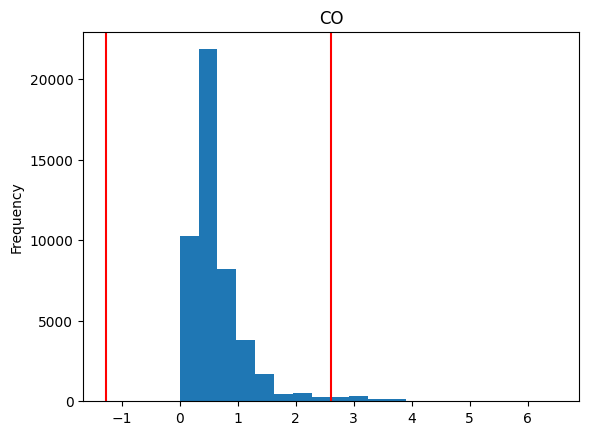

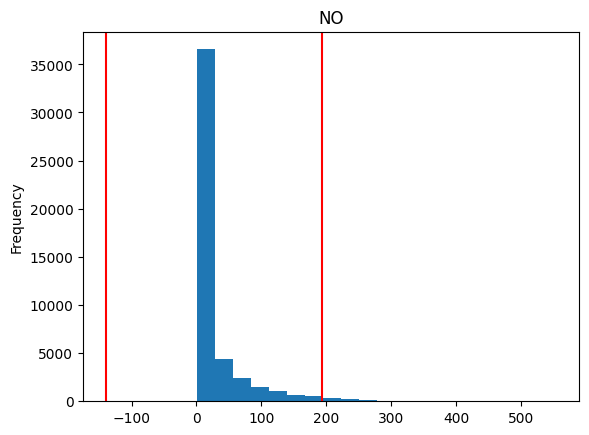

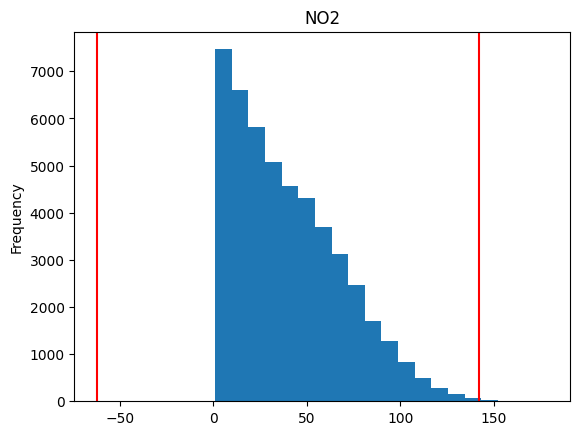

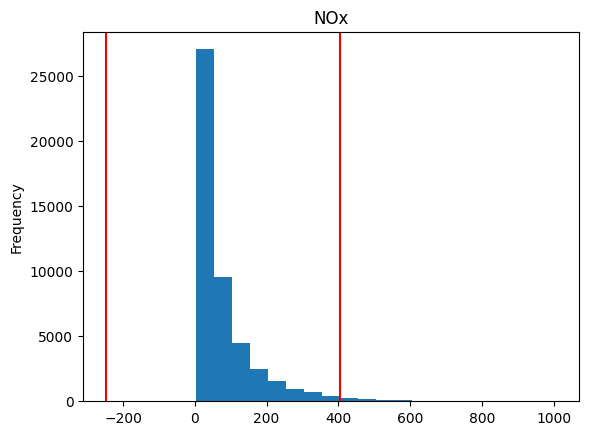

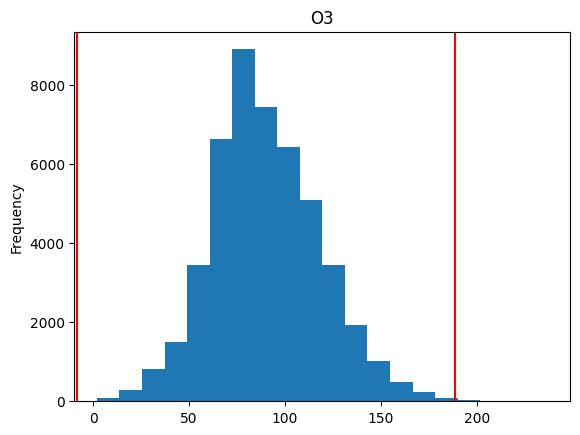

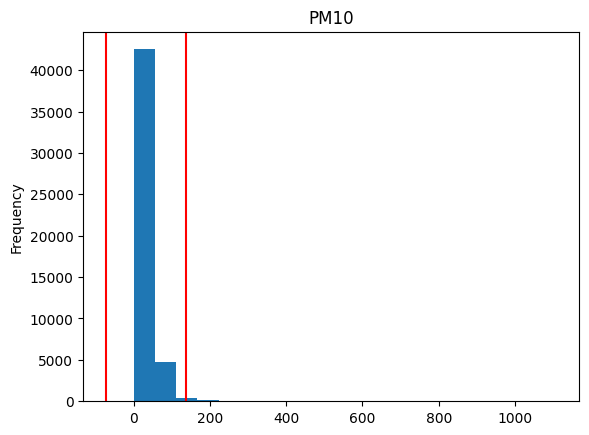

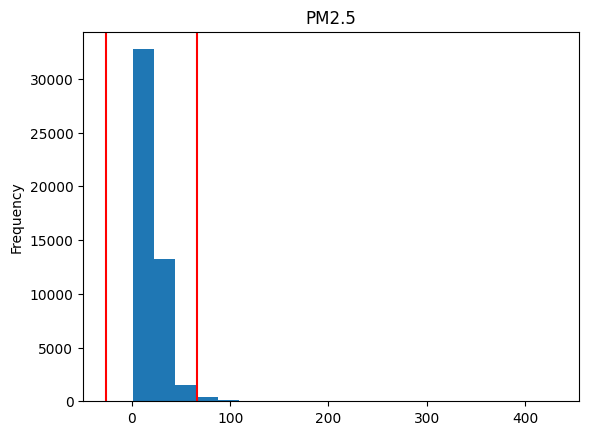

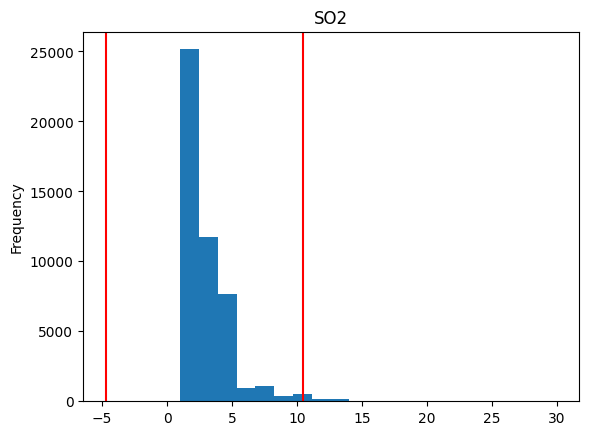

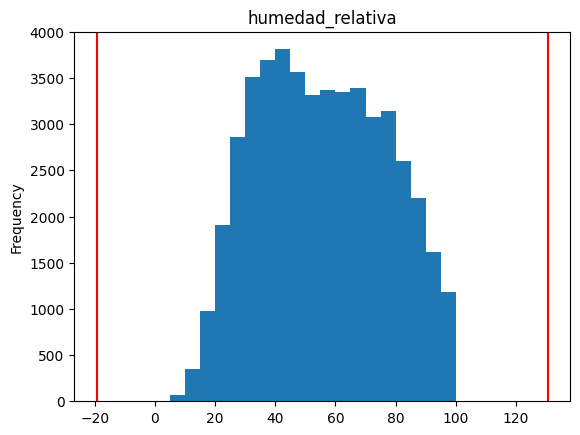

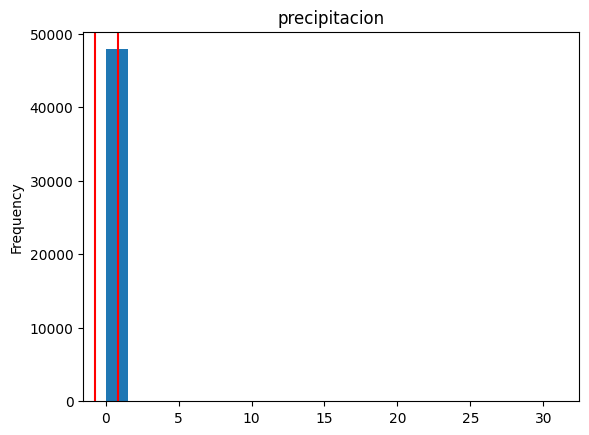

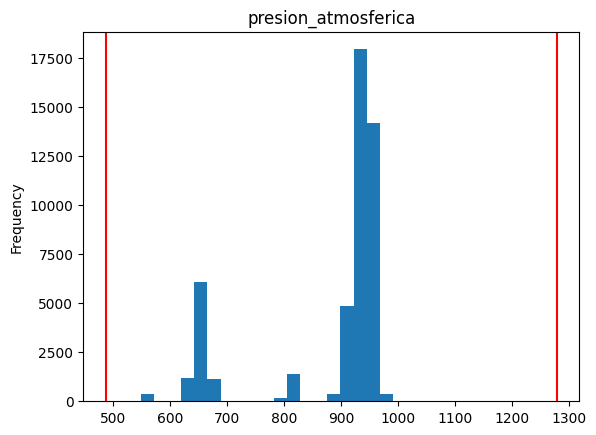

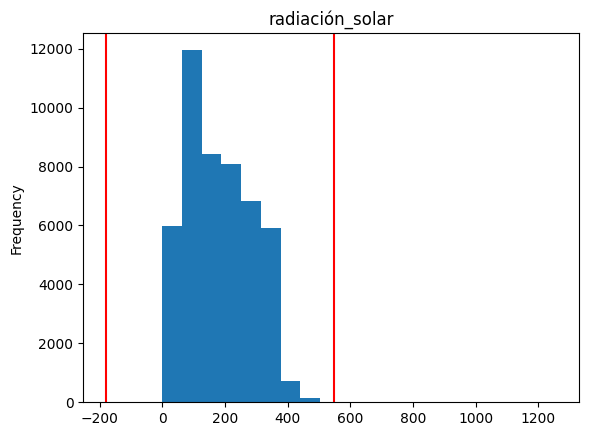

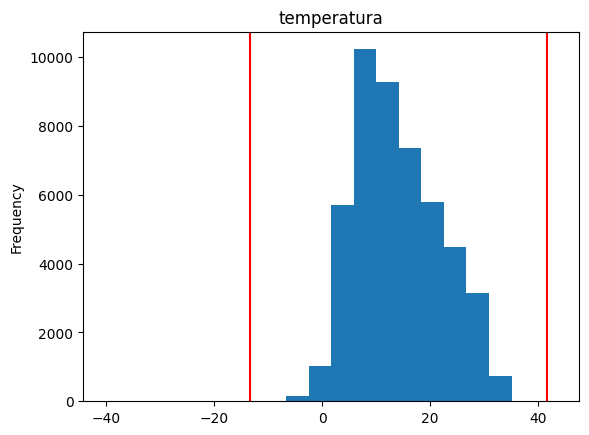

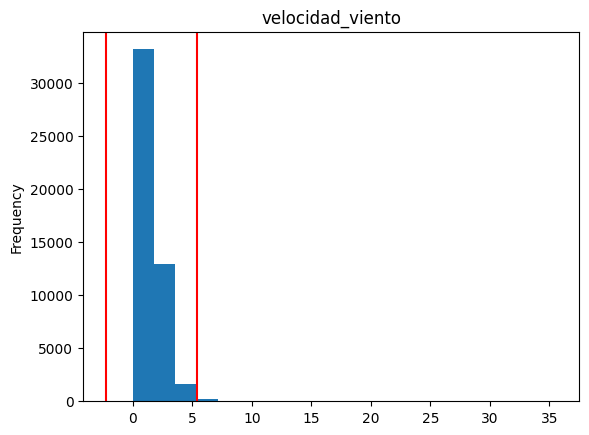

In [31]:
for col in df_ica.select_dtypes(include=["int",'float']).columns:
    media = df_ica[col].mean()
    desviacion_estandar = df_ica[col].std()
    
    umbral_superior = media + 3.5 * desviacion_estandar
    umbral_inferior = media - 3.5 * desviacion_estandar

    df_ica[col].plot(kind='hist', bins=20)
    plt.axvline(umbral_inferior,color='red')
    plt.axvline(umbral_superior,color='red')
    plt.title(col)
    plt.show()
    plt.close()

____

#### CALCULO DEL ICA (Indice de calidad del aire)

Para ello hay que aplicar la fórmula correspondiente para cada contaminante, ya que algunos contaminantes con concentraciones menores a otros se consideran que contaminan en mayor medida. Para calcular correctamente el ICA para esos contaminantes, usaremos los contaminantes regulados para el cálculo oficial del ICA (como en España o Europa). Vamos a aplicar las formulas, mapeando y conseguir el ICA máximo diario (quedándonos con un solo valor)

In [32]:
df_ica

fecha                   municipio   CO     NO   NO2    NOx     O3  \
0     2020-01-01           ALCALÁ DE HENARES  1.4  269.0  86.0  498.0   36.0   
1     2020-01-01                  ALCOBENDAS  1.3  158.0  86.0  329.0   30.0   
2     2020-01-01                    ALCORCÓN  1.3  137.0  90.0  297.0   24.0   
3     2020-01-01                      ALGETE  1.3   31.0  26.0   73.0   39.0   
4     2020-01-01                    ARANJUEZ  1.3   87.0  51.0  183.0   26.0   
...          ...                         ...  ...    ...   ...    ...    ...   
47985 2025-02-28  SAN SEBASTIÁN DE LOS REYES  0.3    9.0  32.0   46.0   93.0   
47986 2025-02-28           TORREJÓN DE ARDOZ  0.3   26.0  43.0   83.0   92.0   
47987 2025-02-28                   VALDEMORO  0.3   13.0  59.0   64.0   92.0   
47988 2025-02-28             VILLA DEL PRADO  0.3    4.0  15.0   19.0   80.0   
47989 2025-02-28       VILLAREJO DE SALVANÉS  0.3    7.0  24.0   32.0  101.0   

       PM10  PM2.5  SO2  humedad_relativa  precipitacion  presion_atmosferica  \
0      74.0   50.0  5.0             77.21           0.01               964.33   
1      85.0  151.0  1.0             77.04           0.01               954.25   
2      89.0  264.0  1.0             78.08           0.00               952.08   
3      89.0   45.0  1.0             73.58           0.00               948.21   
4      58.0  151.0  1.0             80.08           0.01               977.00   
...     ...    ...  ...               ...            ...                  ...   
47985  18.0   11.0  2.0             73.17           0.02               937.04   
47986  28.0   16.0  2.0             66.42           0.00               949.33   
47987  28.0   32.0  2.0             70.12           0.00               943.46   
47988  18.0   11.0  4.0             63.75           0.00               960.29   
47989  28.0   11.0  2.0             60.96           0.00               929.25   

       radiación_solar  temperatura  velocidad_viento  
0               100.50         4.43              0.60  
1               102.08         5.16              0.32  
2               115.58         8.26              0.95  
3                97.54         6.10              0.78  
4                67.50         2.89              0.12  
...                ...          ...               ...  
47985           149.21         7.57              0.68  
47986           133.79        10.92              2.14  
47987           149.71        10.50              2.02  
47988           179.75        10.75              1.99  
47989           165.33        10.57              1.90  

[47990 rows x 16 columns]

En un principio pensé en hacerlo en ranges de 25 en 25, como se suele hacer en muchos portales de calidad del aire, pero de cara a la predicción creo mejor hacerlo con valores numéricos continuos, ya que de la otra forma, para valores altos, algún valor más cercano a 200 se clasificaba como 300

In [33]:
# def ica_pm10(c):
#     if c <= 20: return 25
#     elif c <= 40: return 50
#     elif c <= 50: return 75
#     elif c <= 100: return 100
#     elif c <= 150: return 150
#     elif c <= 200: return 200
#     else: return 300

# def ica_pm25(c):
#     if c <= 10: return 25
#     elif c <= 20: return 50
#     elif c <= 25: return 75
#     elif c <= 50: return 100
#     elif c <= 75: return 150
#     elif c <= 100: return 200
#     else: return 300

# def ica_no2(c):
#     if c <= 50: return 25
#     elif c <= 100: return 50
#     elif c <= 200: return 75
#     elif c <= 400: return 100
#     elif c <= 800: return 150
#     elif c <= 1000: return 200
#     else: return 300

# def ica_so2(c):
#     if c <= 100: return 25
#     elif c <= 200: return 50
#     elif c <= 350: return 75
#     elif c <= 500: return 100
#     elif c <= 750: return 150
#     elif c <= 1000: return 200
#     else: return 300

# def ica_o3(c):
#     if c <= 60: return 25
#     elif c <= 120: return 50
#     elif c <= 180: return 75
#     elif c <= 240: return 100
#     elif c <= 360: return 150
#     elif c <= 500: return 200
#     else: return 300

# def ica_co(c):
#     if c <= 1: return 25
#     elif c <= 2: return 50
#     elif c <= 10: return 75
#     elif c <= 17: return 100
#     elif c <= 34: return 150
#     elif c <= 50: return 200
#     else: return 300


In [34]:
# def calcular_ica_fila(fila):
#     valores = []

#     if not pd.isna(fila.get("PM10")):
#         valores.append(ica_pm10(fila["PM10"]))
#     if not pd.isna(fila.get("PM2.5")):
#         valores.append(ica_pm25(fila["PM2.5"]))
#     if not pd.isna(fila.get("NO2")):
#         valores.append(ica_no2(fila["NO2"]))
#     if not pd.isna(fila.get("SO2")):
#         valores.append(ica_so2(fila["SO2"]))
#     if not pd.isna(fila.get("O3")):
#         valores.append(ica_o3(fila["O3"]))
#     if not pd.isna(fila.get("CO")):
#         valores.append(ica_co(fila["CO"]))

#     return max(valores) if valores else np.nan

In [35]:
# df_ica["ICA"] = df_ica.apply(calcular_ica_fila, axis=1)

In [36]:
def ica_continuo(valor, tramos):
    for c_low, c_high, i_low, i_high in tramos:
        if c_low <= valor <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (valor - c_low) + i_low
    return np.nan

# Tramos por contaminante (solo ejemplos, revisables)
tramos_pm10 = [(0, 20, 0, 25), (21, 40, 26, 50), (41, 50, 51, 75),
               (51, 100, 76, 100), (101, 150, 101, 150), (151, 200, 151, 200), (201, 1000, 201, 300)]
tramos_pm25 = [(0, 10, 0, 25), (11, 20, 26, 50), (21, 25, 51, 75), (26, 50, 76, 100),
               (51, 75, 101, 150), (76, 100, 151, 200), (101, 1000, 201, 300)]
tramos_no2 = [(0, 50, 0, 25), (51, 100, 26, 50), (101, 200, 51, 75), (201, 400, 76, 100),
              (401, 800, 101, 150), (801, 1000, 151, 200), (1001, 10000, 201, 300)]
tramos_so2 = [(0, 100, 0, 25), (101, 200, 26, 50), (201, 350, 51, 75), (351, 500, 76, 100),
              (501, 750, 101, 150), (751, 1000, 151, 200), (1001, 10000, 201, 300)]
tramos_o3 = [(0, 60, 0, 25), (61, 120, 26, 50), (121, 180, 51, 75), (181, 240, 76, 100),
             (241, 360, 101, 150), (361, 500, 151, 200), (501, 1000, 201, 300)]
tramos_co = [(0, 1, 0, 25), (1.1, 2, 26, 50), (2.1, 10, 51, 75), (10.1, 17, 76, 100),
             (17.1, 34, 101, 150), (34.1, 50, 151, 200), (50.1, 1000, 201, 300)]
tramos_no = [(0, 50, 0, 25), (51, 100, 26, 50), (101, 200, 51, 75), (201, 400, 76, 100),
             (401, 600, 101, 150), (601, 800, 151, 200), (801, 10000, 201, 300)]

def calcular_ica_pm10(c): return ica_continuo(c, tramos_pm10)
def calcular_ica_pm25(c): return ica_continuo(c, tramos_pm25)
def calcular_ica_no2(c): return ica_continuo(c, tramos_no2)
def calcular_ica_so2(c): return ica_continuo(c, tramos_so2)
def calcular_ica_o3(c): return ica_continuo(c, tramos_o3)
def calcular_ica_co(c): return ica_continuo(c, tramos_co)
def calcular_ica_no(c): return ica_continuo(c, tramos_no)

def calcular_ica_fila_continuo(fila):
    icas = []
    if not pd.isna(fila.get("PM10")): icas.append(calcular_ica_pm10(fila["PM10"]))
    if not pd.isna(fila.get("PM2.5")): icas.append(calcular_ica_pm25(fila["PM2.5"]))
    if not pd.isna(fila.get("NO2")): icas.append(calcular_ica_no2(fila["NO2"]))
    if not pd.isna(fila.get("SO2")): icas.append(calcular_ica_so2(fila["SO2"]))
    if not pd.isna(fila.get("O3")): icas.append(calcular_ica_o3(fila["O3"]))
    if not pd.isna(fila.get("CO")): icas.append(calcular_ica_co(fila["CO"]))
    if not pd.isna(fila.get("NO")): icas.append(calcular_ica_no(fila["NO"]))
    return max(icas) if icas else np.nan

df_ica["ICA"] = df_ica.apply(calcular_ica_fila_continuo, axis=1)


In [37]:
df_ica["ICA"] = df_ica.apply(calcular_ica_fila_continuo, axis=1).round(0).astype("Int64")

De esta manera tenemos valores mucho más precisos y de más valor para el estudio

In [38]:
df_ica.head()

fecha          municipio   CO     NO   NO2    NOx    O3  PM10  PM2.5  \
0 2020-01-01  ALCALÁ DE HENARES  1.4  269.0  86.0  498.0  36.0  74.0   50.0   
1 2020-01-01         ALCOBENDAS  1.3  158.0  86.0  329.0  30.0  85.0  151.0   
2 2020-01-01           ALCORCÓN  1.3  137.0  90.0  297.0  24.0  89.0  264.0   
3 2020-01-01             ALGETE  1.3   31.0  26.0   73.0  39.0  89.0   45.0   
4 2020-01-01           ARANJUEZ  1.3   87.0  51.0  183.0  26.0  58.0  151.0   

   SO2  humedad_relativa  precipitacion  presion_atmosferica  radiación_solar  \
0  5.0             77.21           0.01               964.33           100.50   
1  1.0             77.04           0.01               954.25           102.08   
2  1.0             78.08           0.00               952.08           115.58   
3  1.0             73.58           0.00               948.21            97.54   
4  1.0             80.08           0.01               977.00            67.50   

   temperatura  velocidad_viento  ICA  
0         4.43              0.60  100  
1         5.16              0.32  207  
2         8.26              0.95  219  
3         6.10              0.78   95  
4         2.89              0.12  207

También creo una nueva columna que clasifique de manera cualitativa el tipo de calidad de aire de ese día: Buena, Moderada, Desfavorable, Muy desfavorable, extremadamente desfavorable o Peligrosa.

In [39]:
def clasificar_ica(valor):
    if valor <= 50:
        return "1-Buena"
    elif valor <= 100:
        return "2-Moderada"
    elif valor <= 150:
        return "3-Desfavorable"
    elif valor <= 200:
        return "4-Muy desfavorable"
    elif valor <= 300:
        return "5-Extremadamente desfavorable"
    else:
        return "6-Peligrosa"

In [40]:
df_ica["categoria_ICA"] = df_ica["ICA"].apply(clasificar_ica)

In [41]:
cols = df_ica.columns.tolist()
ica_pos = cols.index("humedad_relativa")
cols.insert(ica_pos, cols.pop(cols.index("ICA")))
cols.insert(cols.index("ICA") + 1, cols.pop(cols.index("categoria_ICA")))

df_ica = df_ica[cols]

In [42]:
df_ica

fecha                   municipio   CO     NO   NO2    NOx     O3  \
0     2020-01-01           ALCALÁ DE HENARES  1.4  269.0  86.0  498.0   36.0   
1     2020-01-01                  ALCOBENDAS  1.3  158.0  86.0  329.0   30.0   
2     2020-01-01                    ALCORCÓN  1.3  137.0  90.0  297.0   24.0   
3     2020-01-01                      ALGETE  1.3   31.0  26.0   73.0   39.0   
4     2020-01-01                    ARANJUEZ  1.3   87.0  51.0  183.0   26.0   
...          ...                         ...  ...    ...   ...    ...    ...   
47985 2025-02-28  SAN SEBASTIÁN DE LOS REYES  0.3    9.0  32.0   46.0   93.0   
47986 2025-02-28           TORREJÓN DE ARDOZ  0.3   26.0  43.0   83.0   92.0   
47987 2025-02-28                   VALDEMORO  0.3   13.0  59.0   64.0   92.0   
47988 2025-02-28             VILLA DEL PRADO  0.3    4.0  15.0   19.0   80.0   
47989 2025-02-28       VILLAREJO DE SALVANÉS  0.3    7.0  24.0   32.0  101.0   

       PM10  PM2.5  SO2  ICA                  categoria_ICA  humedad_relativa  \
0      74.0   50.0  5.0  100                     2-Moderada             77.21   
1      85.0  151.0  1.0  207  5-Extremadamente desfavorable             77.04   
2      89.0  264.0  1.0  219  5-Extremadamente desfavorable             78.08   
3      89.0   45.0  1.0   95                     2-Moderada             73.58   
4      58.0  151.0  1.0  207  5-Extremadamente desfavorable             80.08   
...     ...    ...  ...  ...                            ...               ...   
47985  18.0   11.0  2.0   39                        1-Buena             73.17   
47986  28.0   16.0  2.0   39                        1-Buena             66.42   
47987  28.0   32.0  2.0   82                     2-Moderada             70.12   
47988  18.0   11.0  4.0   34                        1-Buena             63.75   
47989  28.0   11.0  2.0   42                        1-Buena             60.96   

       precipitacion  presion_atmosferica  radiación_solar  temperatura  \
0               0.01               964.33           100.50         4.43   
1               0.01               954.25           102.08         5.16   
2               0.00               952.08           115.58         8.26   
3               0.00               948.21            97.54         6.10   
4               0.01               977.00            67.50         2.89   
...              ...                  ...              ...          ...   
47985           0.02               937.04           149.21         7.57   
47986           0.00               949.33           133.79        10.92   
47987           0.00               943.46           149.71        10.50   
47988           0.00               960.29           179.75        10.75   
47989           0.00               929.25           165.33        10.57   

       velocidad_viento  
0                  0.60  
1                  0.32  
2                  0.95  
3                  0.78  
4                  0.12  
...                 ...  
47985              0.68  
47986              2.14  
47987              2.02  
47988              1.99  
47989              1.90  

[47990 rows x 18 columns]

In [43]:
df_ica.to_csv('analisis_ica_cleaned.csv', sep=',', decimal='.', index=False)

_____
### CORRELACIONES ENTRE VARIABLES

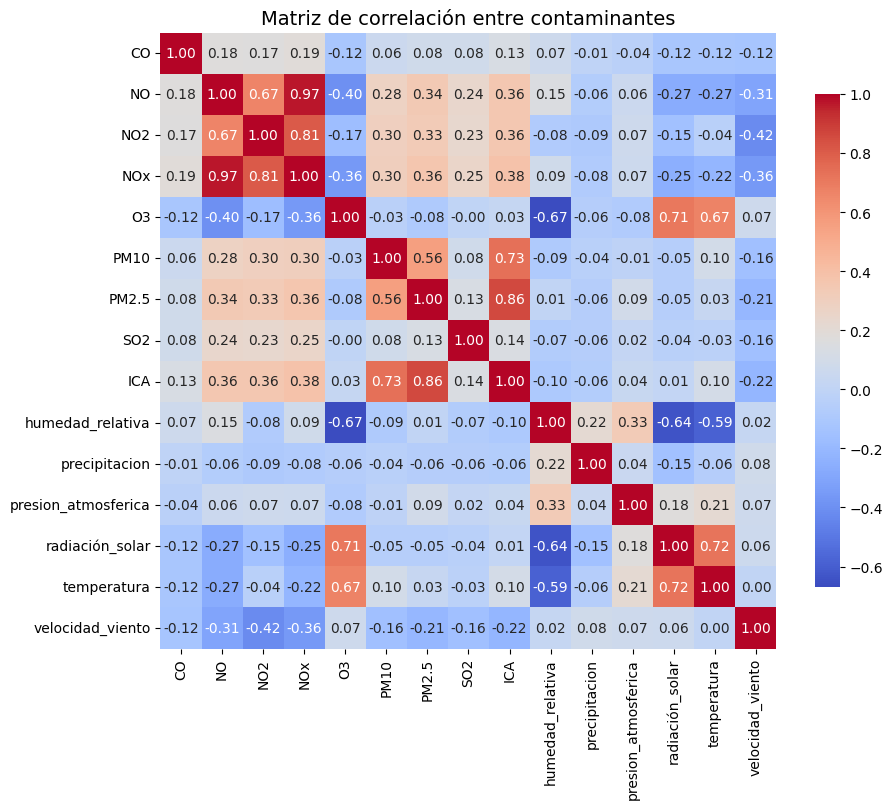

In [44]:
df_corr = df_ica.select_dtypes(include='number')
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlación entre contaminantes", fontsize=14)
plt.show()

Los NOx, NO y NO2 (óxidos de nitrógeno) están muy correlacionados entre sí, lo cual tiene sentido ya que pertenecen al mismo grupo de contaminantes y suelen emitirse juntos (sobretodo por el tráfico, la combustión...). Estos además tienen una correlación inversa moderada con el O3 (ozono), por lo que cuando uno sube el otro tiende a bajar. Tienen correlaciones moderadas con el resto de contaminante y con el ICA y muy poca relación con la meteorología, salvo con la radiación solar y la temperatura que tienen algo de relación inversa (al subir uno tiende a bajar el otro)

El O3 presenta una correlación inversa importante con la humedad relativa, por lo que a mayor humedad, menor concentración de ozono. Aparte tiene una correlación positiva con la radiación solar y la temperatura, justo por lo mismo, ya que estas dos y la humedad suelen ir relacionadas a la inversa. A mayor temperatura o radiación, mayor concentración de ozono (O3).

PM 10 está correlacionado con su par, PM2.5, y tiene bastante correlación con nuestra variable objetivo (ICA), por lo que este contaminante debe ser de los más importantes a la hora de obtener el ICA diario. PM2.5 tiene aún más relación con el ICA, por lo que será el contaminante más importante para el calculo de su valor diario. Ambos tienen una relación positiva, por lo que al subir la cantidad de material aprticulado en el aire, el valor ICA sube también.

El CO y el SO2 tienen correlaciones bajas con casi todas las variables. Los únicos en los que es algo más alta son los NOx, pero de manera moderada. Podría haber una tendencia a aumentar de la mano.

En cuanto a los fenómenos meteorológicos, vemos que la humedad va correlacionada inversamente a la temperatura y radiación del sol y moderadamente a la precipitación y presión atmosférica, por lo que va a subir cuando hay poca temperature, poca radiación solar, poco O3 y aumentan las precipitaciones y presión atmosférica. Sin embargo, hay que tener en cuenta que, a su vez, la presión atmosférica tiene una correlación positiva, aunque baja, con la radiación y la temperatura. Por último, la velocidad del viento no tiene demasiada correlación con las variables, excepto inversa con los NO, el PM2.5 y el ICA, de modo que al aumentar el viento tienen de disminuir estas.


In [45]:
df_correlaciones = df_corr.corr()
df_correlaciones = df_correlaciones.where(np.triu(np.ones(df_correlaciones.shape)).astype(bool))
df_correlaciones = df_correlaciones.stack().reset_index()
df_correlaciones.columns = ['Row','Column','Value']
df_correlaciones = df_correlaciones[df_correlaciones['Row']!=df_correlaciones['Column']]
df_correlaciones

Row            Column     Value
1                     CO                NO  0.176151
2                     CO               NO2  0.171836
3                     CO               NOx  0.185887
4                     CO                O3 -0.117473
5                     CO              PM10  0.058383
..                   ...               ...       ...
112  presion_atmosferica       temperatura  0.211114
113  presion_atmosferica  velocidad_viento  0.069955
115      radiación_solar       temperatura  0.723904
116      radiación_solar  velocidad_viento  0.064455
118          temperatura  velocidad_viento  0.002609

[105 rows x 3 columns]

En cuanto a colinealidad, se nos presentaría en un alto grado entre NOx y NO, por lo que quizás necsitemos desprendernos de NOx, que engloba a todos los oxidos de nitrógeno (también con NO y NO2). PM2.5 etá correlacionado atamente con ICA, pero no es colinealidad, ya que ICA es la variable objetivo y entonces PM2.5 es realmente valiosa

In [46]:
df_colinealidad = df_correlaciones[abs(df_correlaciones['Value'])>0.85]
df_colinealidad

Row Column     Value
17     NO    NOx  0.972880
77  PM2.5    ICA  0.858509

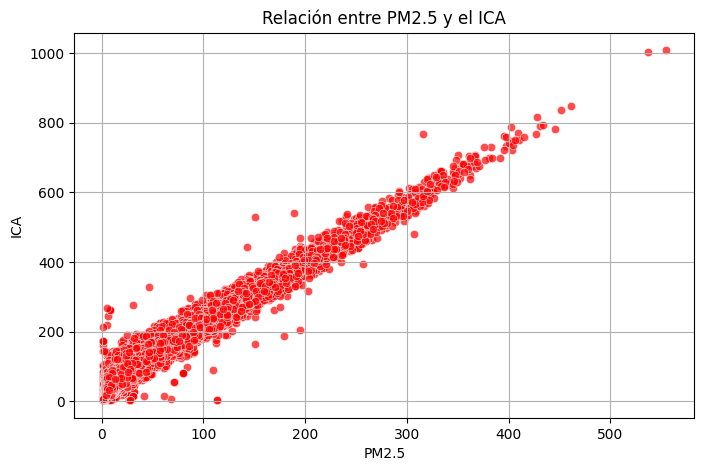

In [47]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_ica, x='NO', y='NOx', color='red', alpha=0.7)
plt.title('Relación entre PM2.5 y el ICA')
plt.xlabel('PM2.5')
plt.ylabel('ICA')
plt.grid(True)
plt.show()

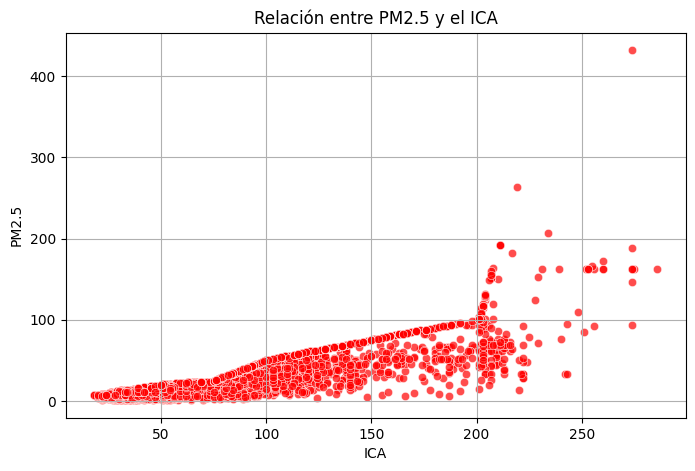

In [48]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_ica, x='ICA', y='PM2.5', color='red', alpha=0.7)
plt.title('Relación entre PM2.5 y el ICA')
plt.xlabel('ICA')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

____

### ANALISIS DIARIO DE LA CALIDAD DEL AIRE (ICA)

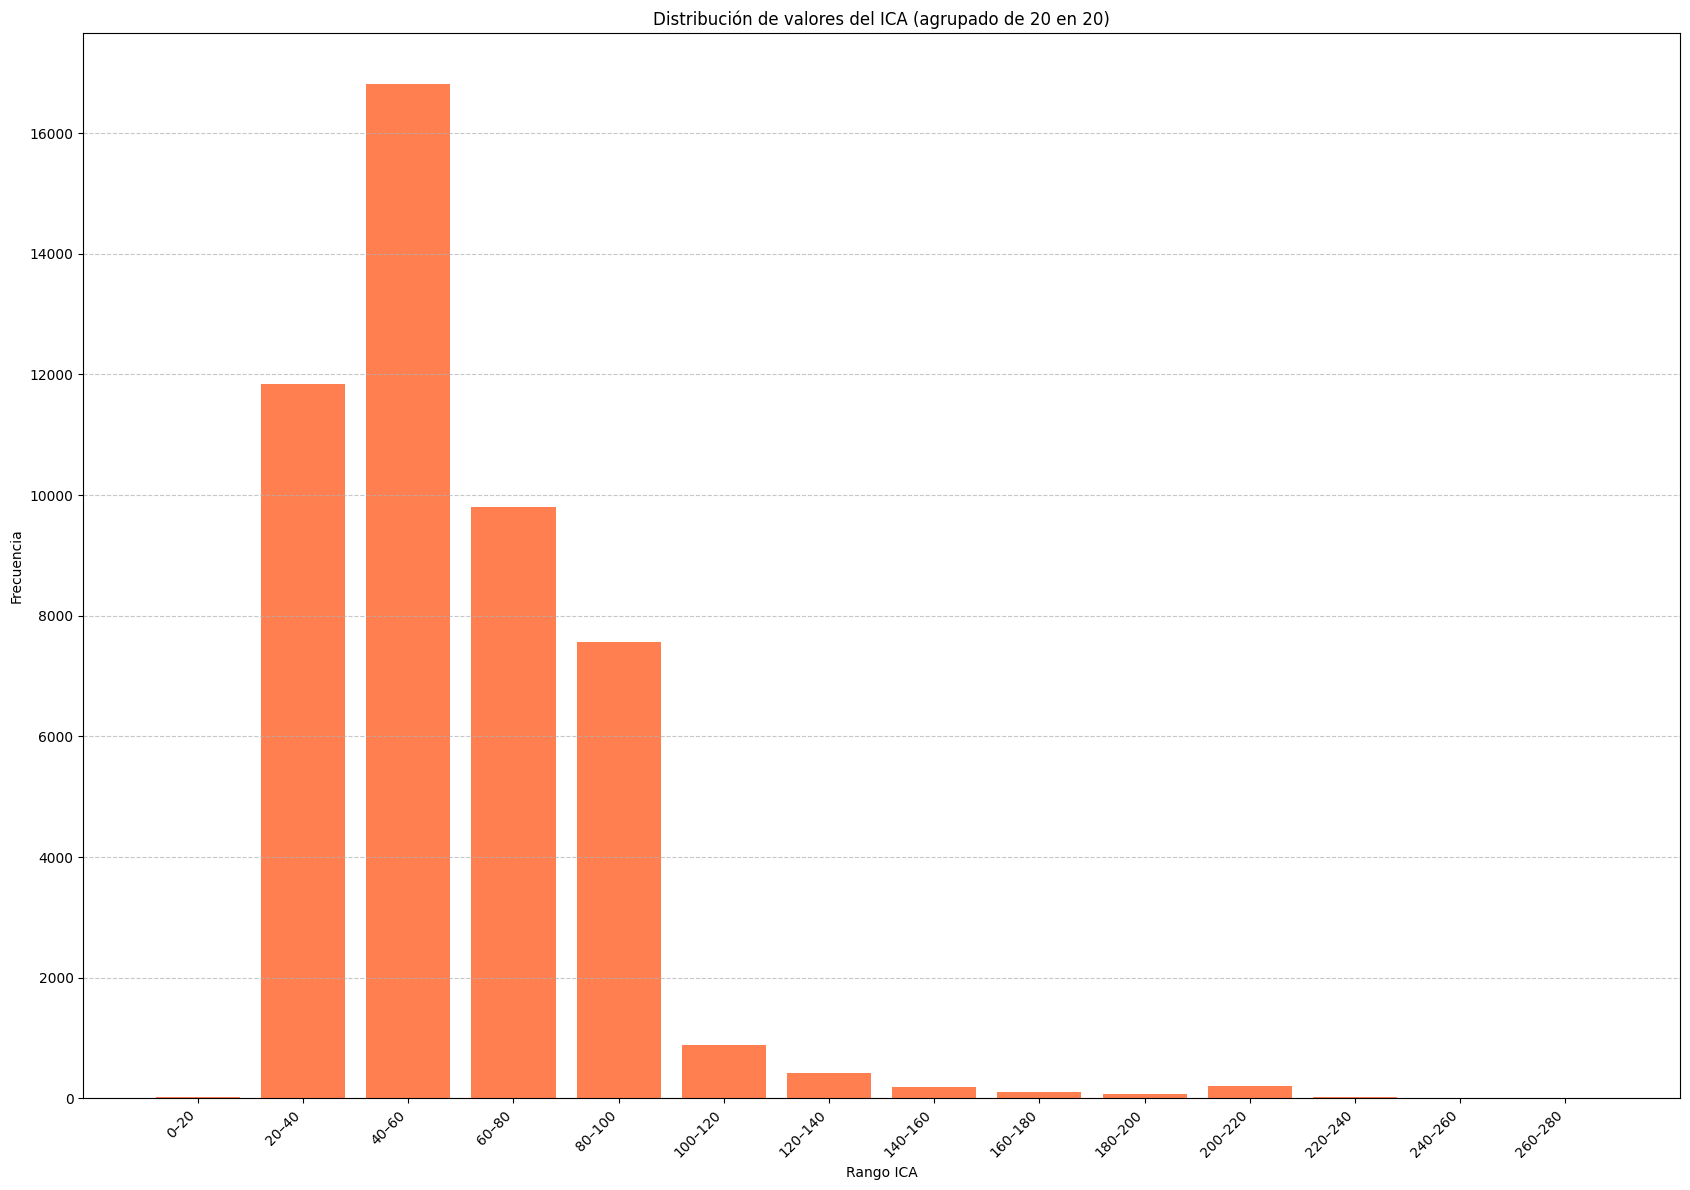

ICA    (0, 20]  (20, 40]  (40, 60]  (60, 80]  (80, 100]  (100, 120]  \
count       19     11842     16821      9801       7571         894   

ICA    (120, 140]  (140, 160]  (160, 180]  (180, 200]  (200, 220]  (220, 240]  \
count         423         189         113          71         205          18   

ICA    (240, 260]  (260, 280]  
count          14           7

In [49]:
ica_counts = df_ica["ICA"].value_counts(ascending=False)

bins = pd.cut(df_ica["ICA"], bins=range(0, int(df_ica["ICA"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del ICA (agrupado de 20 en 20)")
plt.xlabel("Rango ICA")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

ica_counts.to_frame().T

Distribución de los valores del ICA

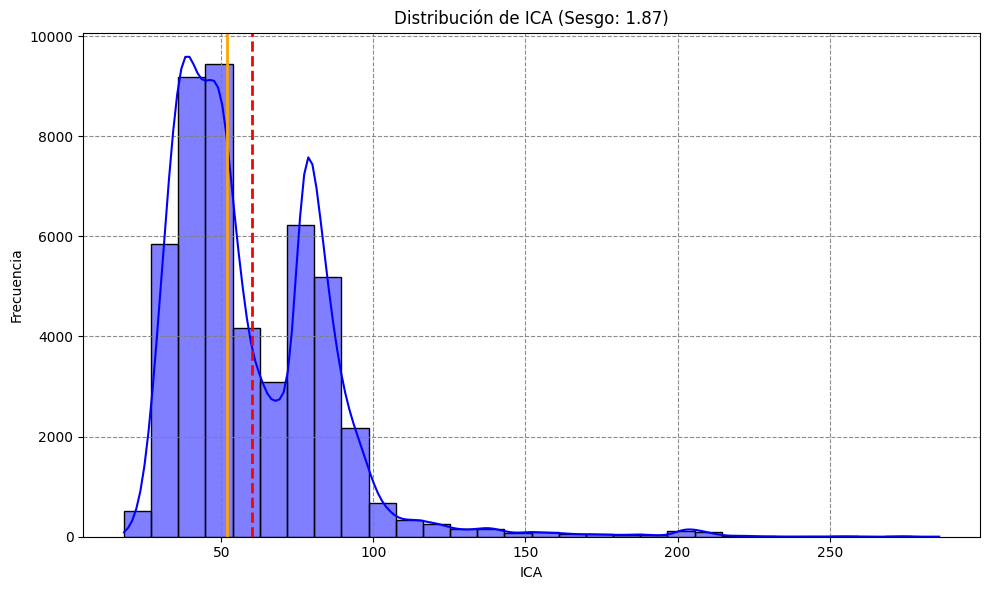

np.float64(1.8689284974186262)

In [50]:
ica_mean = df_ica['ICA'].mean()
ica_median = df_ica['ICA'].median()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_ica, x="ICA", bins=30, kde=True, color="blue")
plt.axvline(ica_mean, color='red', linestyle='--', linewidth=2, label=f"Media: {ica_mean:.2f}")
plt.axvline(ica_median, color='orange', linestyle='-', linewidth=2, label=f"Mediana: {ica_median:.2f}")

plt.title(f"Distribución de ICA (Sesgo: {df_ica['ICA'].skew():.2f})")
plt.xlabel("ICA")
plt.ylabel("Frecuencia")
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

ica_skewness = df_ica['ICA'].skew()
ica_skewness

La distribución del ICA indica una asimetría positiva fuerte, ya que el skewness es positivo y por encima de 1.Tiene una larga cola a la derecha, donde los valores son menos frecuentes y más altos, mientras que se tiende a valores bajos de ICA, donde se concentran casi todos, entre 20 y 100, siendo la mayor frecuencia de entre 40 y 60 y 20 y 40. La media es mayor a la mediana

In [51]:
categoria_counts = df_ica["categoria_ICA"].value_counts().sort_values(ascending=False).reset_index()
categoria_counts.columns = ["categoria_ICA", "cuenta"]

En las categorías, observamos que la más frecuente es 'Moderada' y seguida de esta, la categoría 'Buena'. tras ellas, ya siguen el orden de menos concentración a más concentración, siendo la más baja la categoría 'Peligrosa', que sólo tiene 1 registro

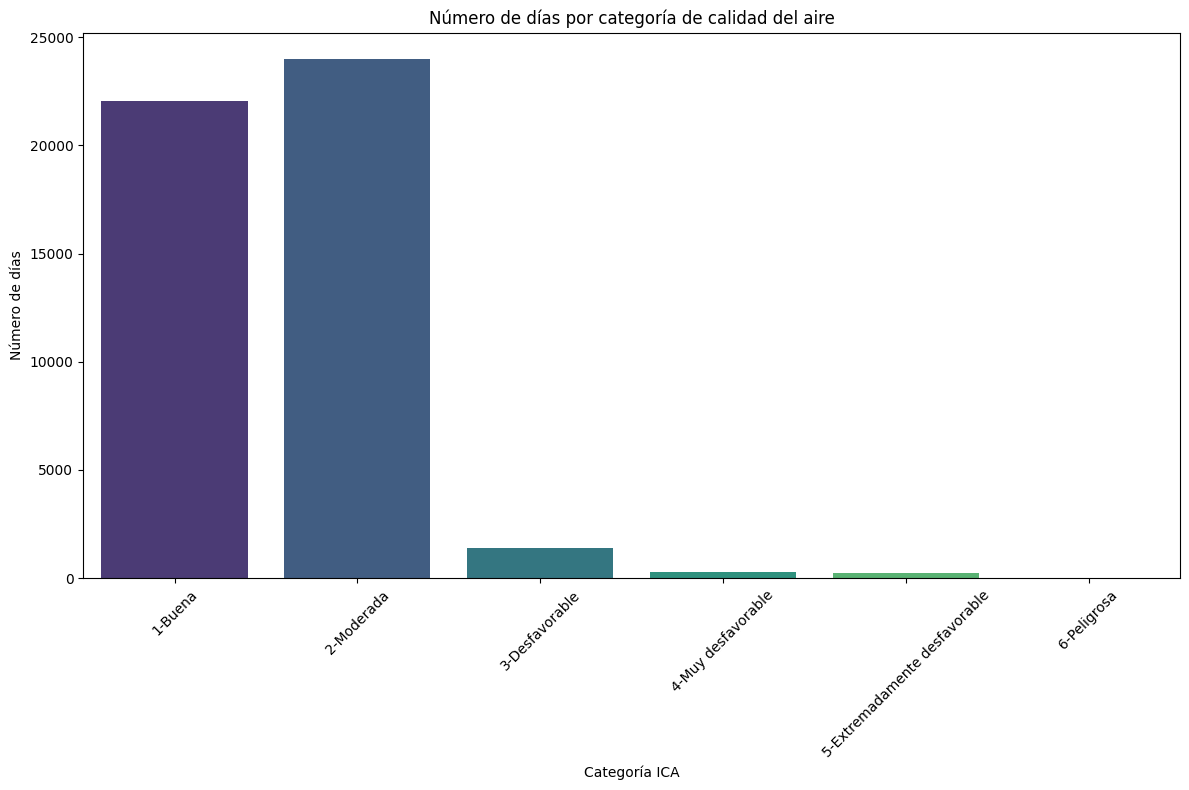

1           0               2                   3  \
categoria_ICA  1-Buena  2-Moderada  3-Desfavorable  4-Muy desfavorable   
recuento         22052       24002            1413                 277   

                                           4            5  
categoria_ICA  5-Extremadamente desfavorable  6-Peligrosa  
recuento                                 245            1

In [52]:
categoria_counts = df_ica["categoria_ICA"].value_counts().reset_index()
categoria_counts.columns = ["categoria_ICA", "recuento"]

categoria_counts = categoria_counts.sort_values(by="categoria_ICA")

colores = sns.color_palette("viridis", len(categoria_counts))
plt.figure(figsize=(12, 8))
sns.barplot(data=categoria_counts, x="categoria_ICA", y="recuento", palette=colores)
plt.title("Número de días por categoría de calidad del aire")
plt.xlabel("Categoría ICA")
plt.ylabel("Número de días")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

categoria_counts.T

ESTADÍSTICAS DEL ICA

In [53]:
df_ica['ICA'].describe().to_frame().T

count       mean        std   min   25%   50%   75%    max
ICA  47989.0  59.947425  25.958393  18.0  41.0  52.0  78.0  286.0

In [54]:
print(f'La media del ICA entre 2020 y 2025 es{df_ica['ICA'].mean(): .2f}')
print(f'El valor de ICA más frecuente entre 2020 y 2025 fue {df_ica['ICA'].mode()[0]}')
print(f'El valor máximo del ICA entre 2020 y 2025 fue {df_ica['ICA'].max()}')
print(f'El valor mínimo del ICA entre 2020 y 2025 fue {df_ica['ICA'].min()}')
print(f'La desviación estándar del ICA entre 2020 y 2025 es{df_ica['ICA'].std(): .3f}')
print(f'La varianza del ICA es{df_ica['ICA'].var(): .2f}')
print(f'El coeficiente de variación del ICA es{df_ica['ICA'].std()/np.abs(df_ica['ICA'].mean()): .2f}')

La media del ICA entre 2020 y 2025 es 59.95
El valor de ICA más frecuente entre 2020 y 2025 fue 39
El valor máximo del ICA entre 2020 y 2025 fue 286
El valor mínimo del ICA entre 2020 y 2025 fue 18
La desviación estándar del ICA entre 2020 y 2025 es 25.958
La varianza del ICA es 673.84
El coeficiente de variación del ICA es 0.43


In [55]:
min_ica = df_ica[df_ica['ICA'] == df_ica['ICA'].min()]
min_ica

fecha    municipio   CO   NO   NO2   NOx    O3  PM10  PM2.5  SO2  \
12033 2021-05-16  FUENLABRADA  0.7  3.0  11.0  15.0  43.0  11.0    7.0  2.0   
12038 2021-05-16     MÓSTOLES  0.3  1.0  10.0  12.0  39.0  12.0    7.0  1.0   
36538 2024-01-15   ATAZAR, EL  0.3  3.0  19.0  21.0  44.0   9.0    7.0  2.0   

       ICA categoria_ICA  humedad_relativa  precipitacion  \
12033   18       1-Buena             52.58           0.00   
12038   18       1-Buena             62.25           0.00   
36538   18       1-Buena             96.38           0.12   

       presion_atmosferica  radiación_solar  temperatura  velocidad_viento  
12033               938.83           290.12        18.98              2.00  
12038               943.71           297.33        18.47              1.98  
36538               897.29            37.17         6.71              1.35

In [56]:
max_ica = df_ica[df_ica['ICA'] == df_ica['ICA'].max()]
max_ica

fecha         municipio   CO   NO  NO2  NOx    O3   PM10  PM2.5  \
19311 2022-03-15  ORUSCO DE TAJUÑA  0.3  1.0  4.0  6.0  91.0  889.0  162.0   

       SO2  ICA                  categoria_ICA  humedad_relativa  \
19311  3.0  286  5-Extremadamente desfavorable             35.03   

       precipitacion  presion_atmosferica  radiación_solar  temperatura  \
19311            0.0               642.05            53.85         9.07   

       velocidad_viento  
19311              2.75

Indagamos un poco sobre los municipios con más valores máximos

In [57]:
topmax_ica = df_ica[df_ica['ICA'] > 200]
topmax_ica

fecha                   municipio   CO     NO    NO2    NOx    O3  \
1     2020-01-01                  ALCOBENDAS  1.3  158.0   86.0  329.0  30.0   
2     2020-01-01                    ALCORCÓN  1.3  137.0   90.0  297.0  24.0   
4     2020-01-01                    ARANJUEZ  1.3   87.0   51.0  183.0  26.0   
5     2020-01-01             ARGANDA DEL REY  1.3   45.0   41.0  104.0  33.0   
8     2020-01-01              COLMENAR VIEJO  1.5  179.0  103.0  378.0  24.0   
...          ...                         ...  ...    ...    ...    ...   ...   
44625 2024-10-31  SAN SEBASTIÁN DE LOS REYES  0.6    3.0   20.0   22.0  79.0   
44626 2024-10-31           TORREJÓN DE ARDOZ  0.6   40.0   56.0   99.0  80.0   
44627 2024-10-31                   VALDEMORO  0.6   24.0   58.0   94.0  75.0   
44629 2024-10-31       VILLAREJO DE SALVANÉS  0.6   11.0   56.0   72.0  82.0   
46363 2025-01-01                   VALDEMORO  0.5   83.0   67.0  166.0  67.0   

        PM10  PM2.5  SO2  ICA                  categoria_ICA  \
1       85.0  151.0  1.0  207  5-Extremadamente desfavorable   
2       89.0  264.0  1.0  219  5-Extremadamente desfavorable   
4       58.0  151.0  1.0  207  5-Extremadamente desfavorable   
5       62.0  151.0  1.0  207  5-Extremadamente desfavorable   
8       89.0  151.0  1.0  207  5-Extremadamente desfavorable   
...      ...    ...  ...  ...                            ...   
44625  163.0  101.0  2.0  201  5-Extremadamente desfavorable   
44626  202.0   85.0  2.0  201  5-Extremadamente desfavorable   
44627  215.0   51.0  2.0  203  5-Extremadamente desfavorable   
44629  215.0   73.0  2.0  203  5-Extremadamente desfavorable   
46363   46.0  155.0  5.0  207  5-Extremadamente desfavorable   

       humedad_relativa  precipitacion  presion_atmosferica  radiación_solar  \
1                 77.04           0.01               954.25           102.08   
2                 78.08           0.00               952.08           115.58   
4                 80.08           0.01               977.00            67.50   
5                 84.21           0.00               962.75            97.29   
8                 68.46           0.01               923.83           116.08   
...                 ...            ...                  ...              ...   
44625             78.25           0.03               941.50           140.96   
44626             72.04           0.05               953.58           141.92   
44627             81.50           0.02               947.96            98.33   
44629             72.79           0.00               934.67           142.88   
46363             83.58           0.00               956.79            83.33   

       temperatura  velocidad_viento  
1             5.16              0.32  
2             8.26              0.95  
4             2.89              0.12  
5             4.52              0.69  
8             7.70              0.32  
...            ...               ...  
44625        13.46              0.33  
44626        16.05              1.15  
44627        15.23              1.10  
44629        15.73              1.35  
46363         4.32              0.70  

[245 rows x 18 columns]

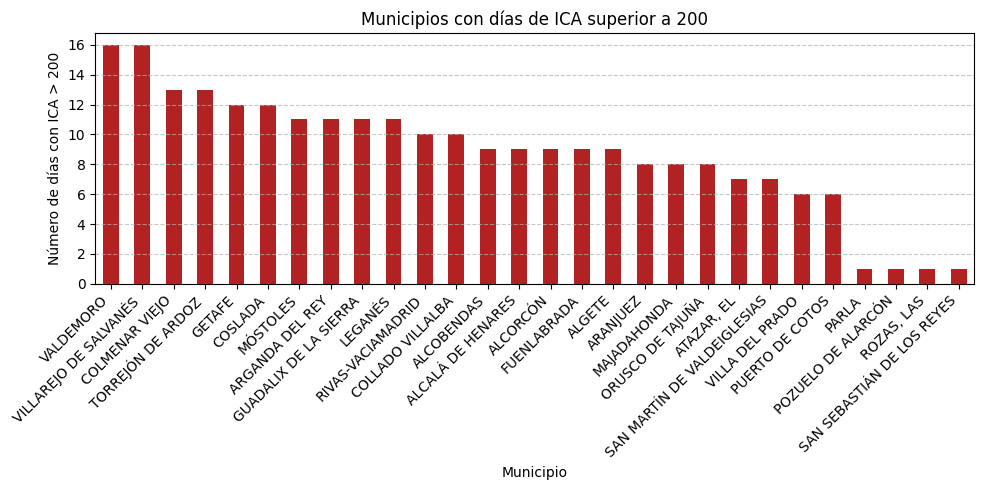

municipio  VALDEMORO  VILLAREJO DE SALVANÉS  COLMENAR VIEJO  \
count             16                     16              13   

municipio  TORREJÓN DE ARDOZ  GETAFE  COSLADA  MÓSTOLES  ARGANDA DEL REY  \
count                     13      12       12        11               11   

municipio  GUADALIX DE LA SIERRA  LEGANÉS  
count                         11       11

In [58]:
top_ica_municipios = df_ica[df_ica["ICA"] > 200]["municipio"].value_counts()

top_ica_municipios.plot(kind="bar", color="firebrick", figsize=(10, 5))
plt.title("Municipios con días de ICA superior a 200")
plt.xlabel("Municipio")
plt.ylabel("Número de días con ICA > 200")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

top_ica_municipios.head(10).to_frame().T

Analizamos los valores atípicos (outliers): vemos bastantes valores atípicos para la variable ICA. A continuación lo analizamos en profundidad

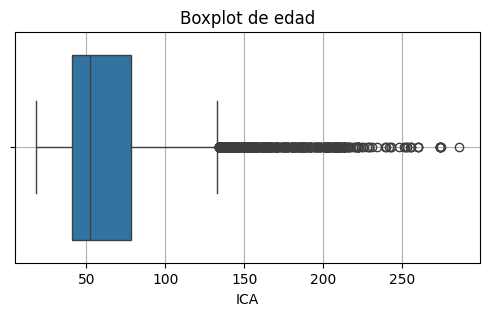

In [59]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['ICA'])
plt.grid(True)
plt.title('Boxplot de edad')
plt.show()

In [60]:
Q1_ICA = df_ica['ICA'].quantile(0.25)
Q3_ICA = df_ica['ICA'].quantile(0.75)
IQR_ICA = Q3_ICA - Q1_ICA

upper_limit_ICA = Q3_ICA + 1.5 * IQR_ICA
print(f"ICA que se considera outlier: {upper_limit_ICA} o más")

outliers_ICA = df_ica[df_ica['ICA'] > upper_limit_ICA]
print(f"Cantidad de outliers: {len(outliers_ICA)}")

ICA que se considera outlier: 133.5 o más
Cantidad de outliers: 772


ANÁLISIS TEMPORAL DEL ICA

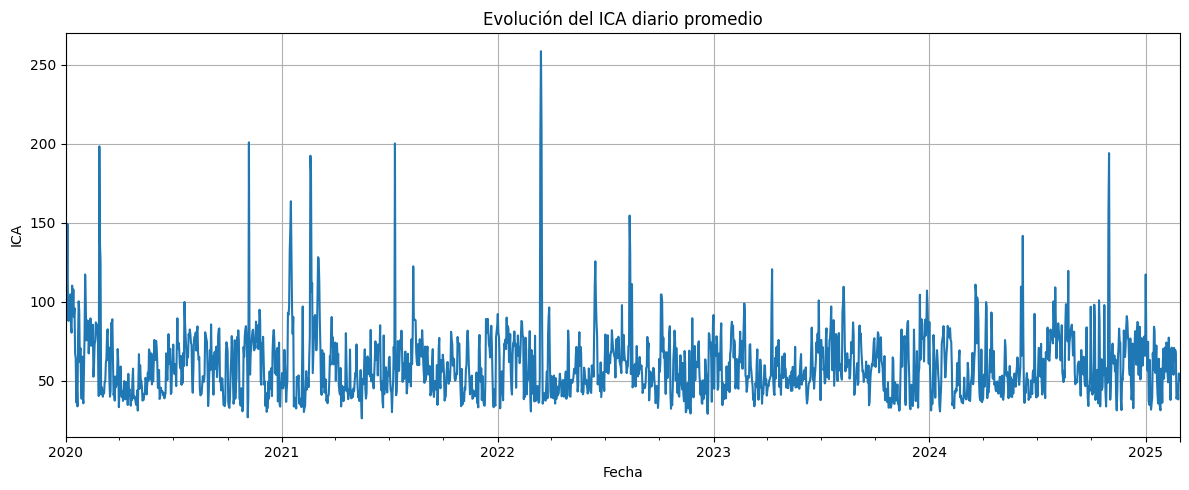

In [61]:
df_ica["fecha"] = pd.to_datetime(df_ica["fecha"])
ica_diario = df_ica.groupby("fecha")["ICA"].mean()

plt.figure(figsize=(12, 5))
ica_diario.plot()
plt.title("Evolución del ICA diario promedio")
plt.xlabel("Fecha")
plt.ylabel("ICA")
plt.grid(True)
plt.tight_layout()
plt.show()

Panel 1: Serie original (ICA)
Hay fluctuaciones grandes a lo largo del tiempo, con picos esporádicos (algunos muy altos), pero se ven parecidos entre las mismas temporada de cada año, por ejemplo teniendo picos y subidas a principios de cada año. Los valores son relativamente estables, pero con eventos extremos (quizá de contaminación puntual, incendios, inversión térmica, episodios de calima...)

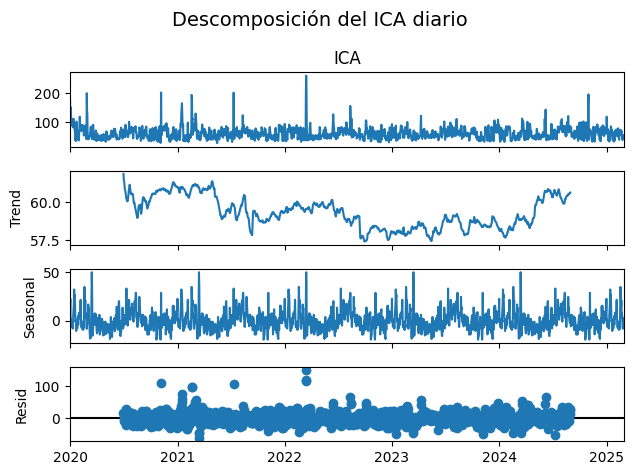

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

ica_diario = df_ica.groupby("fecha")["ICA"].mean()
ica_diario = ica_diario.asfreq("D")

resultado = seasonal_decompose(ica_diario.interpolate(), model="additive", period=365)

resultado.plot()
plt.suptitle("Descomposición del ICA diario", fontsize=14)
plt.tight_layout()
plt.show()

Panel 2: Tendencia
Presenta una tendencia descendente entre 2020 y 2022, seguida de una recuperación a partir de 2023. Podría estar relacionada con medidas de reducción de emisiones, efectos de confinamientos COVID en los primeros años, y luego un retorno progresivo a la normalidad.

Panel 3: Estacionalidad
Presenta patrones repetitivos que indican una fuerte componente estacional. Podría haber ciclos mensuales o anuales, posiblemente relacionados con estaciones (por ejemplo, mayor contaminación en invierno por calefacción y oxidos de nitrógeno, o en verano por ozono).

Panel 4: Residuo
Los residuos parecen ser mayormente valores atípicos que superan los 100 de ICA. Esto indica que hay días con variaciones que no se explican por tendencia o estacionalidad.

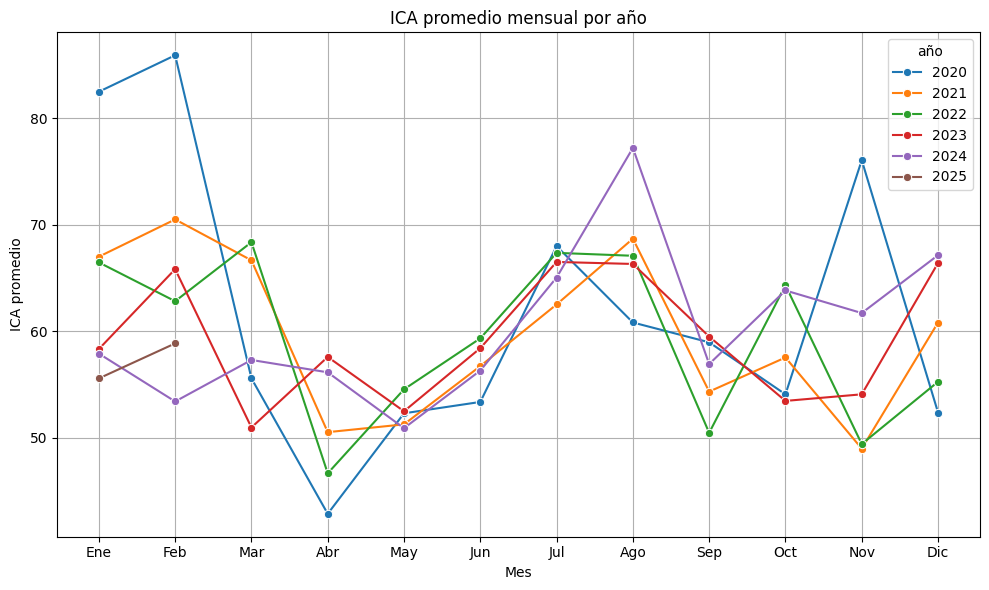

In [63]:
df_temp = df_ica.copy()
df_temp["año"] = df_temp["fecha"].dt.year
df_temp["mes"] = df_temp["fecha"].dt.month

ica_mes_anio = df_temp.groupby(["año", "mes"], as_index=False)["ICA"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=ica_mes_anio, x="mes", y="ICA", hue="año", marker="o", palette="tab10")
plt.title("ICA promedio mensual por año")
plt.xlabel("Mes")
plt.ylabel("ICA promedio")
plt.xticks(ticks=range(1, 13), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun",
                                       "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.grid(True)
plt.tight_layout()
plt.show()

EL ICA promedio muestra un descenso enorme entre febrero (con el pico máximo de media del ICA) y abril de 2020, coincidiendo con las medidas de confinamiento del covid 19. Esta época suele tener bajadas en este valor, pero no tan pronunciadas, por lo que se achaca a esto el bajo ICA en promedio. En Abril se alcanza el mínimo absoluto en la media del ICA para todos los años (2020-2025). Sube con la desescalada del confinamiento en Junio, para volver a bajar con las medidas restrictivas de verano y el miedo al contagio, para volver a subir en noviembre, con un máximo.

En 2021 tenemos una bajada drástica también en los meses de primavera, pero no tan grande como en 2020. En agosto vuelve a subir, quizás por el calor o los viajes en coche y transportes contaminantes en época veraniega. Más tarde es un poco más estable y vemos que la situación por covid se va nromalizando poco a poco.

En 2022 y 2023 hay un patrón más estable, con vuelta a la bajada del ICA en primavera y posterior subida. En Abril también hay un mínimo importante. No presentó máximos importantes.

En 2024 observamos valores de ICA bajos, con respecto a los otros años, en los primeros meses del año. Luego tiene unas emdias muy parecidas a los años 22 y 23, salvo por un repunte, que marca uno de los máximos de ICA promedio de la serie temporal, con casi 80 de media. Tras ello vuelve un poco a la normalidad de los anteriores años. Acaba el año con la media de ICA más alta de la serie para Diciembre

De 2025, al tener solo enero y Febrero, solo se puede decir que Enero tuvo la media de ICA más baja de toda la serie de 2020 a 2025.

Si lo vemos por meses, observamos un patrón a la baja en el mes de Abril, donde el ICA tiende a ser bajo en todos los años. En verano sube y es cuando todos los años suele haber valores altos pero estables entre todos los años por lo general. En Enero y Febrero tendía a ser más alto, pero estos últimos años ha bajado, mientras que en Diciembre ha subido

In [64]:
def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verano'
    elif mes in [9, 10, 11]:
        return 'Otoño'
    else:
        return 'Invierno'

df_ica['estacion'] = df_ica['fecha'].apply(obtener_estacion)

ica_por_estacion = df_ica.groupby('estacion')['ICA'].mean().reset_index()

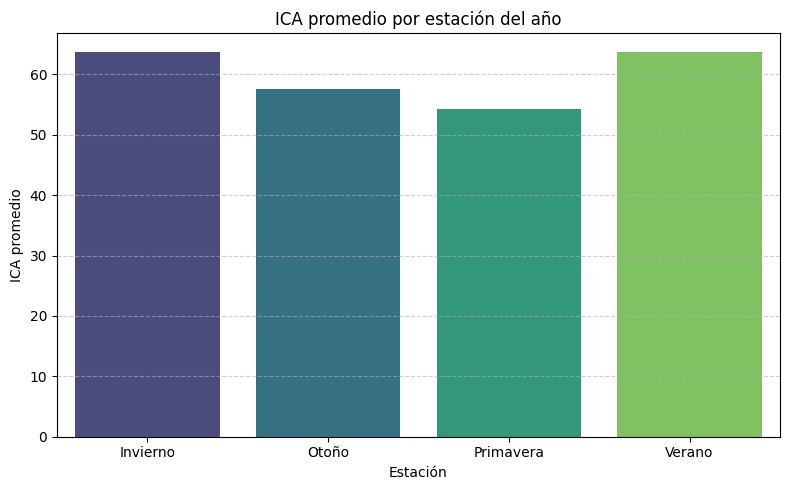

0          1          2          3
estacion   Invierno      Otoño  Primavera     Verano
ICA       63.668361  57.622455  54.319914  63.710293

In [65]:
plt.figure(figsize=(8, 5))
sns.barplot(data=ica_por_estacion, x='estacion', y='ICA', palette='viridis')
plt.title("ICA promedio por estación del año")
plt.ylabel("ICA promedio")
plt.xlabel("Estación")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

ica_por_estacion.T

Aquí observamos mejor como en primavera el ICa promdeio es más bajo, seguido del otoño. Por otro lado, verano e invierno presentan valores más altos (en torno a 63 de ICA) y extremadamente parecidos. Aunque solo por decimales, verano sería la estación con mayor ICA

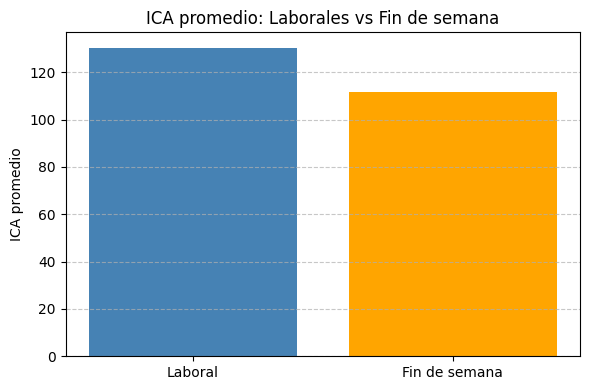

tipo_dia         ICA
0        Laboral  130.385420
1  Fin de semana  111.487648

In [66]:
contaminantes_interes = [
    'SO2', 'NO2', 'PM10', 'NOx', 'O3', 'NO', 'PM2.5', 'CO'
]

contaminantes_presentes = [col for col in df_ica.columns if col in contaminantes_interes]
df_ica["ICA"] = df_ica[contaminantes_presentes].max(axis=1)

ica_por_tipo_dia = (
    df_ica
    .assign(tipo_dia=df_ica["fecha"].dt.dayofweek >= 5)
    .groupby("tipo_dia")["ICA"]
    .mean()
    .reset_index()
)
ica_por_tipo_dia["tipo_dia"] = ica_por_tipo_dia["tipo_dia"].map({False: "Laboral", True: "Fin de semana"})

plt.figure(figsize=(6, 4))
plt.bar(ica_por_tipo_dia["tipo_dia"], ica_por_tipo_dia["ICA"], color=["steelblue", "orange"])
plt.title("ICA promedio: Laborales vs Fin de semana")
plt.ylabel("ICA promedio")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

ica_por_tipo_dia

Entre días laborables y fines de semana observamos una clara tendencia a que el ICA sea mayor entre semana, pudiendo ser debido al tráfico, los atascos, dessplazamientos a los trabajos y la actividad industrial. Los fines de semana baja casi 20 puntos de media. Anaizando los días, vemos que el domingo suele ser el día con menor valor de ICA y que los martes y miércoles tienden a ser los días con peor calidad de aire.

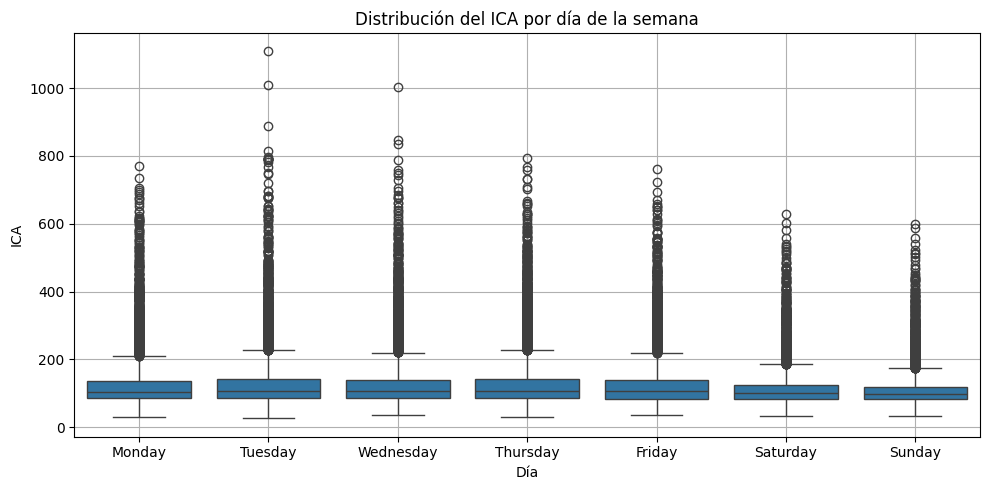

In [67]:
df_ica["dia_semana"] = df_ica["fecha"].dt.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_ica, x="dia_semana", y="ICA", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribución del ICA por día de la semana")
plt.xlabel("Día")
plt.ylabel("ICA")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ANÁLISIS POR CONTAMINANTES

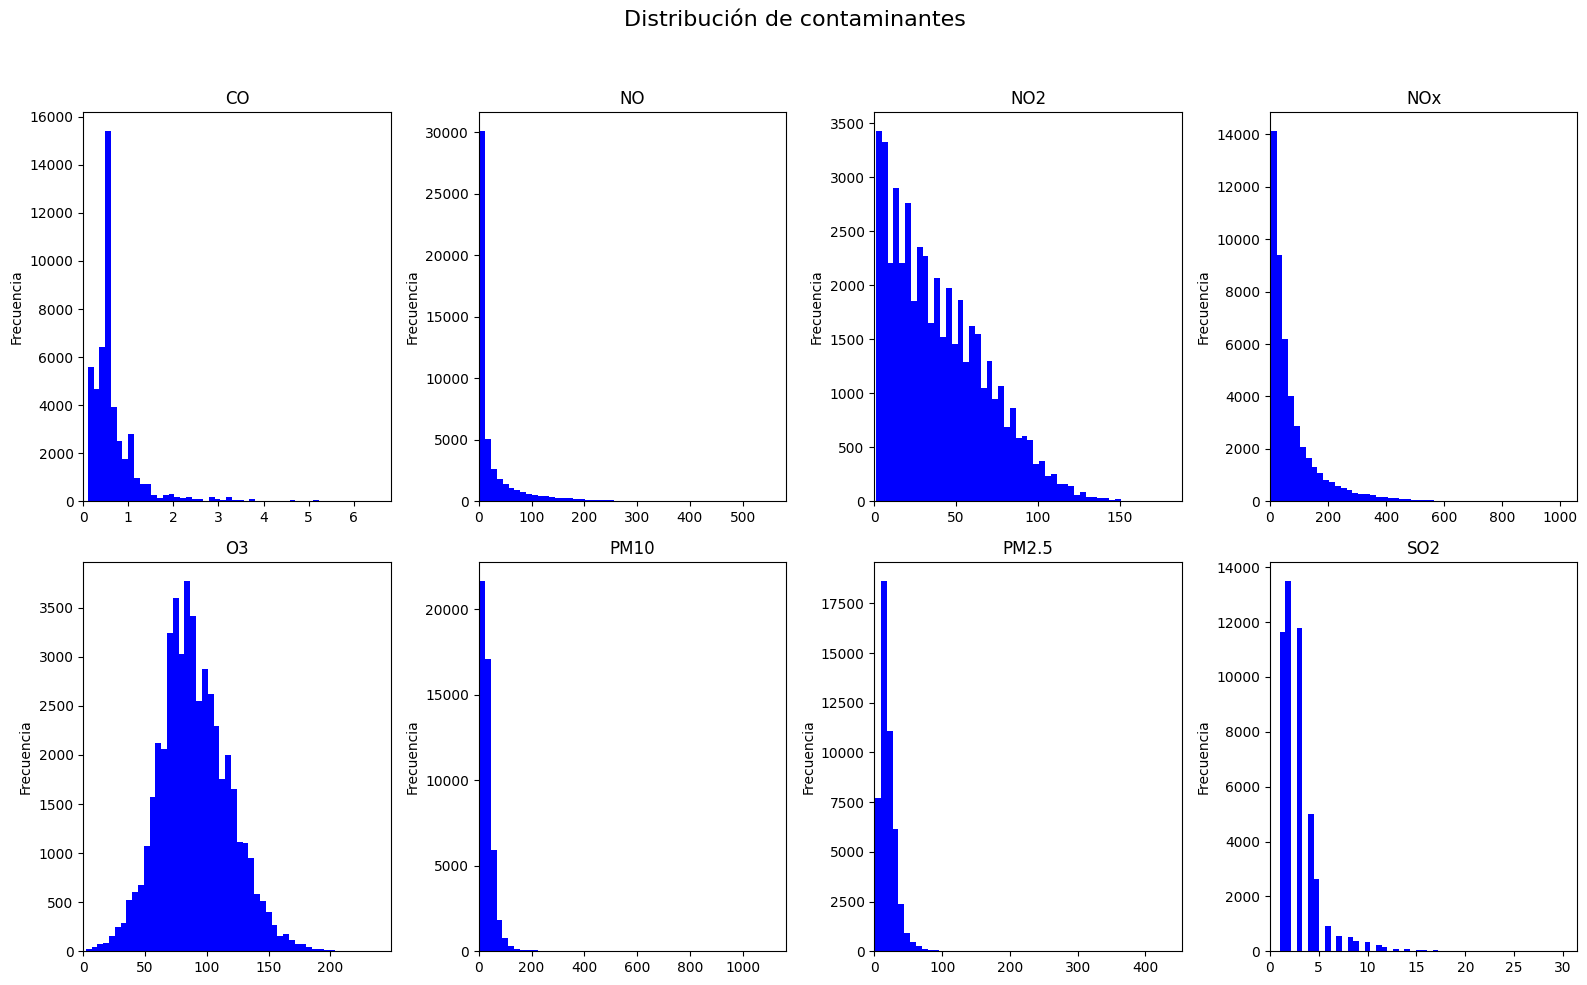

In [68]:
contaminantes = ["CO", "NO", "NO2", "NOx", "O3", "PM10", "PM2.5", "SO2"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(contaminantes):
    data = df_ica[col]
    data = data[data > 0]
    axes[i].hist(data, bins=50, color="blue")
    axes[i].set_title(col)
    axes[i].set_xlim(left=0)
    axes[i].set_ylabel("Frecuencia")

plt.suptitle("Distribución de contaminantes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

La ECDF muestra, para cada contaminante, qué proporción de valores está por debajo de un determinado nivel de concentración. Las curvas que se elevan más rápidamente indican que la mayoría de los datos están concentrados en valores bajos, mientras que curvas más planas indican mayor dispersión o presencia de valores altos. De ahí que CO, SO₂, PM2.5. sean contaminantes con tendencia a concentraciones bajas, mientras que los NOx, PM10 y O₃ tiendan a ser contaminantes con más dispersión (y posibles picos).

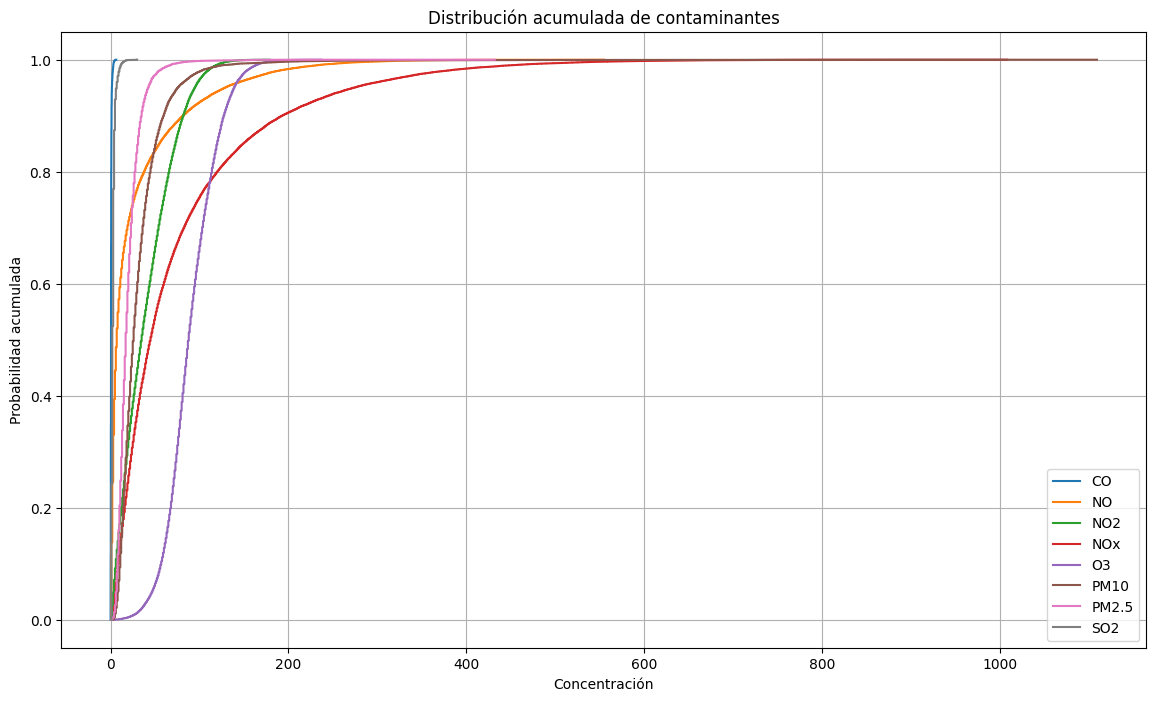

In [69]:
from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize=(14, 8))
for col in contaminantes:
    data = df_ica[col]
    ecdf = ECDF(data[data > 0])
    plt.plot(ecdf.x, ecdf.y, label=col)

plt.title("Distribución acumulada de contaminantes")
plt.xlabel("Concentración")
plt.ylabel("Probabilidad acumulada")
plt.legend()
plt.grid()
plt.show()

OZONO (O3): Se refiere al ozono a nivel del suelo, no el de la capa de ozono. Se forma por reacciones entre oxidos de nitrógeno y compuestos orgánicos volátiles con la luz solar. Los valores altos se relacionan con radiación solar intensa, tráfico y altas temperaturas.

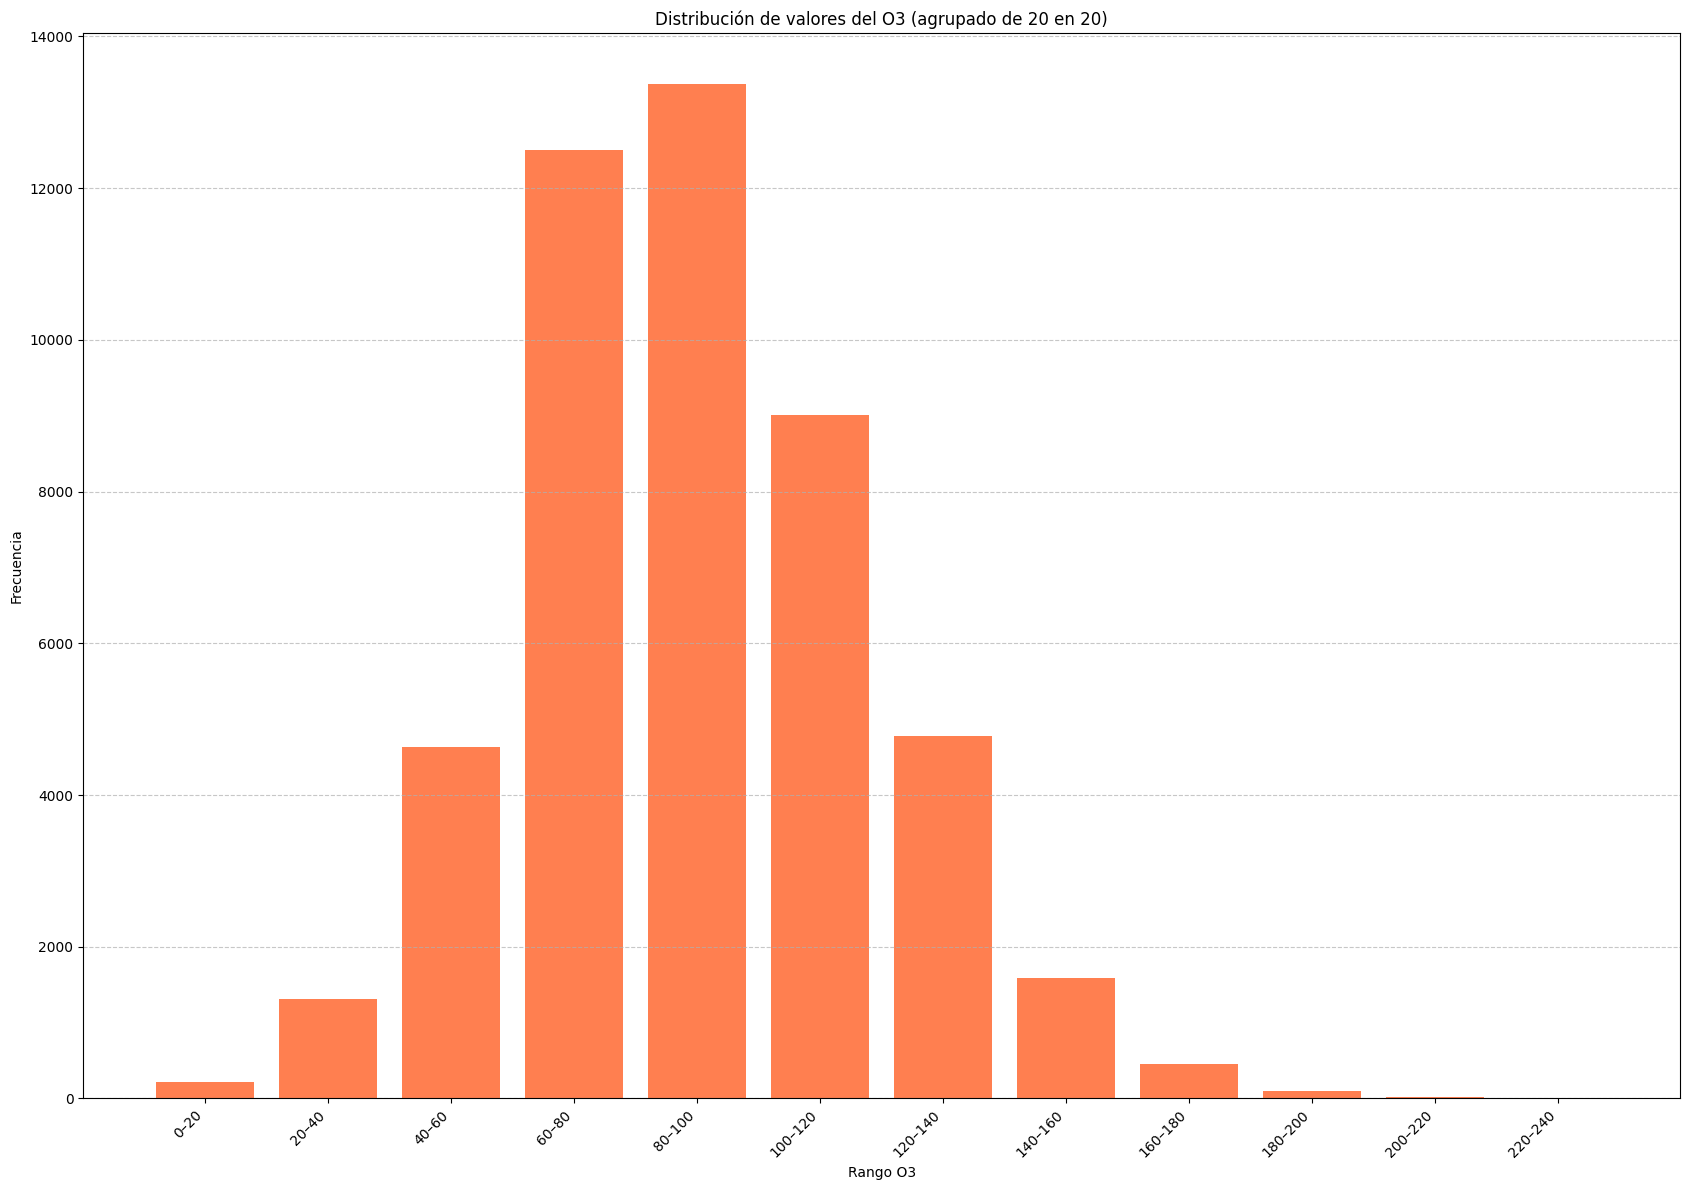

O3     86.0  79.0  82.0  83.0  81.0  84.0  80.0  78.0  75.0  76.0  ...  58.5  \
count   768   766   764   760   759   757   752   751   745   732  ...     1   

O3     41.5  80.5  65.5  74.5  73.5  63.5  72.5  88.5  77.5  
count     1     1     1     1     1     1     1     1     1  

[1 rows x 229 columns]

In [70]:
o3_counts = df_ica["O3"].value_counts(ascending=False)

bins = pd.cut(df_ica["O3"], bins=range(0, int(df_ica["O3"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del O3 (agrupado de 20 en 20)")
plt.xlabel("Rango O3")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

o3_counts.to_frame().T

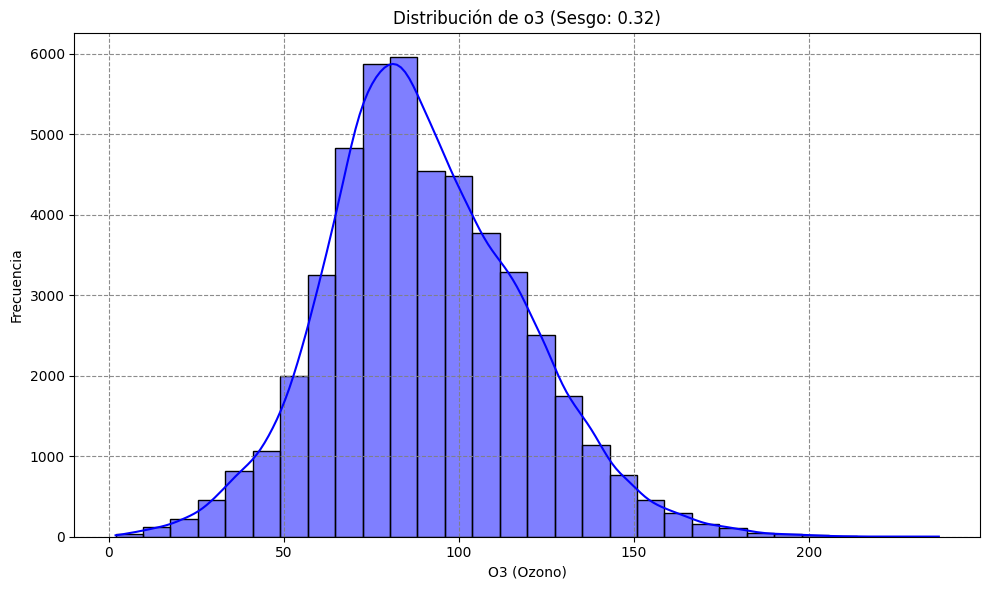

np.float64(0.32377445905942354)

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ica, x="O3", bins=30, kde=True, color="blue")
plt.title(f"Distribución de o3 (Sesgo: {df_ica['O3'].skew():.2f})")
plt.xlabel("O3 (Ozono)")
plt.ylabel("Frecuencia")
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

o3_skewness = df_ica['O3'].skew()
o3_skewness

La distribución de los valores de ozono es positiva, pero cercana a 0. Esto implica una ligera asimetría a la derecha, pero estando muy cerca de ser simétrica. Este contaminante tiene una ligera inclinación a valores más altos, aunque no tiene tantos valores extremos como el ICA. Los valores más habituales están entre 80-100 y 60-80. La media y la mediana son muy parecidas, por lo que ambas pueden considerarse mediciones centrales del ozono. 

In [72]:
df_ica['O3'].describe().to_frame().T

count       mean        std  min   25%   50%    75%    max
O3  47990.0  90.213638  28.185425  2.0  71.0  88.0  108.0  237.0

In [73]:
print(f'La media del ozono entre 2020 y 2025 es{df_ica['O3'].mean(): .2f}')
print(f'El valor de ozono más frecuente entre 2020 y 2025 fue {df_ica['O3'].mode()[0]}')
print(f'El valor máximo del ozono entre 2020 y 2025 fue {df_ica['O3'].max()}')
print(f'El valor mínimo del ozono entre 2020 y 2025 fue {df_ica['O3'].min()}')
print(f'La desviación estándar del ozono entre 2020 y 2025 es{df_ica['O3'].std(): .3f}')
print(f'La varianza del ozono es{df_ica['O3'].var(): .2f}')
print(f'El coeficiente de variación del ozono es{df_ica['O3'].std()/np.abs(df_ica['O3'].mean()): .2f}')

La media del ozono entre 2020 y 2025 es 90.21
El valor de ozono más frecuente entre 2020 y 2025 fue 86.0
El valor máximo del ozono entre 2020 y 2025 fue 237.0
El valor mínimo del ozono entre 2020 y 2025 fue 2.0
La desviación estándar del ozono entre 2020 y 2025 es 28.185
La varianza del ozono es 794.42
El coeficiente de variación del ozono es 0.31


In [74]:
min_O3 = df_ica['O3'].min()
min_O3

np.float64(2.0)

In [75]:
max_O3 = df_ica['O3'].max()
max_O3

np.float64(237.0)

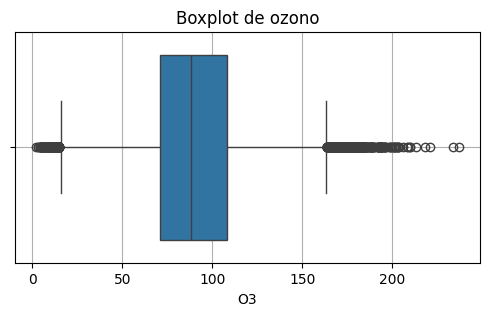

In [76]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['O3'])
plt.grid(True)
plt.title('Boxplot de ozono')
plt.show()

In [77]:
Q1_O3 = df_ica['O3'].quantile(0.25)
Q3_O3 = df_ica['O3'].quantile(0.75)
IQR_O3 = Q3_O3 - Q1_O3

upper_limit_O3 = Q3_O3 + 1.5 * IQR_O3
print(f"O3 que se considera outlier: {upper_limit_O3} o más")

outliers_O3 = df_ica[df_ica['O3'] > upper_limit_O3]
print(f"Cantidad de outliers: {len(outliers_O3)}")

O3 que se considera outlier: 163.5 o más
Cantidad de outliers: 467


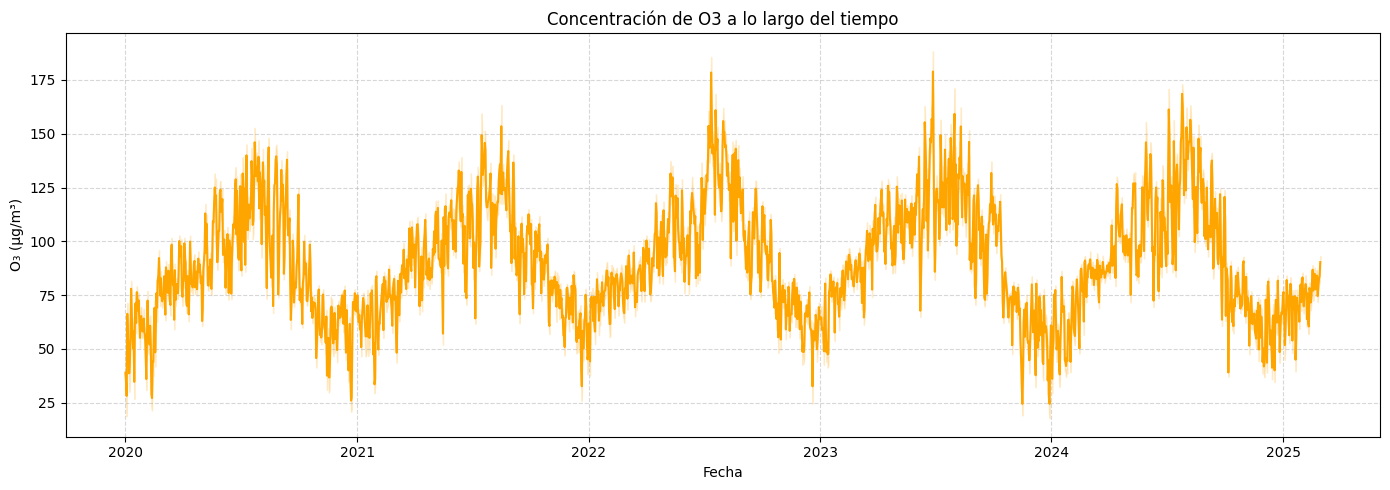

In [78]:
df_ica["fecha"] = pd.to_datetime(df_ica["fecha"])

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_ica, x="fecha", y="O3", color='orange')
plt.title("Concentración de O3 a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("O₃ (µg/m³)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observamos una estacionalidad marcada, con patrones similares en todos los años, salvo a inicios de 2020, por lo que he comentado anteriormente. Aquí además validamos la explicación de que el O3 aumenta con las temperaturas y la radicación solar, siendo mucho más alto en verano y después en primavera.

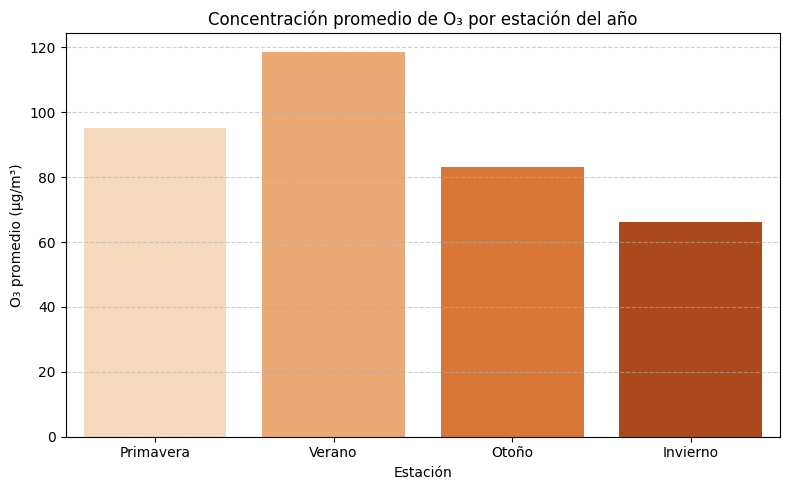

In [79]:
o3_estacion = df_ica.groupby("estacion")["O3"].mean().reset_index()

orden = ["Primavera", "Verano", "Otoño", "Invierno"]
o3_estacion["estacion"] = pd.Categorical(o3_estacion["estacion"], categories=orden, ordered=True)
o3_estacion = o3_estacion.sort_values("estacion")

plt.figure(figsize=(8, 5))
sns.barplot(data=o3_estacion, x="estacion", y="O3", palette="Oranges")
plt.title("Concentración promedio de O₃ por estación del año")
plt.xlabel("Estación")
plt.ylabel("O₃ promedio (µg/m³)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

OXIDOS DE NITRÓGENO (NOx, NO y NO2): son compuestos químicos procedentes de emisiones del tráfico rodado (vehículos), calefacciones y procesos industriales. Hay concentraciones altas cuando: hay mucho tráfico (especialmente en horas punta), el clima es frío y hay poco viento y en episodios de inversión térmica (el aire frío queda atrapado cerca del suelo).

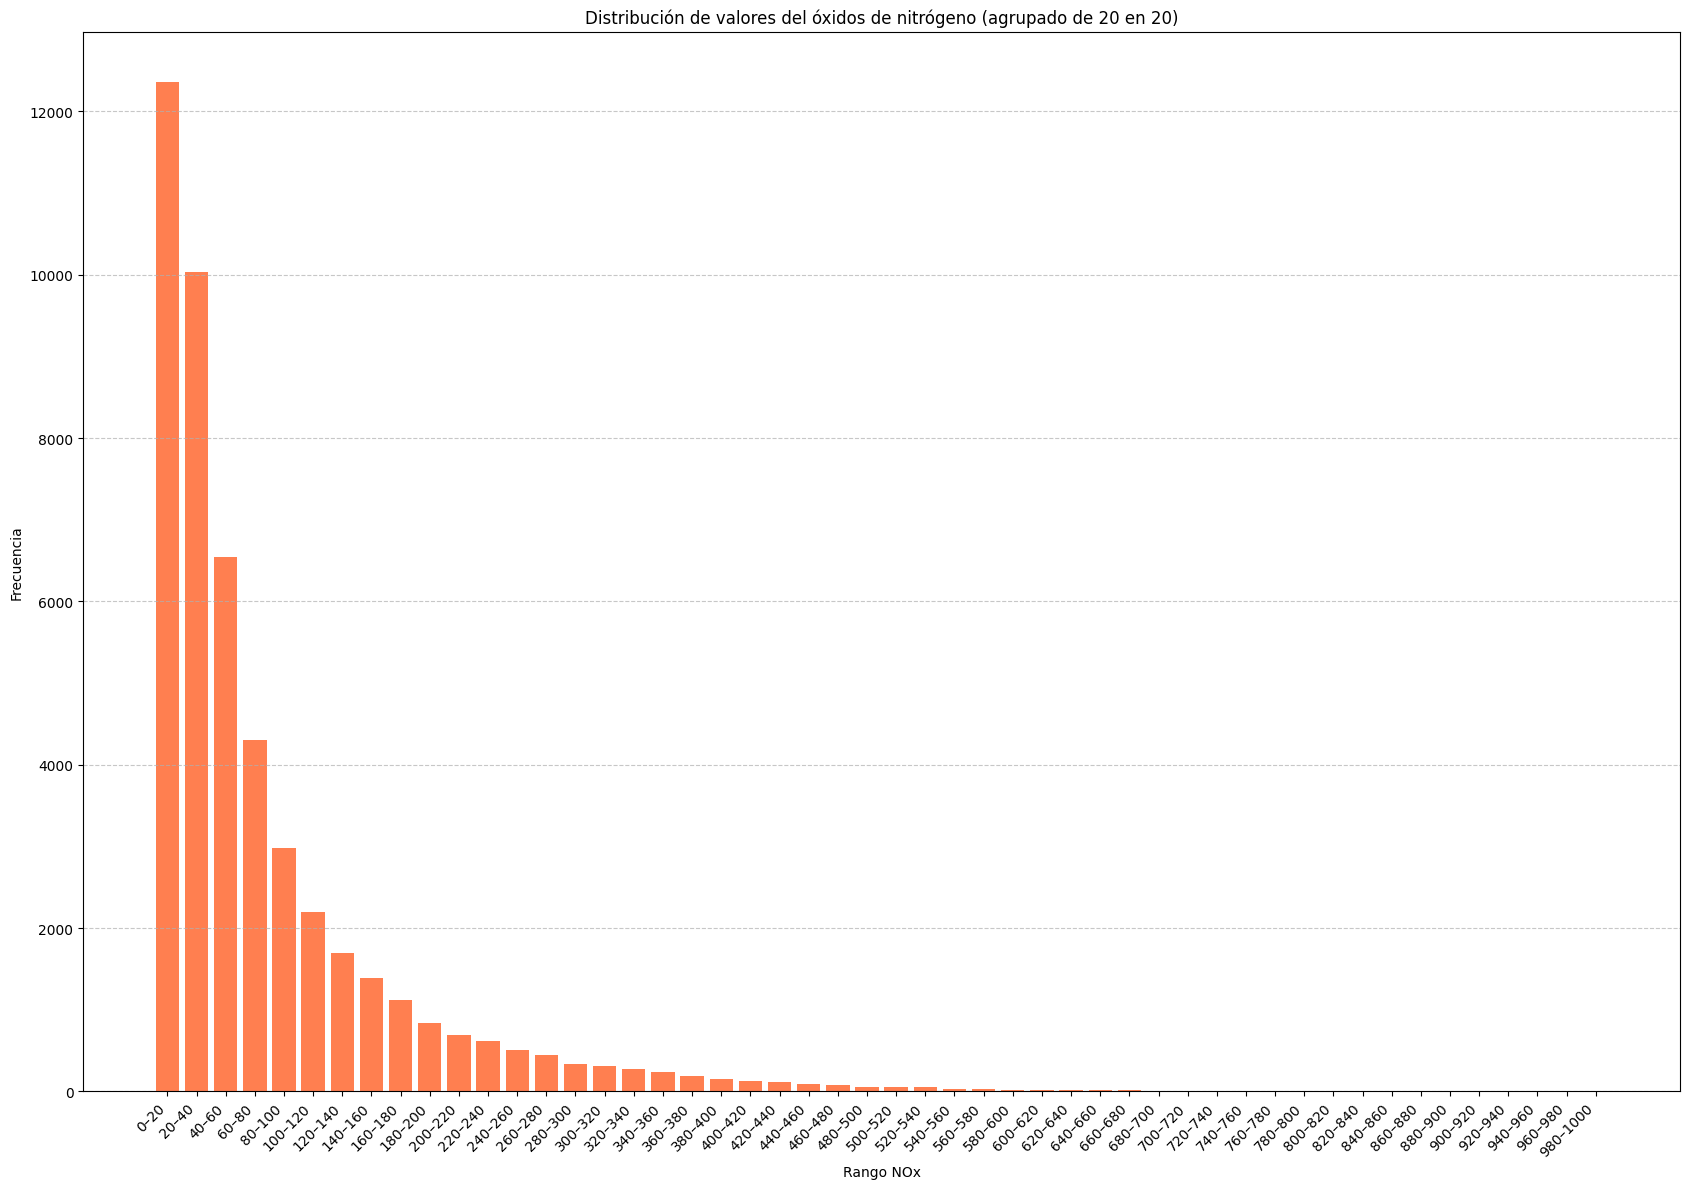

NOx    5.0    6.0    7.0    4.0    8.0    9.0    10.0   12.0   16.0   19.0   \
count   1048    990    889    859    717    706    668    649    641    636   

NOx    ...  629.0  592.0  594.0  595.0  523.0  731.0  601.0  794.0  514.0  \
count  ...      1      1      1      1      1      1      1      1      1   

NOx    495.0  
count      1  

[1 rows x 655 columns]

In [80]:
NOx_counts = df_ica["NOx"].value_counts(ascending=False)

bins = pd.cut(df_ica["NOx"], bins=range(0, int(df_ica["NOx"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del óxidos de nitrógeno (agrupado de 20 en 20)")
plt.xlabel("Rango NOx")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NOx_counts.to_frame().T

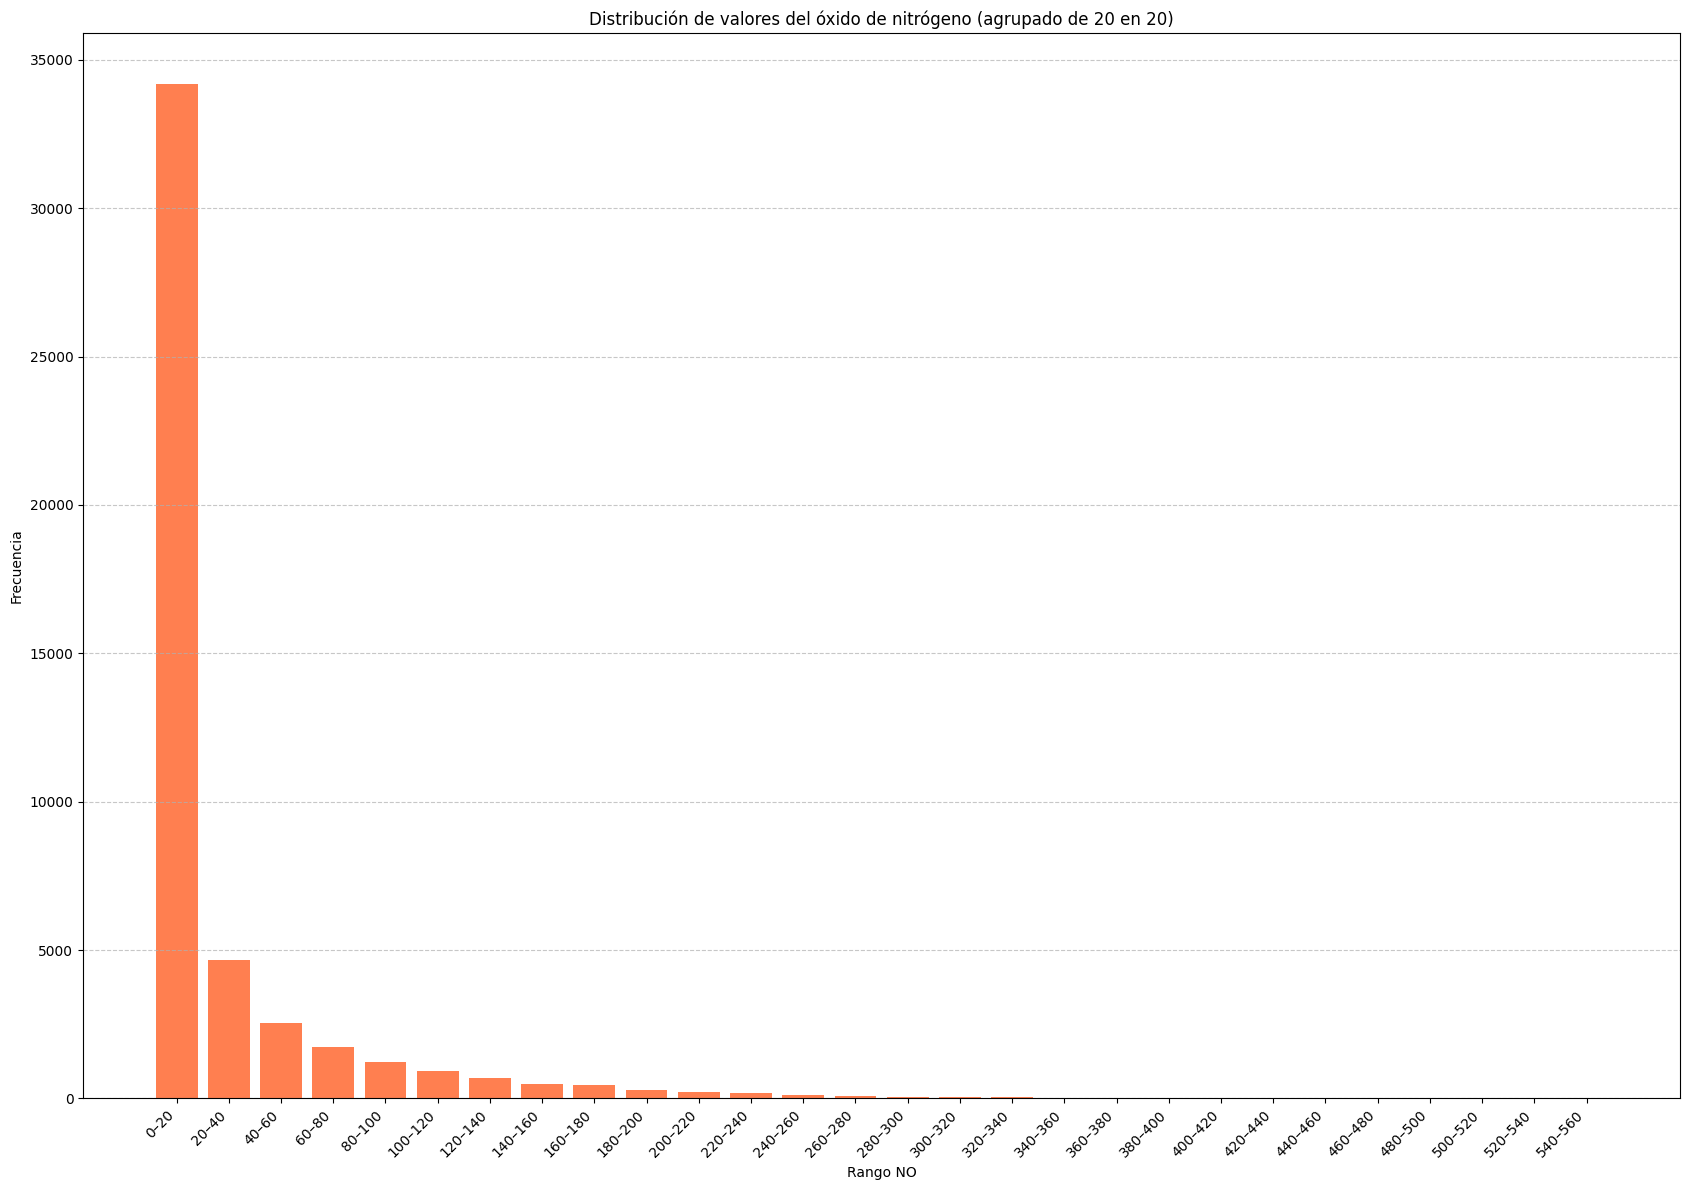

NO     1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0    10.0   \
count   6615   5201   4035   3047   2452   1998   1605   1394   1127   1001   

NO     ...  288.0  242.0  404.0  446.0  313.0  300.0  349.0  307.0  406.0  \
count  ...      1      1      1      1      1      1      1      1      1   

NO     434.0  
count      1  

[1 rows x 380 columns]

In [81]:
NO_counts = df_ica["NO"].value_counts(ascending=False)

bins = pd.cut(df_ica["NO"], bins=range(0, int(df_ica["NO"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del óxido de nitrógeno (agrupado de 20 en 20)")
plt.xlabel("Rango NO")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NO_counts.to_frame().T

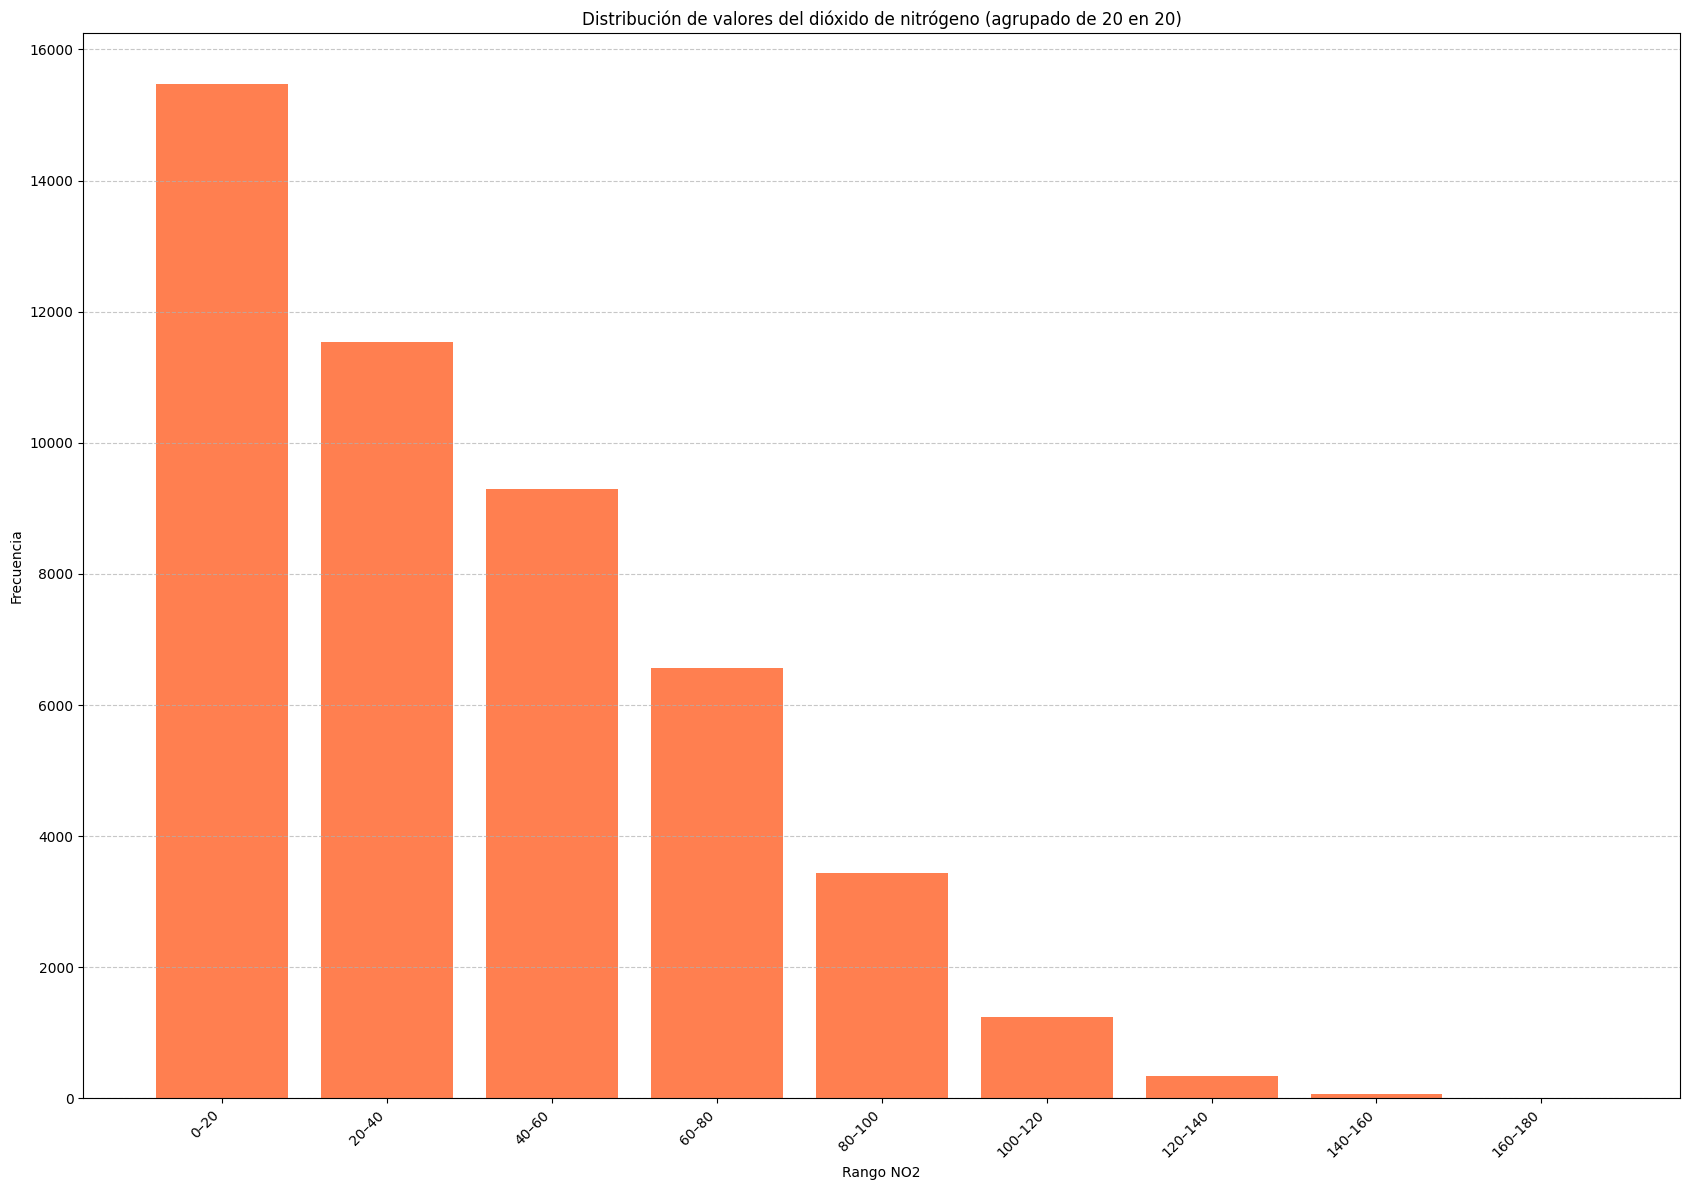

NO2    3.0    4.0    5.0    2.0    7.0    6.0    13.0   8.0    10.0   18.0   \
count   1105   1081    969    915    806    789    772    760    753    740   

NO2    ...  172.0  171.0  161.0  158.0  160.0  169.0  163.0  170.0  159.0  \
count  ...      1      1      1      1      1      1      1      1      1   

NO2    155.0  
count      1  

[1 rows x 165 columns]

In [82]:
NO2_counts = df_ica["NO2"].value_counts(ascending=False)

bins = pd.cut(df_ica["NO2"], bins=range(0, int(df_ica["NO2"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del dióxido de nitrógeno (agrupado de 20 en 20)")
plt.xlabel("Rango NO2")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NO2_counts.to_frame().T

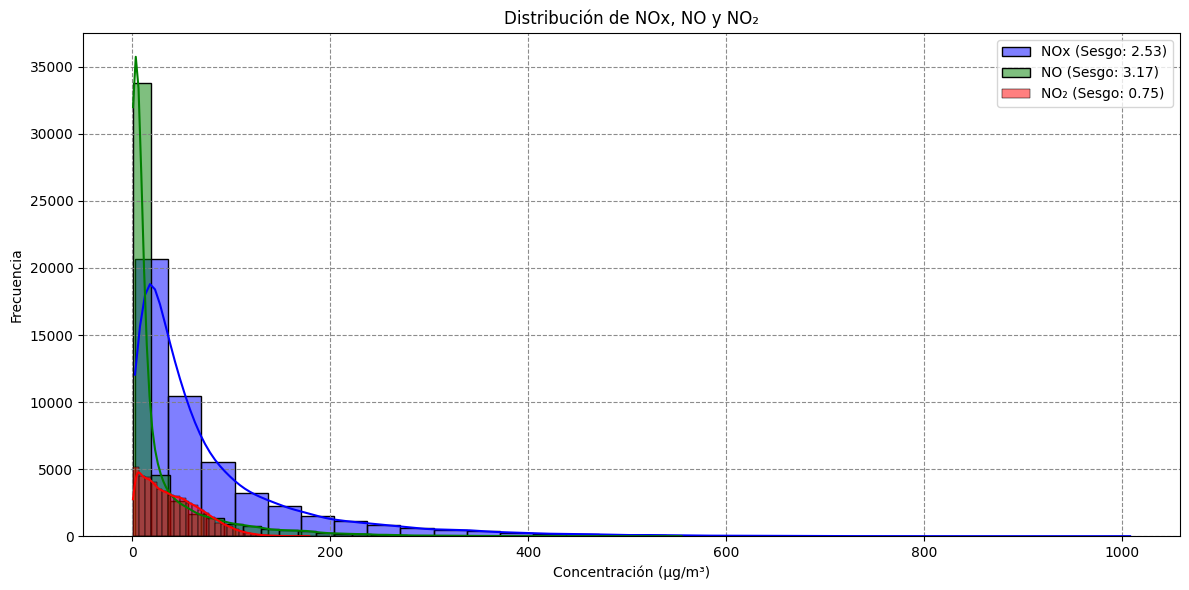

In [83]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df_ica, x="NOx", bins=30, kde=True, color="blue", label=f"NOx (Sesgo: {df_ica['NOx'].skew():.2f})", alpha=0.5)
sns.histplot(data=df_ica, x="NO", bins=30, kde=True, color="green", label=f"NO (Sesgo: {df_ica['NO'].skew():.2f})", alpha=0.5)
sns.histplot(data=df_ica, x="NO2", bins=30, kde=True, color="red", label=f"NO₂ (Sesgo: {df_ica['NO2'].skew():.2f})", alpha=0.5)

plt.title("Distribución de NOx, NO y NO₂")
plt.xlabel("Concentración (µg/m³)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

NOx y NO tienen un skewness de más de 2.5, por lo que es una distribución muy asimétrica y positiva a la derecha, con largas colas en ambos casos. El promedio se concentra en valores muy bajos, entre 0 y 20, aunque presenta valores extremos también. La media es mucho mayor a la mediana, por lo que el valor central de cada uno es difuso.

Aún siendo del mismo grupo, el NO2 es muy diferente, siendo las distribución bastante más simétrica, con un skewness de 0.75. También tiende a valores bajos, pero todos los rangos están más equilibrados y tiene menos outliers. Su media y mediana son mucho más cercanas (solo 5 puntos de diferencia)

In [84]:
df_ica[['NOx', 'NO', 'NO2']].describe().T

count       mean        std  min   25%   50%   75%     max
NOx  47990.0  78.374453  93.281934  3.0  20.0  45.0  99.0  1008.0
NO   47990.0  26.833132  47.630548  1.0   3.0   7.0  26.0   555.0
NO2  47990.0  40.094374  29.209658  1.0  16.0  35.0  60.0   179.0

In [85]:
print(f'La media del óxido de nitrógeno entre 2020 y 2025 es{df_ica['NO'].mean(): .2f}')
print(f'El valor de óxido de nitrógeno más frecuente entre 2020 y 2025 fue {df_ica['NO'].mode()[0]}')
print(f'El valor máximo del óxido de nitrógeno entre 2020 y 2025 fue {df_ica['NO'].max()}')
print(f'El valor mínimo del óxido de nitrógeno entre 2020 y 2025 fue {df_ica['NO'].min()}')
print(f'La desviación estándar del óxido de nitrógeno entre 2020 y 2025 es{df_ica['NO'].std(): .3f}')
print(f'La varianza del óxido de nitrógeno es{df_ica['NO'].var(): .2f}')
print(f'El coeficiente de variación del óxido de nitrógeno es{df_ica['NO'].std()/np.abs(df_ica['NO'].mean()): .2f}')

La media del óxido de nitrógeno entre 2020 y 2025 es 26.83
El valor de óxido de nitrógeno más frecuente entre 2020 y 2025 fue 1.0
El valor máximo del óxido de nitrógeno entre 2020 y 2025 fue 555.0
El valor mínimo del óxido de nitrógeno entre 2020 y 2025 fue 1.0
La desviación estándar del óxido de nitrógeno entre 2020 y 2025 es 47.631
La varianza del óxido de nitrógeno es 2268.67
El coeficiente de variación del óxido de nitrógeno es 1.78


In [86]:
print(f'La media del dióxido de nitrógeno entre 2020 y 2025 es{df_ica['NO2'].mean(): .2f}')
print(f'El valor de dióxido de nitrógeno más frecuente entre 2020 y 2025 fue {df_ica['NO2'].mode()[0]}')
print(f'El valor máximo del dióxido de nitrógeno entre 2020 y 2025 fue {df_ica['NO2'].max()}')
print(f'El valor mínimo del dióxido de nitrógeno entre 2020 y 2025 fue {df_ica['NO2'].min()}')
print(f'La desviación estándar del dióxido de nitrógeno entre 2020 y 2025 es{df_ica['NO2'].std(): .3f}')
print(f'La varianza del dióxido de nitrógeno es{df_ica['NO2'].var(): .2f}')
print(f'El coeficiente de variación del dióxido de nitrógeno es{df_ica['NO2'].std()/np.abs(df_ica['NO2'].mean()): .2f}')

La media del dióxido de nitrógeno entre 2020 y 2025 es 40.09
El valor de dióxido de nitrógeno más frecuente entre 2020 y 2025 fue 3.0
El valor máximo del dióxido de nitrógeno entre 2020 y 2025 fue 179.0
El valor mínimo del dióxido de nitrógeno entre 2020 y 2025 fue 1.0
La desviación estándar del dióxido de nitrógeno entre 2020 y 2025 es 29.210
La varianza del dióxido de nitrógeno es 853.20
El coeficiente de variación del dióxido de nitrógeno es 0.73


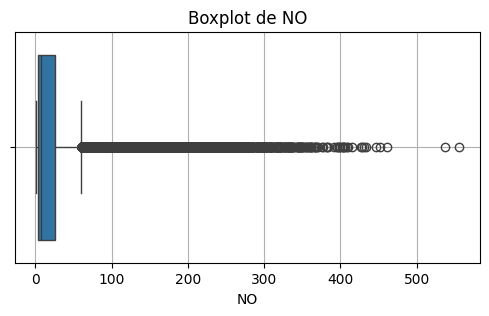

In [87]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['NO'])
plt.grid(True)
plt.title('Boxplot de NO')
plt.show()

In [88]:
Q1_NO = df_ica['NO'].quantile(0.25)
Q3_NO = df_ica['NO'].quantile(0.75)
IQR_NO = Q3_NO - Q1_NO

upper_limit_NO = Q3_NO + 1.5 * IQR_NO
print(f"NO que se considera outlier: {upper_limit_NO} o más")

outliers_NO = df_ica[df_ica['NO'] > upper_limit_NO]
print(f"Cantidad de outliers: {len(outliers_NO)}")

NO que se considera outlier: 60.5 o más
Cantidad de outliers: 6583


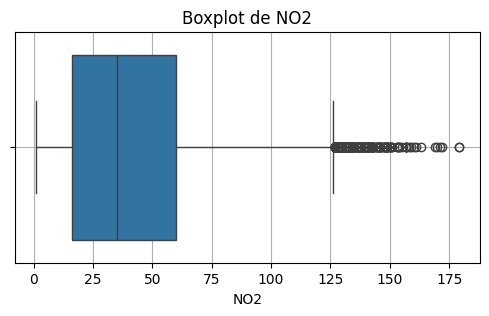

In [89]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['NO2'])
plt.grid(True)
plt.title('Boxplot de NO2')
plt.show()

In [90]:
Q1_NO2 = df_ica['NO2'].quantile(0.25)
Q3_NO2 = df_ica['NO2'].quantile(0.75)
IQR_NO2 = Q3_NO2 - Q1_NO2

upper_limit_NO2 = Q3_NO2 + 1.5 * IQR_NO2
print(f"NO2 que se considera outlier: {upper_limit_NO2} o más")

outliers_NO2 = df_ica[df_ica['NO2'] > upper_limit_NO2]
print(f"Cantidad de outliers: {len(outliers_NO2)}")

NO2 que se considera outlier: 126.0 o más
Cantidad de outliers: 262


In [91]:
Q1_NOx = df_ica['NOx'].quantile(0.25)
Q3_NOx = df_ica['NOx'].quantile(0.75)
IQR_NOx = Q3_NOx - Q1_NOx

upper_limit_NOx = Q3_NOx + 1.5 * IQR_NOx
print(f"NOx que se considera outlier: {upper_limit_NOx} o más")

outliers_NOx = df_ica[df_ica['NOx'] > upper_limit_NOx]
print(f"Cantidad de outliers: {len(outliers_NOx)}")

NOx que se considera outlier: 217.5 o más
Cantidad de outliers: 3911


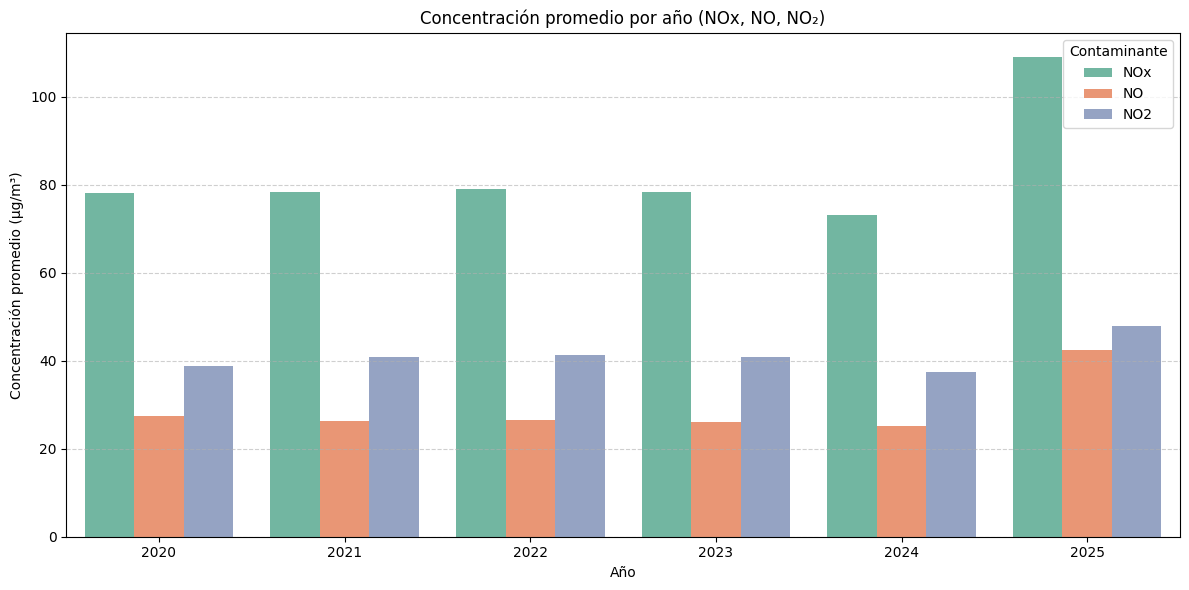

In [92]:
df_ica["año"] = df_ica["fecha"].dt.year

df_melt_año = df_ica[["año", "NOx", "NO", "NO2"]].melt(id_vars="año", var_name="Contaminante", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt_año, x="año", y="Valor", hue="Contaminante", ci=None, palette="Set2")
plt.title("Concentración promedio por año (NOx, NO, NO₂)")
plt.xlabel("Año")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Lo primero es observar que el año 2025 sólo tiene datos de los dos primeros meses, por lo que su análisis no es necesario ni válido. El resto de años muestra valores muy similares para todos los contaminantes, notandose un ligero descenso en todos en el año 2024. Cabe destacar en 2020 (año de covid) también un ligero descenso en el NO2.

En cuanto a las estaciones, a la inversa que el O3 como ya hemos visto, sube la concentración en otoño y, sobre todo, en invierno. Es especialmente claro para el NO y NOx. En verano es cuando menos concentraciones hay de oxidos de nitrógeno. Esto valida lo analizado anteriormente, ya que con más humedad, frío y, en menor medida precipitaciones, tienden a subir estas concentraciones de contaminantes NO

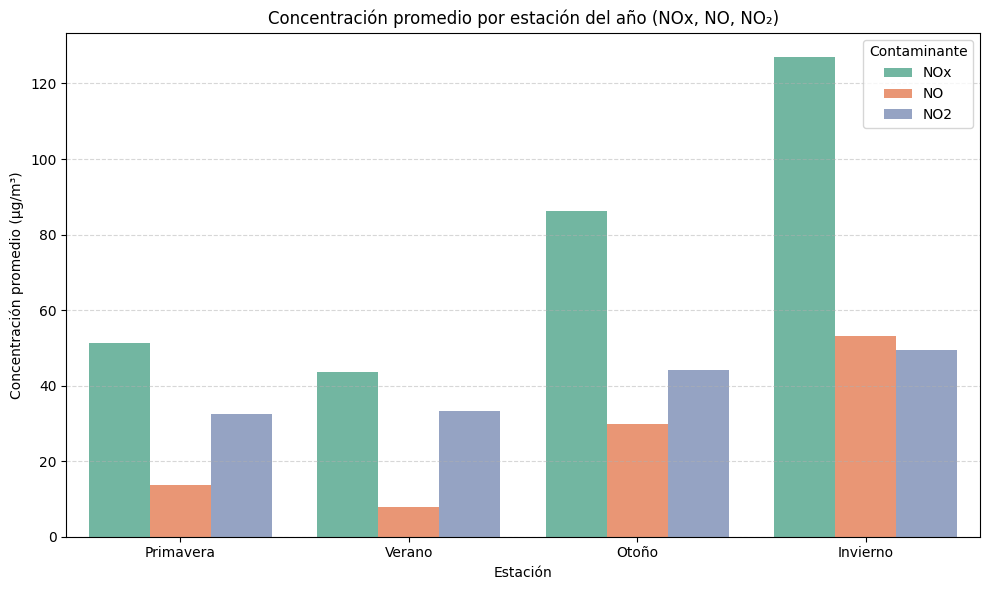

In [93]:
df_melt_est = df_ica[["estacion", "NOx", "NO", "NO2"]].melt(id_vars="estacion", var_name="Contaminante", value_name="Valor")

orden_estaciones = ["Primavera", "Verano", "Otoño", "Invierno"]
df_melt_est["estacion"] = pd.Categorical(df_melt_est["estacion"], categories=orden_estaciones, ordered=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt_est, x="estacion", y="Valor", hue="Contaminante", palette="Set2", ci=None)
plt.title("Concentración promedio por estación del año (NOx, NO, NO₂)")
plt.xlabel("Estación")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

MATERIAL PARTICULADO (PM10 y PM2.5) de tamaño inferior a 10 microgramos y 2,5 microgramos: es el material particulado originado a partir del tráfico (frenos, neumáticos), calefacción, quemas de biomasa, polvo, obras, procesos de la industria, etc. Hay concentración alta cuando: se presenta un clima seco y sin lluvia (no hay limpieza natural), se produce inversión térmica o falta de viento (se acumulan cerca del suelo)y en invierno (más uso de calefacciones). Algo muy importante también es la calima (presencia de polvo en suspensión en el aire, especialmente de origen sahariano), ya que el contaminante que más se incrementa es PM10 (particulas gruesas). El polvo mineral en suspensión eleva drásticamente sus concentraciones durante episodios de calima.

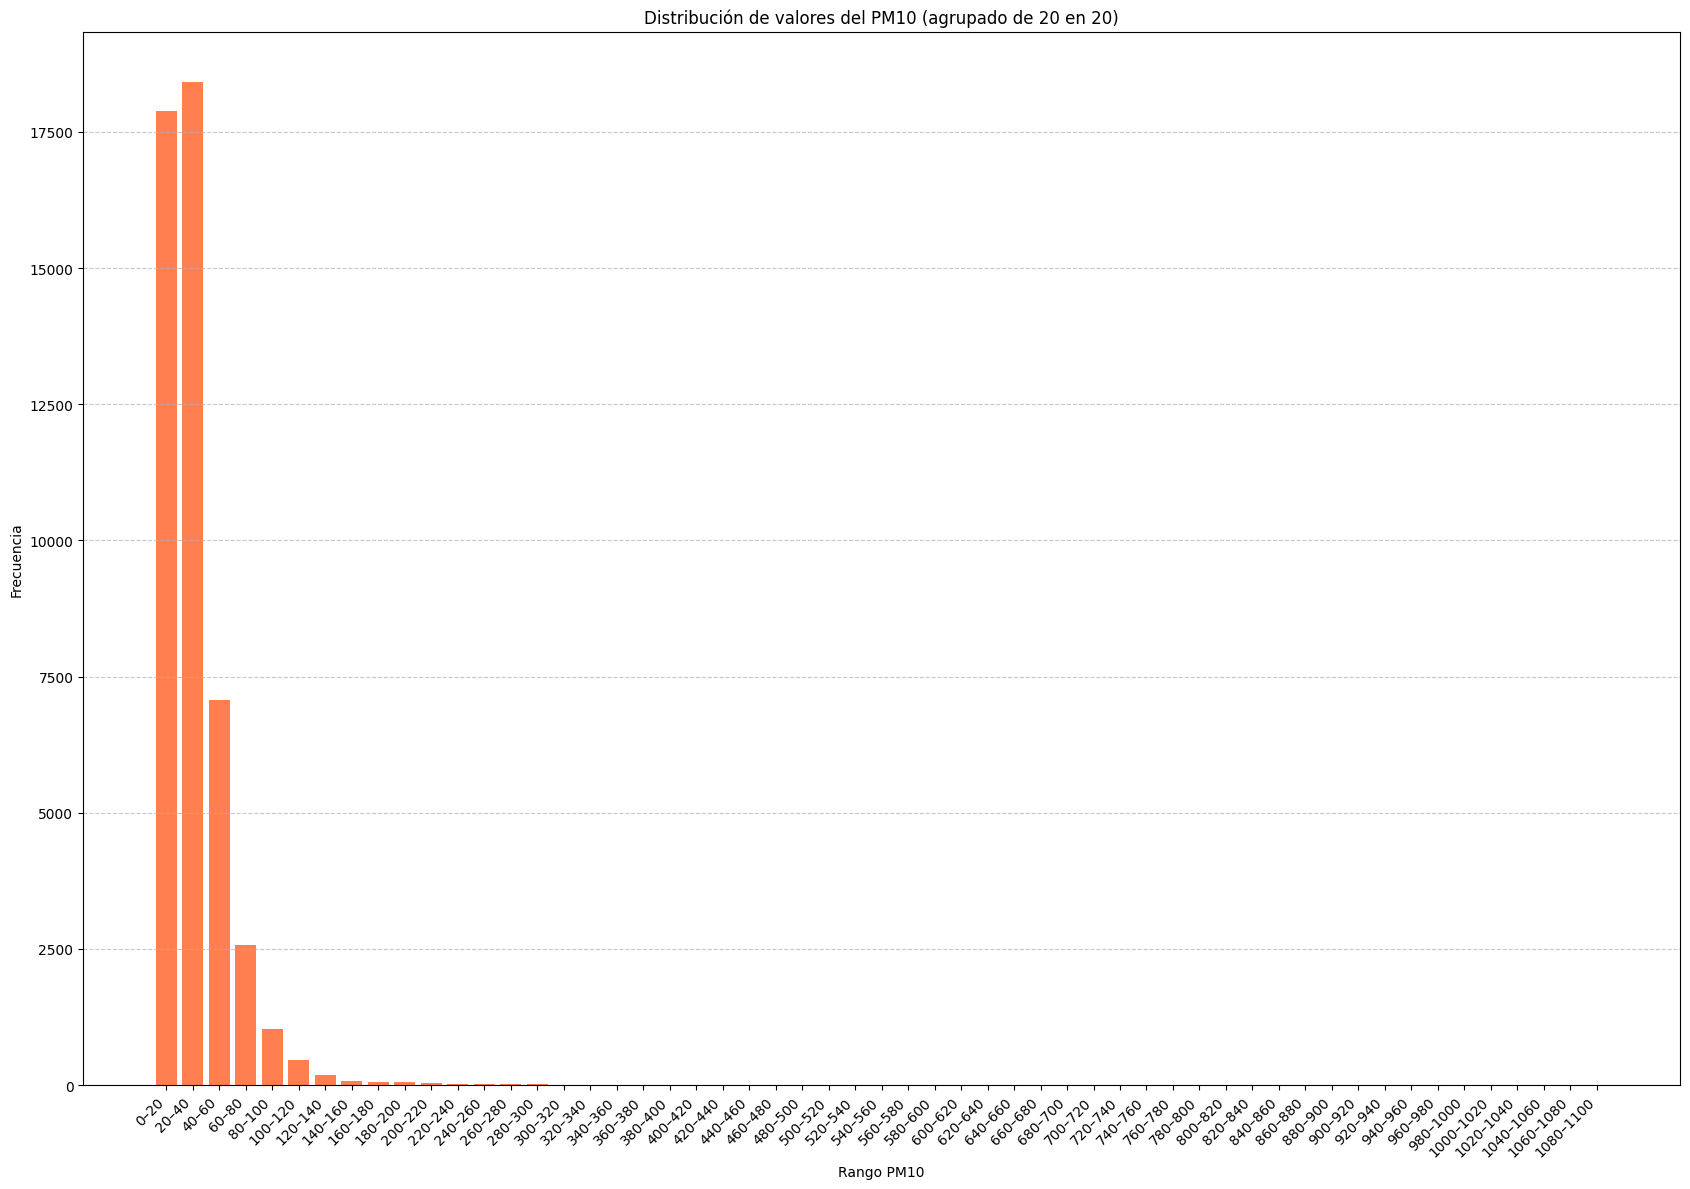

PM10   18.0   17.0   16.0   15.0   14.0   12.0   19.0   22.0   20.0   23.0   \
count   1435   1419   1403   1391   1360   1346   1316   1290   1268   1250   

PM10   ...  329.0  680.0  244.0  429.0  269.0  307.0  425.0  279.0  207.0  \
count  ...      1      1      1      1      1      1      1      1      1   

PM10   200.0  
count      1  

[1 rows x 292 columns]

In [94]:
PM10_counts = df_ica["PM10"].value_counts(ascending=False)

bins = pd.cut(df_ica["PM10"], bins=range(0, int(df_ica["PM10"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del PM10 (agrupado de 20 en 20)")
plt.xlabel("Rango PM10")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

PM10_counts.to_frame().T

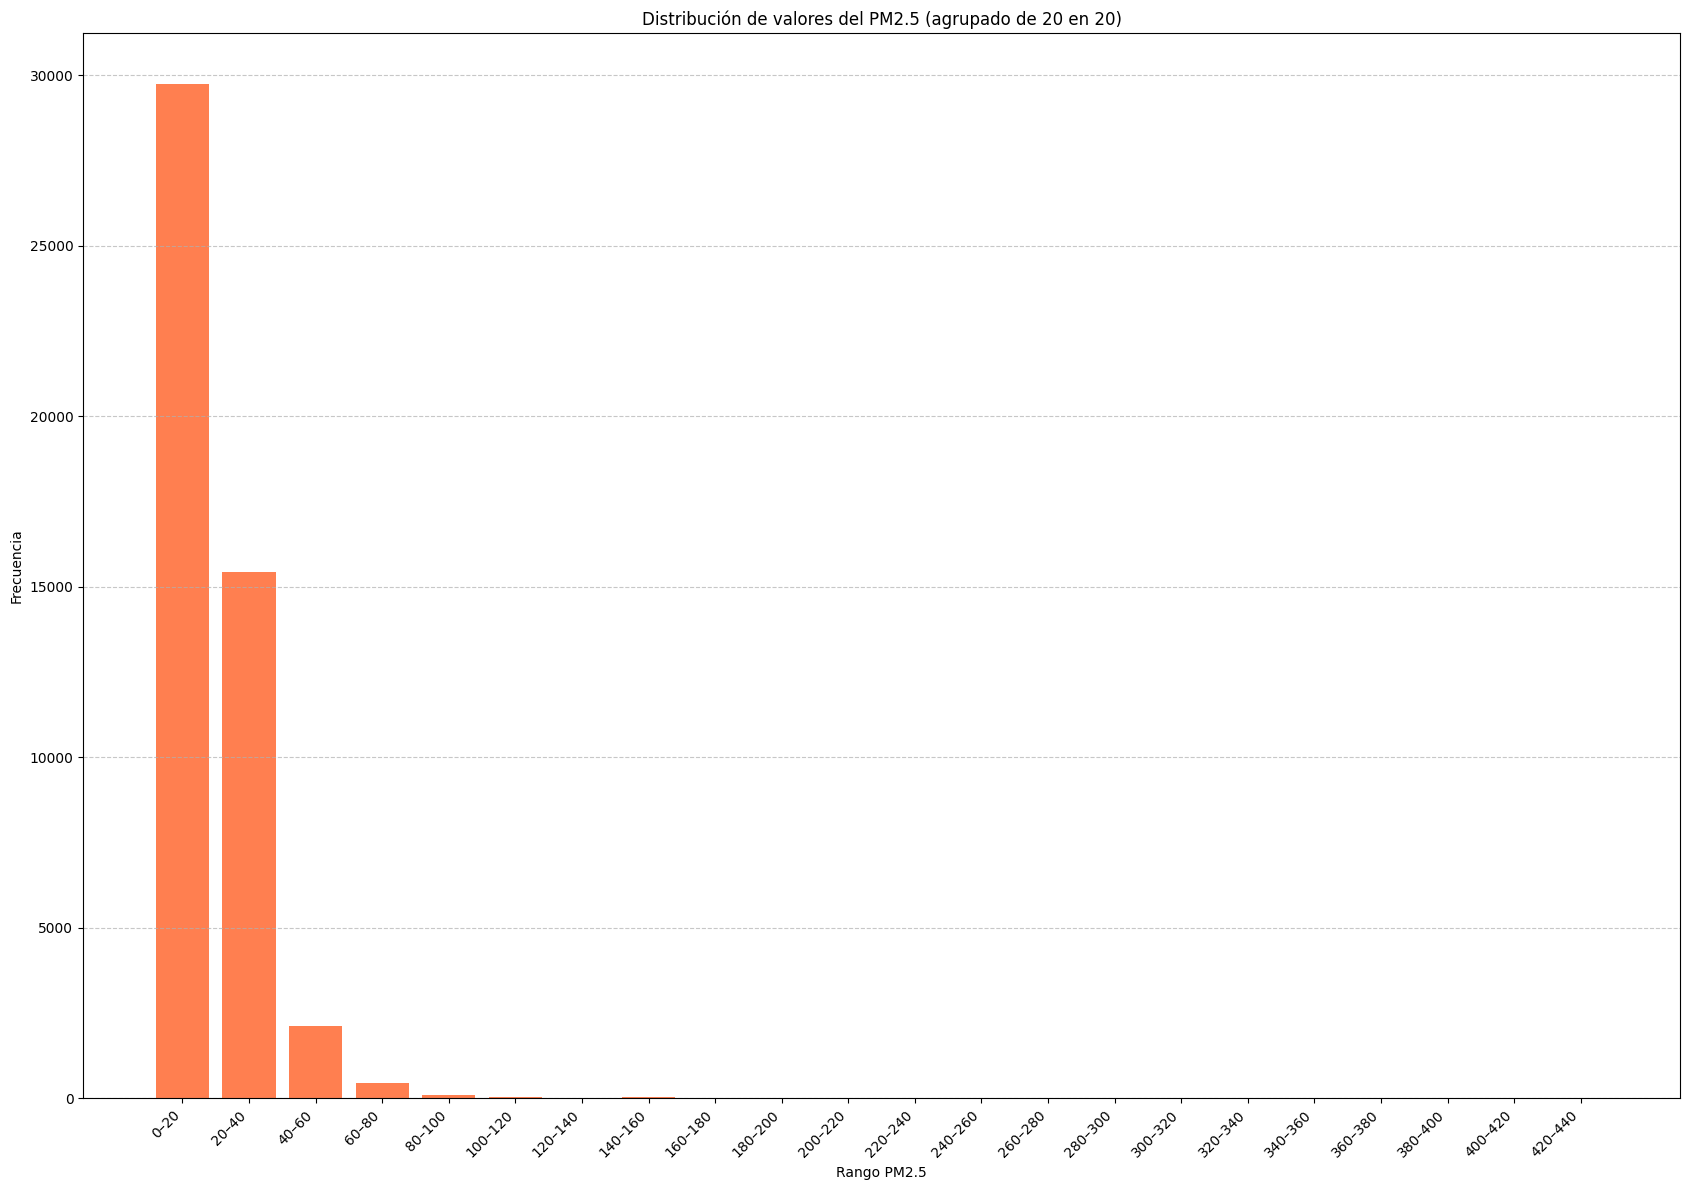

PM2.5  13.0   14.0   11.0   15.0   9.0    10.0   17.0   16.0   12.0   19.0   \
count   2295   2215   2151   2080   2079   2077   2031   2019   2011   1822   

PM2.5  ...  153.0  129.0  132.0  160.0  131.0  99.0   119.0  108.0  97.0   \
count  ...      1      1      1      1      1      1      1      1      1   

PM2.5  155.0  
count      1  

[1 rows x 138 columns]

In [95]:
PM25_counts = df_ica["PM2.5"].value_counts(ascending=False)

bins = pd.cut(df_ica["PM2.5"], bins=range(0, int(df_ica["PM2.5"].max()) + 10, 20))
ica_counts = bins.value_counts().sort_index()

etiquetas = [f"{int(i.left)}–{int(i.right)}" for i in ica_counts.index]

plt.figure(figsize=(17, 12))
plt.bar(etiquetas, ica_counts, color='coral')
plt.title("Distribución de valores del PM2.5 (agrupado de 20 en 20)")
plt.xlabel("Rango PM2.5")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

PM25_counts.to_frame().T

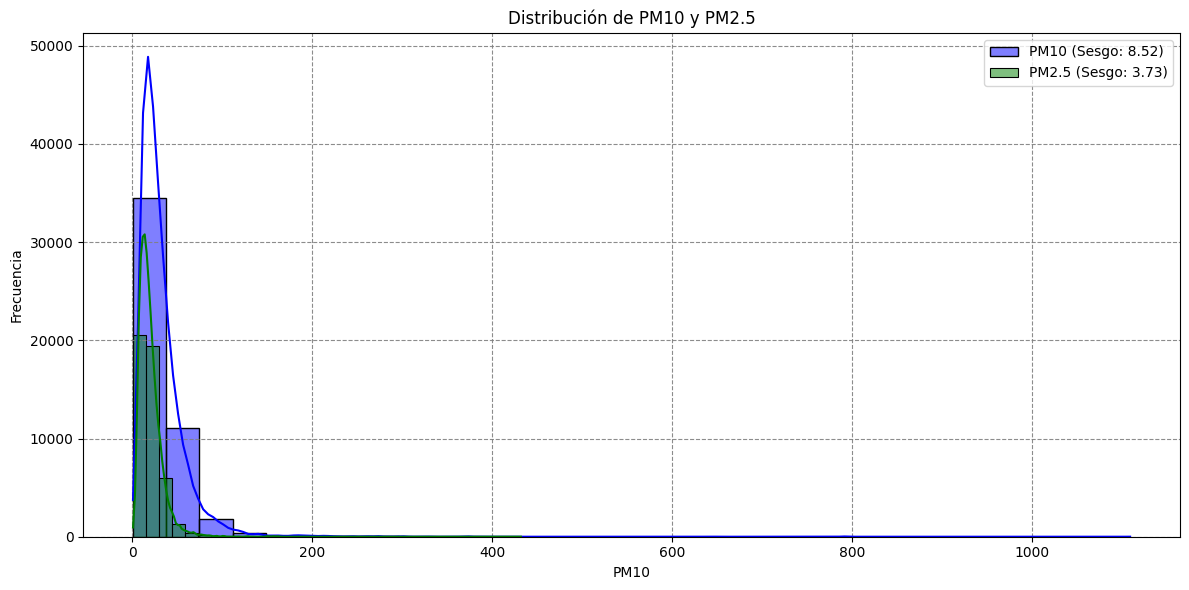

In [96]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df_ica, x="PM10", bins=30, kde=True, color="blue", label=f"PM10 (Sesgo: {df_ica['PM10'].skew():.2f})", alpha=0.5)
sns.histplot(data=df_ica, x="PM2.5", bins=30, kde=True, color="green", label=f"PM2.5 (Sesgo: {df_ica['PM2.5'].skew():.2f})", alpha=0.5)

plt.title("Distribución de PM10 y PM2.5")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

PM10 y PM2.5 tienen un skewness de más de 3, por lo que es una distribución muy asimétrica y positiva a la derecha, con largas colas en ambos casos. El caso de PM10 es bastante extremo, con un skewness de 8,5, en gran parte debido a la concentración de valores bajos y tener outliers enormes. El caso de PM2.5 es similar, pero no tan exagerado. El promedio se concentra en valores muy bajos, entre 0-20 y 20-40 (moda 13 y 18), aunque presenta valores muy extremos también, con un máximo de 1109 de PM10. La media y la mediana, sin embargo, no son exageradamente diferentes, sino que son más bien parecidas

In [97]:
df_ica[['PM10', 'PM2.5']].describe().T

count       mean        std  min   25%   50%   75%     max
PM10   47990.0  32.436153  30.212391  1.0  16.0  26.0  40.0  1109.0
PM2.5  47990.0  20.100708  13.331899  1.0  12.0  17.0  25.0   432.0

In [98]:
print(f'La media del PM10 entre 2020 y 2025 es{df_ica['PM10'].mean(): .2f}')
print(f'El valor de PM10 más frecuente entre 2020 y 2025 fue {df_ica['PM10'].mode()[0]}')
print(f'El valor máximo del PM10 entre 2020 y 2025 fue {df_ica['PM10'].max()}')
print(f'El valor mínimo del PM10 entre 2020 y 2025 fue {df_ica['PM10'].min()}')
print(f'La desviación estándar del PM10 entre 2020 y 2025 es{df_ica['PM10'].std(): .3f}')
print(f'La varianza del PM10 es{df_ica['PM10'].var(): .2f}')
print(f'El coeficiente de variación del PM10 es{df_ica['PM10'].std()/np.abs(df_ica['PM10'].mean()): .2f}')

La media del PM10 entre 2020 y 2025 es 32.44
El valor de PM10 más frecuente entre 2020 y 2025 fue 18.0
El valor máximo del PM10 entre 2020 y 2025 fue 1109.0
El valor mínimo del PM10 entre 2020 y 2025 fue 1.0
La desviación estándar del PM10 entre 2020 y 2025 es 30.212
La varianza del PM10 es 912.79
El coeficiente de variación del PM10 es 0.93


In [99]:
print(f'La media del PM2.5 entre 2020 y 2025 es{df_ica['PM2.5'].mean(): .2f}')
print(f'El valor de PM2.5 más frecuente entre 2020 y 2025 fue {df_ica['PM2.5'].mode()[0]}')
print(f'El valor máximo del PM2.5 entre 2020 y 2025 fue {df_ica['PM2.5'].max()}')
print(f'El valor mínimo del PM2.5 entre 2020 y 2025 fue {df_ica['PM2.5'].min()}')
print(f'La desviación estándar del PM2.5 entre 2020 y 2025 es{df_ica['PM2.5'].std(): .3f}')
print(f'La varianza del PM2.5 es{df_ica['PM2.5'].var(): .2f}')
print(f'El coeficiente de variación del PM2.5 es{df_ica['PM2.5'].std()/np.abs(df_ica['PM2.5'].mean()): .2f}')

La media del PM2.5 entre 2020 y 2025 es 20.10
El valor de PM2.5 más frecuente entre 2020 y 2025 fue 13.0
El valor máximo del PM2.5 entre 2020 y 2025 fue 432.0
El valor mínimo del PM2.5 entre 2020 y 2025 fue 1.0
La desviación estándar del PM2.5 entre 2020 y 2025 es 13.332
La varianza del PM2.5 es 177.74
El coeficiente de variación del PM2.5 es 0.66


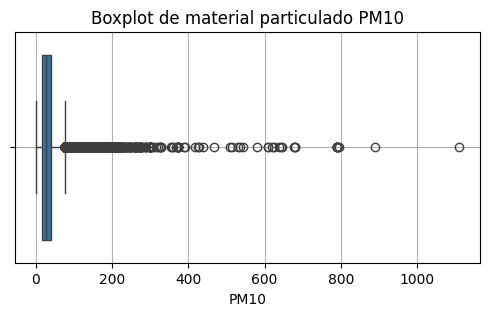

In [100]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['PM10'])
plt.grid(True)
plt.title('Boxplot de material particulado PM10')
plt.show()

In [101]:
Q1_PM10 = df_ica['PM10'].quantile(0.25)
Q3_PM10 = df_ica['PM10'].quantile(0.75)
IQR_PM10 = Q3_PM10 - Q1_PM10

upper_limit_PM10 = Q3_PM10 + 1.5 * IQR_PM10
print(f"PM10 que se considera outlier: {upper_limit_PM10} o más")

outliers_PM10 = df_ica[df_ica['PM10'] > upper_limit_PM10]
print(f"Cantidad de outliers: {len(outliers_PM10)}")

PM10 que se considera outlier: 76.0 o más
Cantidad de outliers: 2334


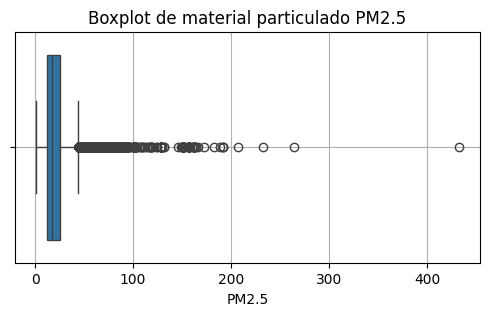

In [102]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['PM2.5'])
plt.grid(True)
plt.title('Boxplot de material particulado PM2.5')
plt.show()

In [103]:
Q1_PM25 = df_ica['PM2.5'].quantile(0.25)
Q3_PM25 = df_ica['PM2.5'].quantile(0.75)
IQR_PM25 = Q3_PM25 - Q1_PM25

upper_limit_PM25 = Q3_PM25 + 1.5 * IQR_PM25
print(f"PM2.5 que se considera outlier: {upper_limit_PM25} o más")

outliers_PM25 = df_ica[df_ica['PM2.5'] > upper_limit_PM25]
print(f"Cantidad de outliers: {len(outliers_PM25)}")

PM2.5 que se considera outlier: 44.5 o más
Cantidad de outliers: 2018


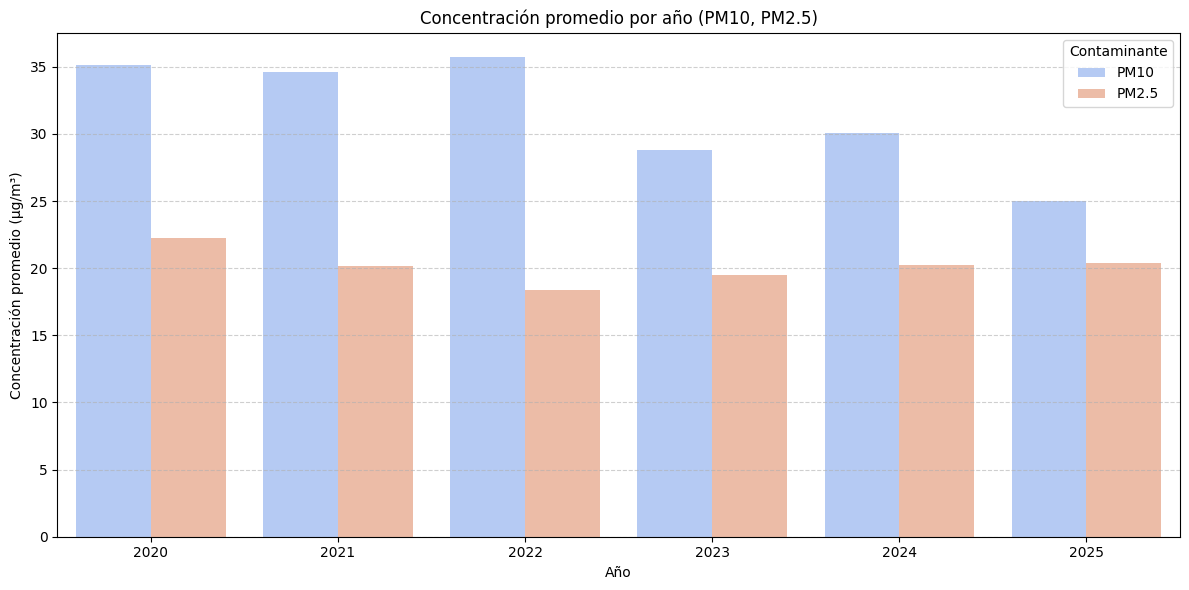

In [104]:
df_ica["año"] = df_ica["fecha"].dt.year

df_melt_año = df_ica[["año", "PM10", "PM2.5"]].melt(id_vars="año", var_name="Contaminante", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt_año, x="año", y="Valor", hue="Contaminante", ci=None, palette="coolwarm")
plt.title("Concentración promedio por año (PM10, PM2.5)")
plt.xlabel("Año")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Las concentraciones por años son más estables para el PM2.5 , que aunque va cambiando es más regular. Desde 2022 ha ido subiendo, mientras que el PM10 bajó drásticamente en 2023 y subió un poco en 2024.

Estos contaminantes tienen un componente estacionario menor, o más estable. El más bajo sería en primavera y el más alto: para PM10 en verano y para PM2.5 en invierno.

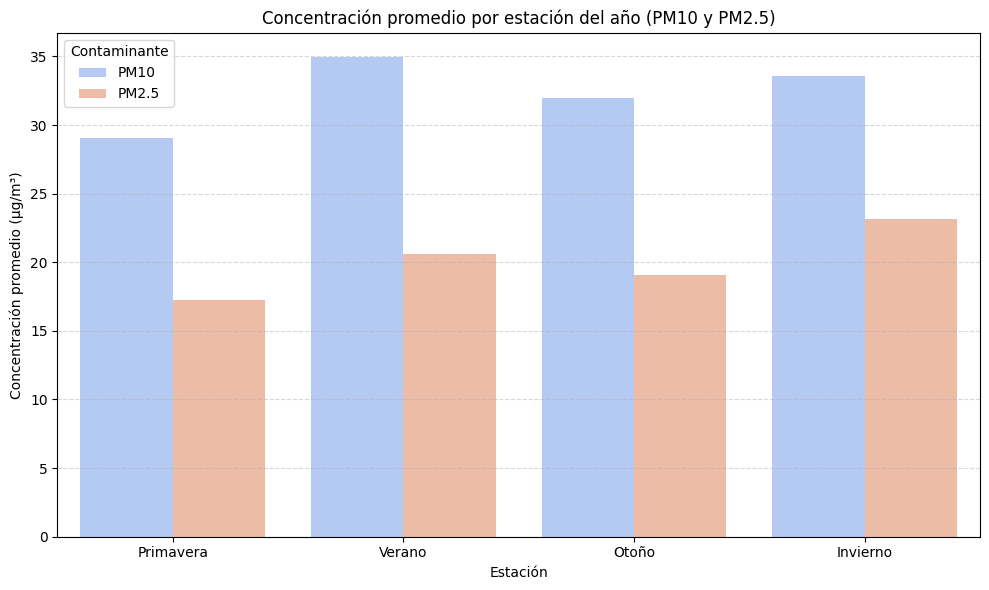

In [105]:
df_melt_pm = df_ica[["estacion", "PM10", "PM2.5"]].melt(id_vars="estacion", var_name="Contaminante", value_name="Valor")

# Ordenar estaciones
orden_estaciones = ["Primavera", "Verano", "Otoño", "Invierno"]
df_melt_pm["estacion"] = pd.Categorical(df_melt_pm["estacion"], categories=orden_estaciones, ordered=True)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt_pm, x="estacion", y="Valor", hue="Contaminante", palette="coolwarm", ci=None)
plt.title("Concentración promedio por estación del año (PM10 y PM2.5)")
plt.xlabel("Estación")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


DIOXIDO DE AZUFRE (SO2): Presenta su origen en procesos como la quema de carbón y fuelóleo o en la industria pesada. Hay alta concentración cuando: se presentan muchas zonas industriales activas y por el uso de combustibles fósiles sin quitar previamente el azufre.

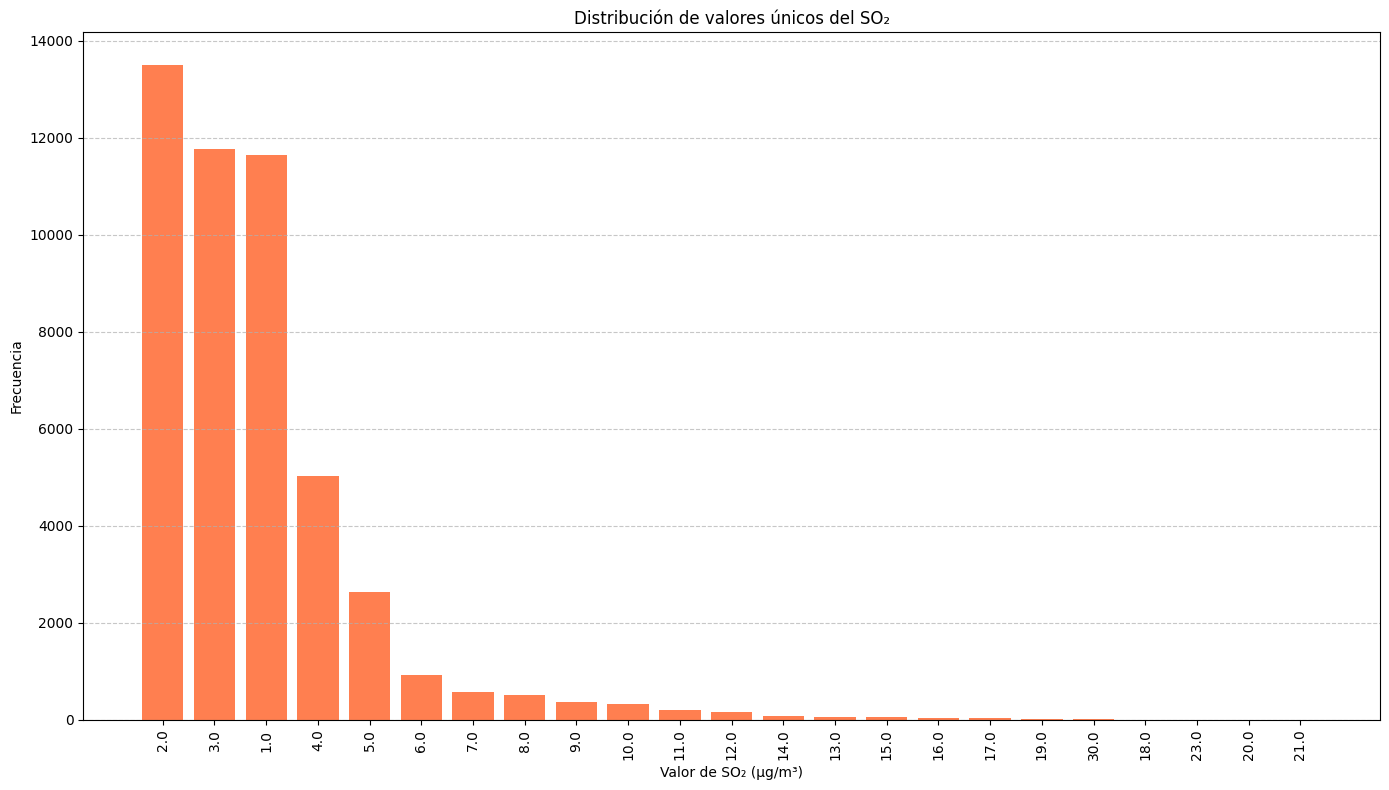

SO2     2.0    3.0    1.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  ...  \
count  13501  11771  11652  5020  2637   935   566   515   364   320  ...   

SO2    13.0  15.0  16.0  17.0  19.0  30.0  18.0  23.0  20.0  21.0  
count    65    52    47    43    24    23     3     2     2     1  

[1 rows x 23 columns]

In [106]:
SO2_counts = df_ica["SO2"].value_counts(ascending=False)

etiquetas = SO2_counts.index.astype(str)
valores = SO2_counts.values

plt.figure(figsize=(14, 8))
plt.bar(etiquetas, valores, color='coral')
plt.title("Distribución de valores únicos del SO₂")
plt.xlabel("Valor de SO₂ (µg/m³)")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90, ha="center")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

SO2_counts.to_frame().T

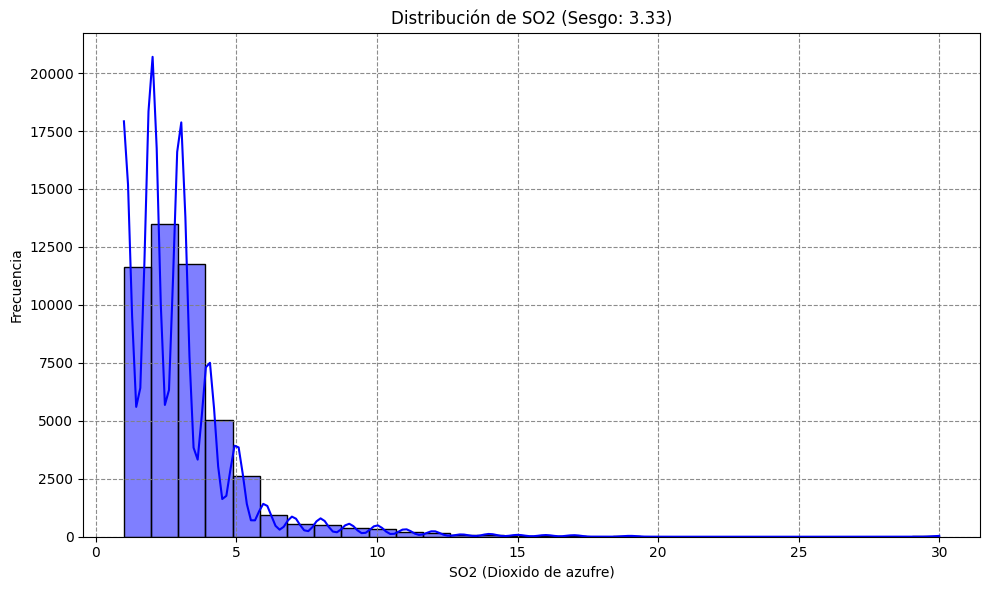

np.float64(3.33290939960844)

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ica, x="SO2", bins=30, kde=True, color="blue")
plt.title(f"Distribución de SO2 (Sesgo: {df_ica['SO2'].skew():.2f})")
plt.xlabel("SO2 (Dioxido de azufre)")
plt.ylabel("Frecuencia")
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

SO2_skewness = df_ica['SO2'].skew()
SO2_skewness

El dioxido de azufre vuelve a tener un skewness de más de 3, por lo que es una distribución muy asimétrica y positiva a la derecha, con largas colas a ese lado. El promedio se concentra en valores muy muy bajos, entre 2 y 3, aunque presenta muchos valores extremos. Los más altos en torno a 25 y un máximo en 30. La media y mediana son parecidas

In [108]:
df_ica['SO2'].describe().to_frame().T

count      mean       std  min  25%  50%  75%   max
SO2  47990.0  2.857324  2.166274  1.0  2.0  2.0  3.0  30.0

In [109]:
print(f'La media del dióxido de azufre entre 2020 y 2025 es{df_ica['SO2'].mean(): .2f}')
print(f'El valor de dióxido de azufre más frecuente entre 2020 y 2025 fue {df_ica['SO2'].mode()[0]}')
print(f'El valor máximo del dióxido de azufre entre 2020 y 2025 fue {df_ica['SO2'].max()}')
print(f'El valor mínimo del dióxido de azufre entre 2020 y 2025 fue {df_ica['SO2'].min()}')
print(f'La desviación estándar del dióxido de azufre entre 2020 y 2025 es{df_ica['SO2'].std(): .3f}')
print(f'La varianza del dióxido de azufre es{df_ica['SO2'].var(): .2f}')
print(f'El coeficiente de variación del dióxido de azufre es{df_ica['SO2'].std()/np.abs(df_ica['SO2'].mean()): .2f}')

La media del dióxido de azufre entre 2020 y 2025 es 2.86
El valor de dióxido de azufre más frecuente entre 2020 y 2025 fue 2.0
El valor máximo del dióxido de azufre entre 2020 y 2025 fue 30.0
El valor mínimo del dióxido de azufre entre 2020 y 2025 fue 1.0
La desviación estándar del dióxido de azufre entre 2020 y 2025 es 2.166
La varianza del dióxido de azufre es 4.69
El coeficiente de variación del dióxido de azufre es 0.76


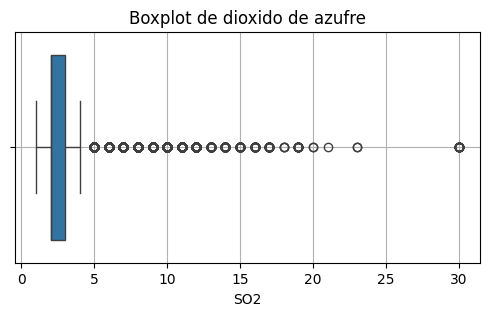

In [110]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['SO2'])
plt.grid(True)
plt.title('Boxplot de dioxido de azufre')
plt.show()

In [111]:
Q1_SO2 = df_ica['SO2'].quantile(0.25)
Q3_SO2 = df_ica['SO2'].quantile(0.75)
IQR_SO2 = Q3_SO2 - Q1_SO2

upper_limit_SO2 = Q3_SO2 + 1.5 * IQR_SO2
print(f"SO2 que se considera outlier: {upper_limit_SO2} o más")

outliers_SO2 = df_ica[df_ica['SO2'] > upper_limit_SO2]
print(f"Cantidad de outliers: {len(outliers_SO2)}")

SO2 que se considera outlier: 4.5 o más
Cantidad de outliers: 6046


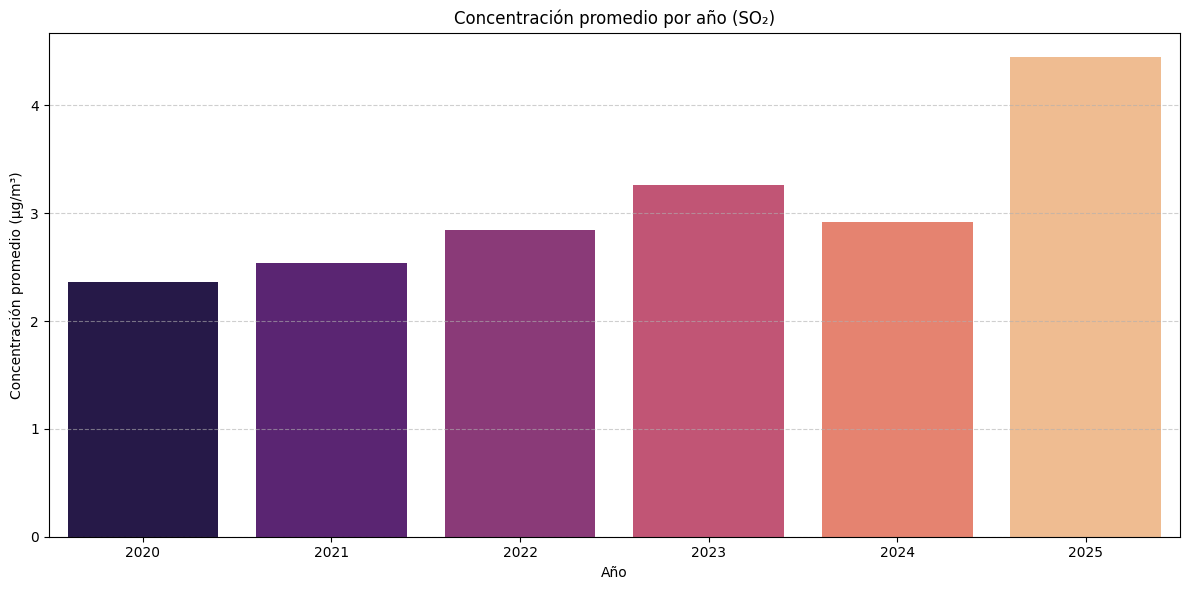

In [112]:
df_ica["año"] = df_ica["fecha"].dt.year

df_melt_año = df_ica[["año", "SO2"]].melt(id_vars="año", var_name="Contaminante", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt_año, x="año", y="Valor", ci=None, palette="magma")
plt.title("Concentración promedio por año (SO₂)")
plt.xlabel("Año")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

La tendencia anual es marcadamente ascendente desde 2020 hasta 2025, aunque no podemos contar con 2025 por tener solo datos de dos meses. Aún así 2024 tuvo un descenso, por lo que podría haber una tendencia descendente a futuro.

En cuanto a las estaciones también tiene un orden ascendente de primavera a invierno, donde tiene mayores concentraciones medias, de ahí que en el anterior gráfico 2025 sea tan abultado (concentraciones de enero y febrero)

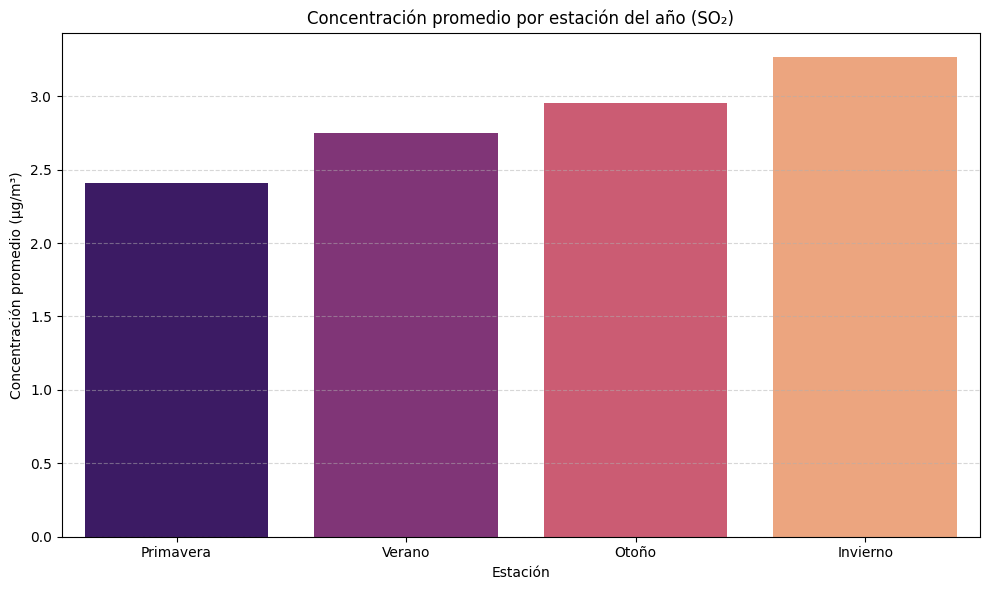

In [113]:
df_melt_est = df_ica[["estacion", "SO2"]].melt(id_vars="estacion", var_name="Contaminante", value_name="Valor")

orden_estaciones = ["Primavera", "Verano", "Otoño", "Invierno"]
df_melt_est["estacion"] = pd.Categorical(df_melt_est["estacion"], categories=orden_estaciones, ordered=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt_est, x="estacion", y="Valor", palette="magma", ci=None)
plt.title("Concentración promedio por estación del año (SO₂)")
plt.xlabel("Estación")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

MONOXIDO DE CARBONO (CO): Tiene su origen en la combustión incompleta de motores, calefacción y en fuegos forestales. Hay concentraciones altas cuando: el tráfico denso en zonas urbanas o cuando hay condiciones de baja ventilación (viento débil, inversión térmica).

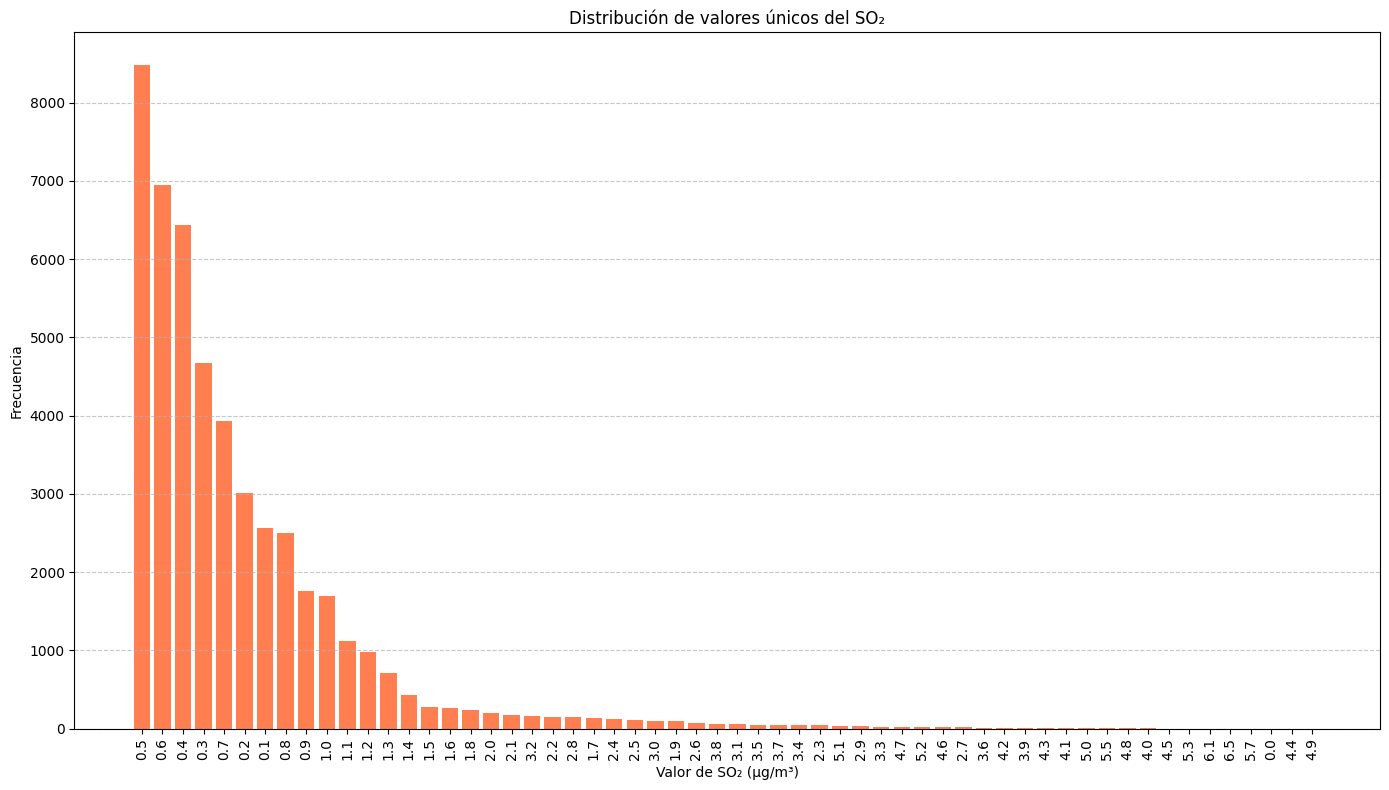

CO      0.5   0.6   0.4   0.3   0.7   0.2   0.1   0.8   0.9   1.0  ...  4.8  \
count  8473  6941  6440  4674  3927  3014  2563  2497  1758  1689  ...    2   

CO     4.0  4.5  5.3  6.1  6.5  5.7  0.0  4.4  4.9  
count    2    1    1    1    1    1    1    1    1  

[1 rows x 58 columns]

In [114]:
CO_counts = df_ica["CO"].value_counts(ascending=False)

etiquetas = CO_counts.index.astype(str)
valores = CO_counts.values

plt.figure(figsize=(14, 8))
plt.bar(etiquetas, valores, color='coral')
plt.title("Distribución de valores únicos del SO₂")
plt.xlabel("Valor de SO₂ (µg/m³)")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90, ha="center")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

CO_counts.to_frame().T

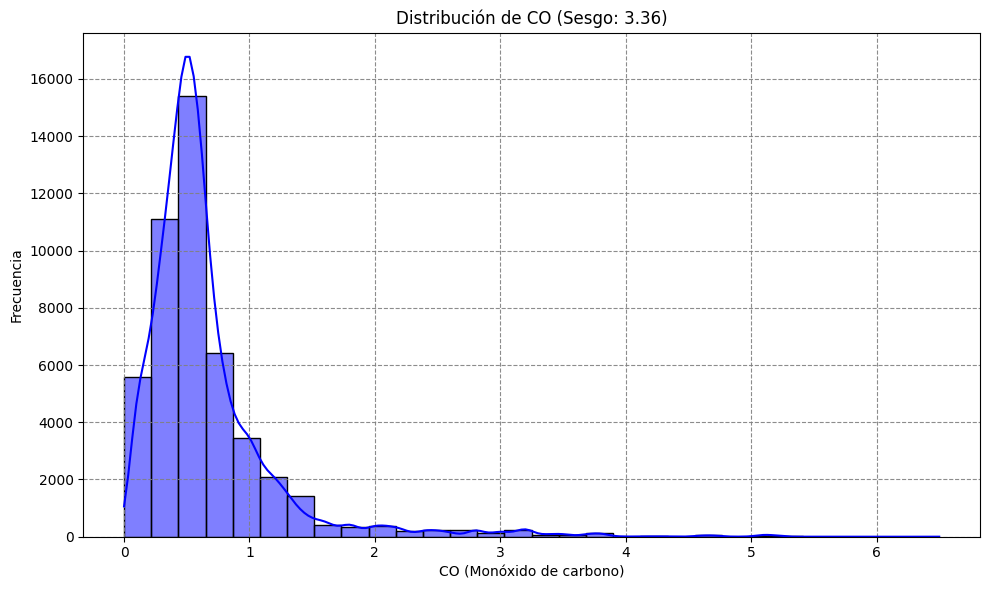

np.float64(3.359707665996673)

In [115]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ica, x="CO", bins=30, kde=True, color="blue")
plt.title(f"Distribución de CO (Sesgo: {df_ica['CO'].skew():.2f})")
plt.xlabel("CO (Monóxido de carbono)")
plt.ylabel("Frecuencia")
plt.grid(True, color="grey", linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

CO_skewness = df_ica['CO'].skew()
CO_skewness

Al igual que el SO2, el monoxido de carbono vuelve a tener un skewness de más de 3, por lo que es una distribución muy asimétrica y positiva a la derecha, con largas colas a ese lado. El promedio se concentra en valores muy muy bajos (incluso más que el SO2), entre 0 y 1, con muchísimos valores extremos entre 5 y 6. La media y mediana son parecidas

In [116]:
df_ica['CO'].describe().to_frame().T

count      mean       std  min  25%  50%  75%  max
CO  47990.0  0.664978  0.554673  0.0  0.4  0.5  0.7  6.5

In [117]:
print(f'La media del monóxido de carbono entre 2020 y 2025 es{df_ica['CO'].mean(): .2f}')
print(f'El valor de monóxido de carbono más frecuente entre 2020 y 2025 fue {df_ica['CO'].mode()[0]}')
print(f'El valor máximo del monóxido de carbono entre 2020 y 2025 fue {df_ica['CO'].max()}')
print(f'El valor mínimo del monóxido de carbono entre 2020 y 2025 fue {df_ica['CO'].min()}')
print(f'La desviación estándar del monóxido de carbono entre 2020 y 2025 es{df_ica['CO'].std(): .3f}')
print(f'La varianza del monóxido de carbono es{df_ica['CO'].var(): .2f}')
print(f'El coeficiente de variación del monóxido de carbono es{df_ica['CO'].std()/np.abs(df_ica['CO'].mean()): .2f}')

La media del monóxido de carbono entre 2020 y 2025 es 0.66
El valor de monóxido de carbono más frecuente entre 2020 y 2025 fue 0.5
El valor máximo del monóxido de carbono entre 2020 y 2025 fue 6.5
El valor mínimo del monóxido de carbono entre 2020 y 2025 fue 0.0
La desviación estándar del monóxido de carbono entre 2020 y 2025 es 0.555
La varianza del monóxido de carbono es 0.31
El coeficiente de variación del monóxido de carbono es 0.83


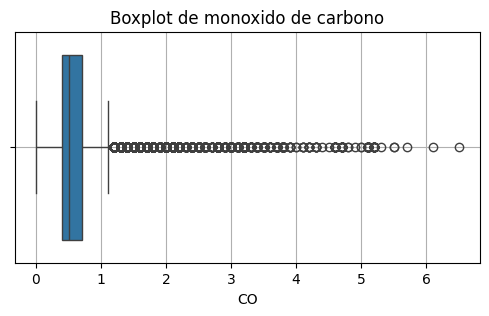

In [118]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_ica['CO'])
plt.grid(True)
plt.title('Boxplot de monoxido de carbono')
plt.show()

In [119]:
Q1_CO = df_ica['CO'].quantile(0.25)
Q3_CO = df_ica['CO'].quantile(0.75)
IQR_CO = Q3_CO - Q1_CO

upper_limit_CO = Q3_CO + 1.5 * IQR_CO
print(f"CO que se considera outlier: {upper_limit_CO} o más")

outliers_CO = df_ica[df_ica['CO'] > upper_limit_CO]
print(f"Cantidad de outliers: {len(outliers_CO)}")

CO que se considera outlier: 1.15 o más
Cantidad de outliers: 4899


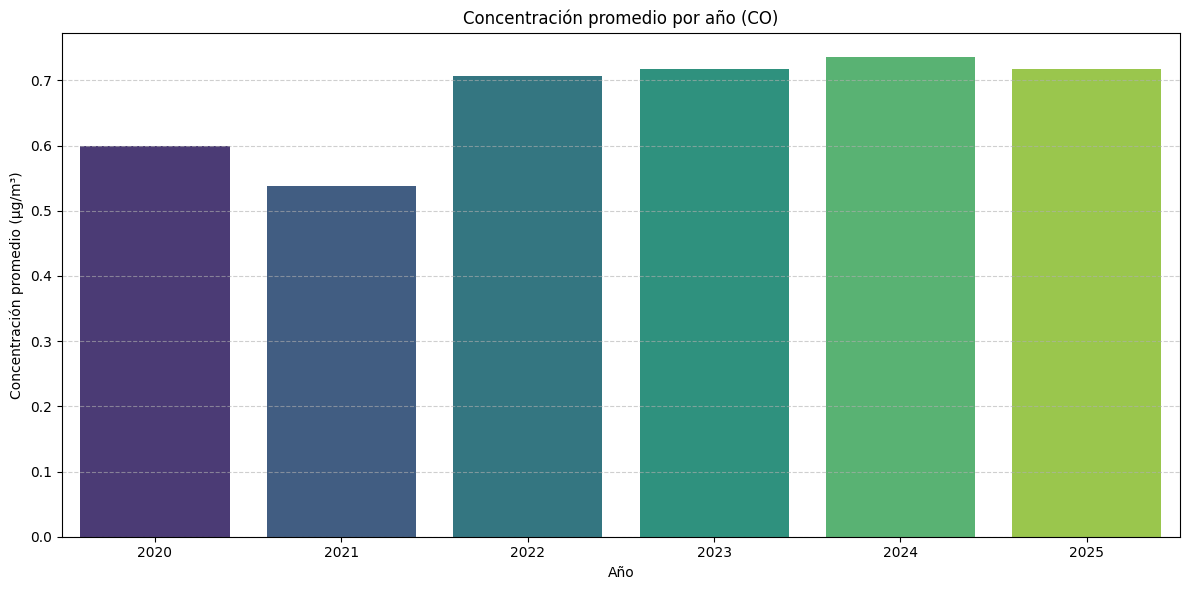

In [120]:
df_ica["año"] = df_ica["fecha"].dt.year

df_melt_año = df_ica[["año", "CO"]].melt(id_vars="año", var_name="Contaminante", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt_año, x="año", y="Valor", ci=None, palette="viridis")
plt.title("Concentración promedio por año (CO)")
plt.xlabel("Año")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

El monóxido de carbono fue más bajo en 2020 y bajando en 2021, a partir de este tiene una tendencia ascendente en los últimos años. En este caso puede ser debido a que hay mayor concentración de datos de CO en los últimos años y menos registros en 2021 y 2021.

La estación veraniega es la que menos concentración emdia de CO tiene y la que más es invierno. Esto parece indicar que la causa son las calefacciones e industrias de producción o uso de calor artificial, por lo que el frío sería causa indirecta.

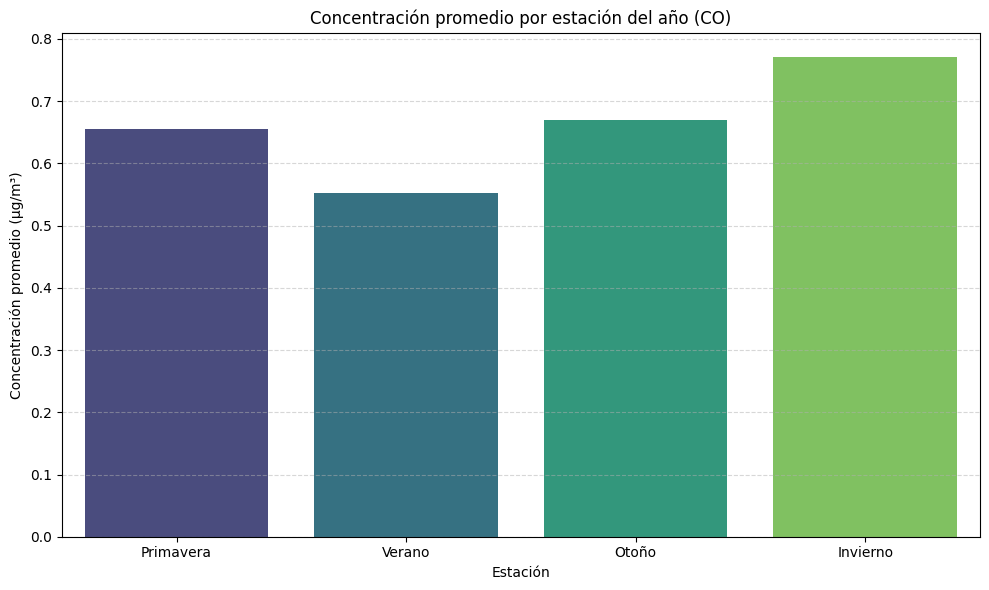

In [121]:
df_melt_est = df_ica[["estacion", "CO"]].melt(id_vars="estacion", var_name="Contaminante", value_name="Valor")

orden_estaciones = ["Primavera", "Verano", "Otoño", "Invierno"]
df_melt_est["estacion"] = pd.Categorical(df_melt_est["estacion"], categories=orden_estaciones, ordered=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt_est, x="estacion", y="Valor", palette="viridis", ci=None)
plt.title("Concentración promedio por estación del año (CO)")
plt.xlabel("Estación")
plt.ylabel("Concentración promedio (µg/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

MATRIZ DE DISPERSIÓN ENTRE CONTAMINANTES

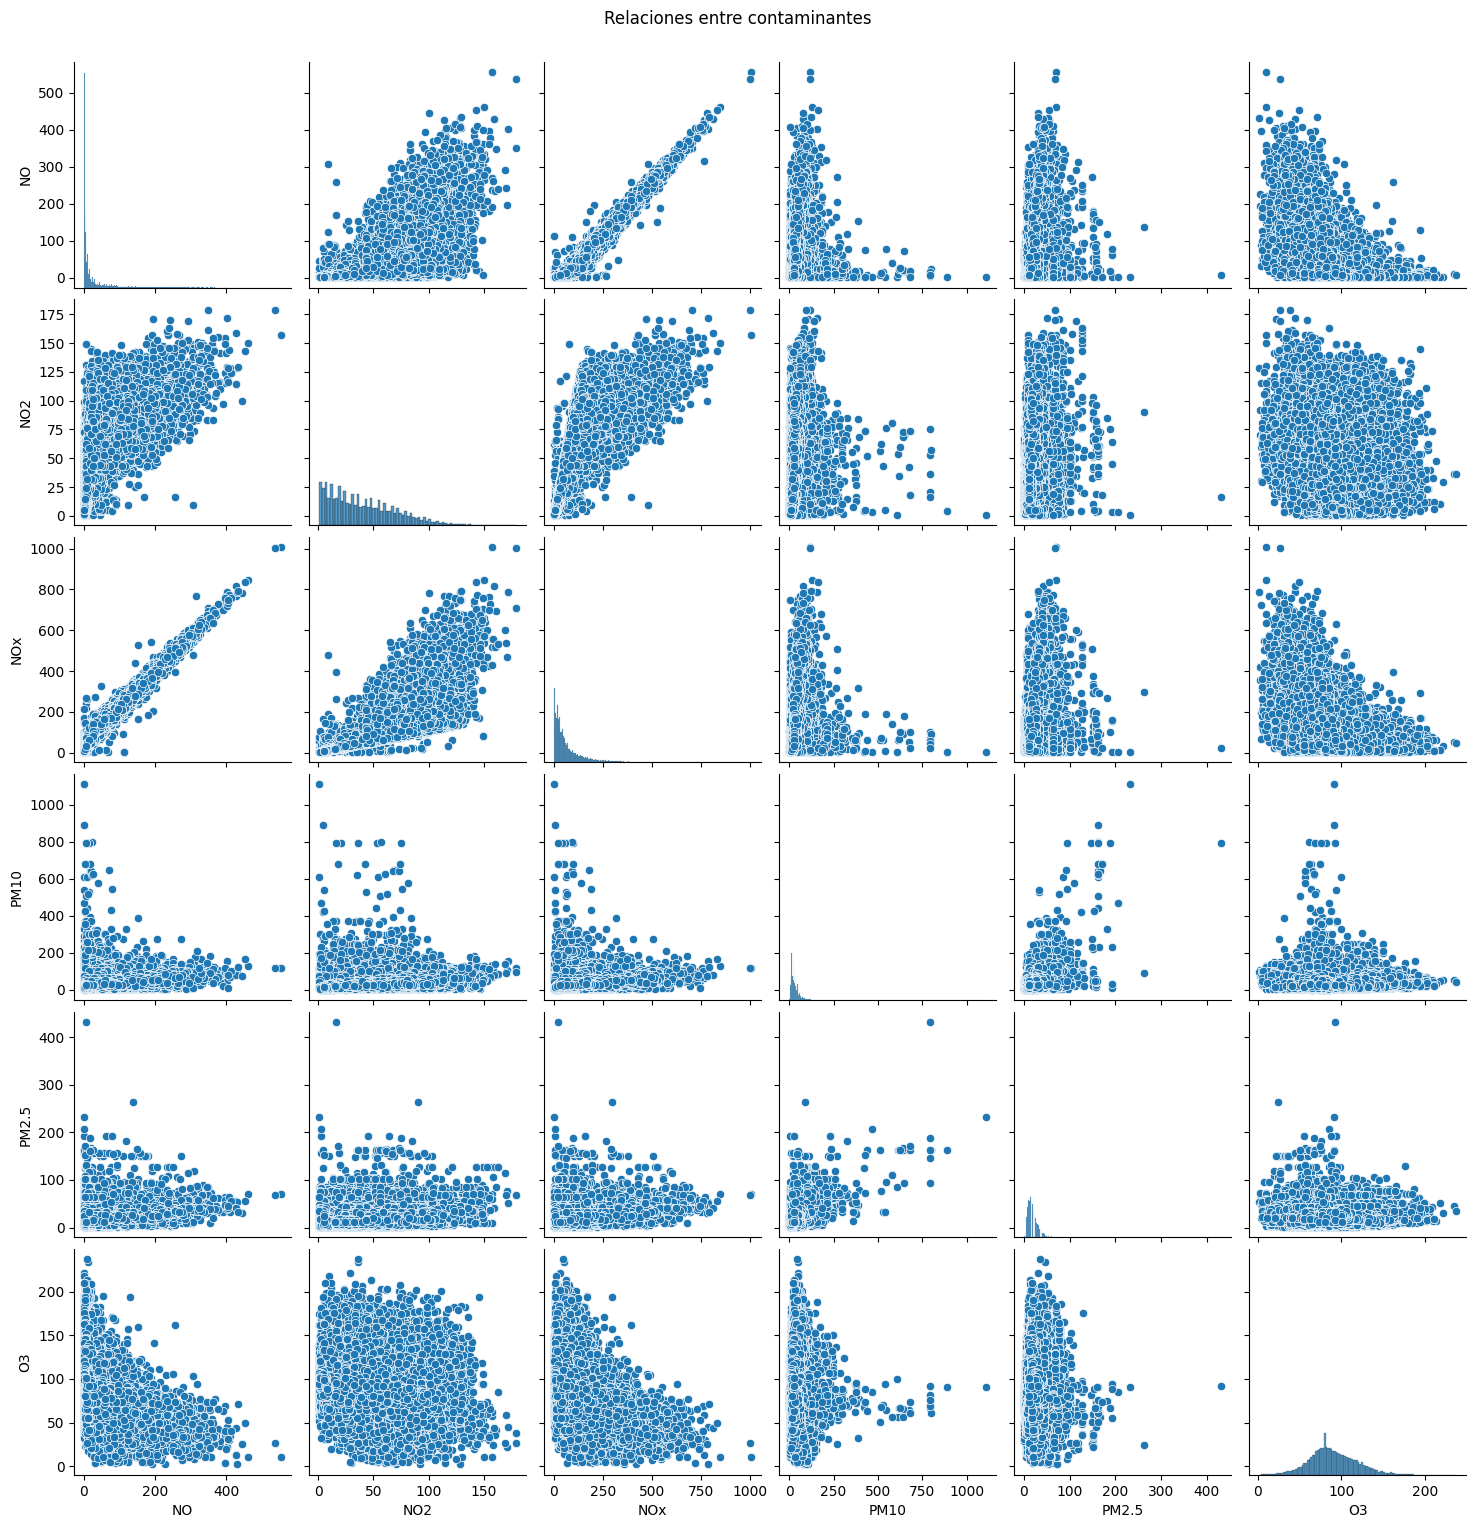

In [122]:
contaminantes = ["NO", "NO2", "NOx", "PM10", "PM2.5", "O3"]
sns.pairplot(df_ica[contaminantes])
plt.suptitle("Relaciones entre contaminantes", y=1.02)
plt.show()

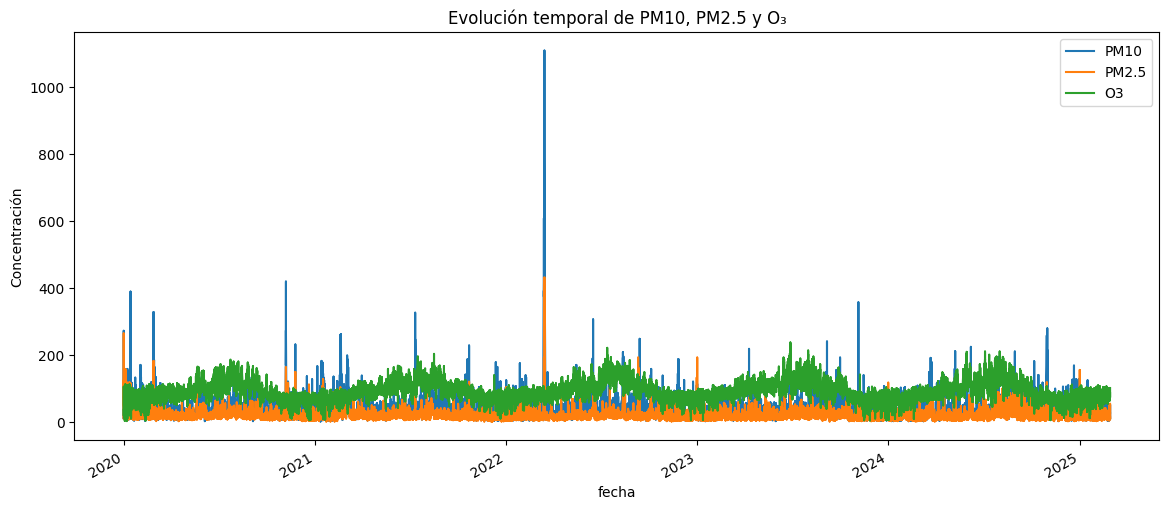

In [123]:
df_ica.set_index("fecha")[["PM10", "PM2.5", "O3"]].plot(figsize=(14,6))
plt.title("Evolución temporal de PM10, PM2.5 y O₃")
plt.ylabel("Concentración")
plt.show()

En la evolución temporal vemos aptrones parecidos estacionarios y picos muy extremos, sobre todo en el PM10, el NO y el PM2.5

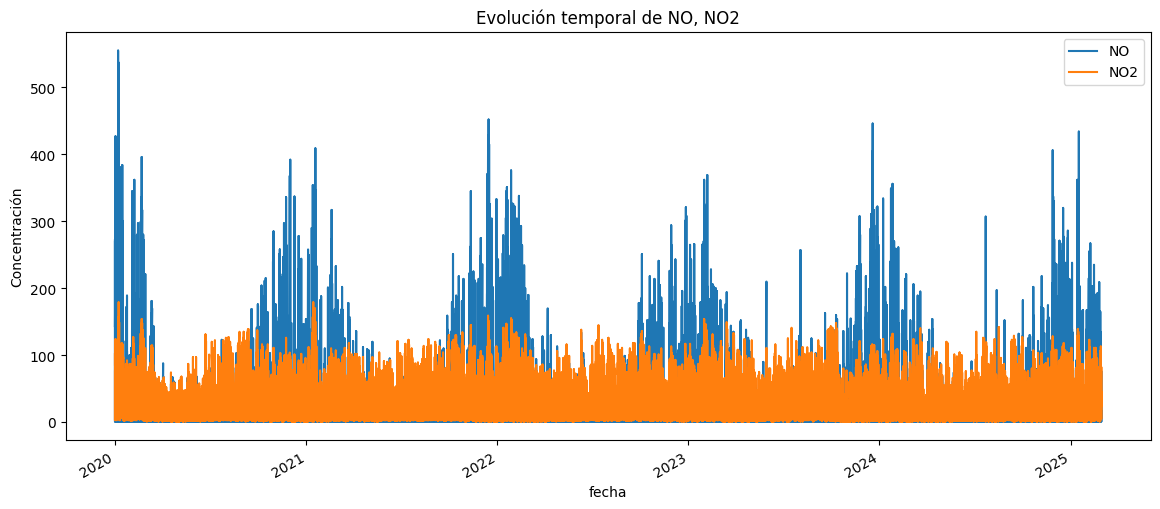

In [124]:
df_ica.set_index("fecha")[["NO", "NO2"]].plot(figsize=(14,6))
plt.title("Evolución temporal de NO, NO2")
plt.ylabel("Concentración")
plt.show()

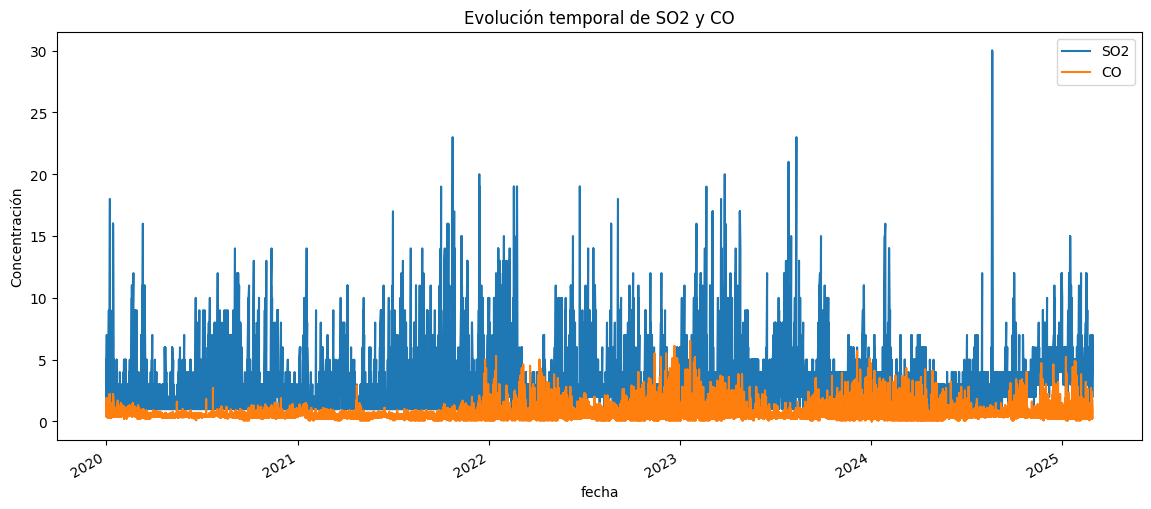

In [125]:
df_ica.set_index("fecha")[["SO2", "CO"]].plot(figsize=(14,6))
plt.title("Evolución temporal de SO2 y CO")
plt.ylabel("Concentración")
plt.show()

POR ESTACIONES DEL AÑO: El ozono sube con la subida de las temperaturas. Los NO (oxidos de nitrógeno), al revés, bajan cuando sube la temperatura. 

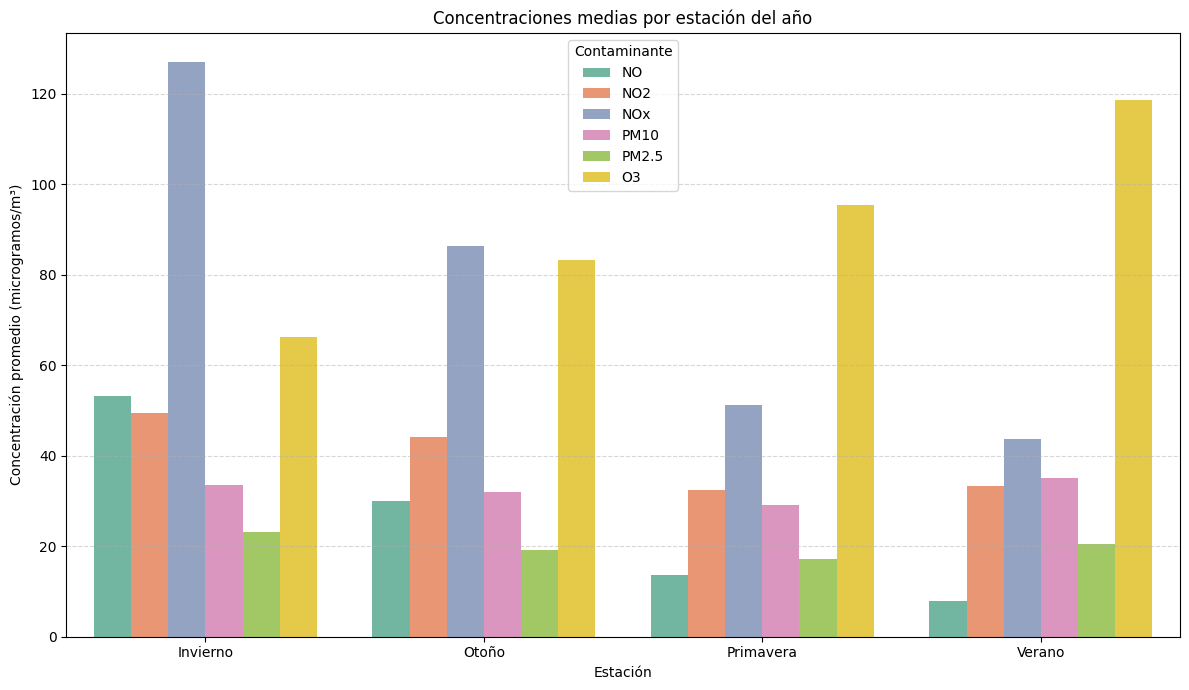

In [126]:
df_cont_estacion = df_ica.groupby("estacion")[contaminantes].mean().reset_index()

df_estacion = df_cont_estacion.melt(id_vars="estacion", var_name="Contaminante", value_name="Media")

# Graficar
plt.figure(figsize=(12, 7))
sns.barplot(data=df_estacion, x="estacion", y="Media", hue="Contaminante", palette="Set2")
plt.title("Concentraciones medias por estación del año")
plt.xlabel("Estación")
plt.ylabel("Concentración promedio (microgramos/m³)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Contaminante")
plt.tight_layout()
plt.show()

Análisis de correlación parcial para recordar esas asociaciones negativas y positivas entre los contaminantes. Entre grupos como los NOx y los PM e inversas como entre O3 y los NOx. PM (10 y 2.5) sube ligeramente en las estaciones extremas (de frío y calor): verano e invierno. Y es más bajo en primavera y en menro emdida en otoño

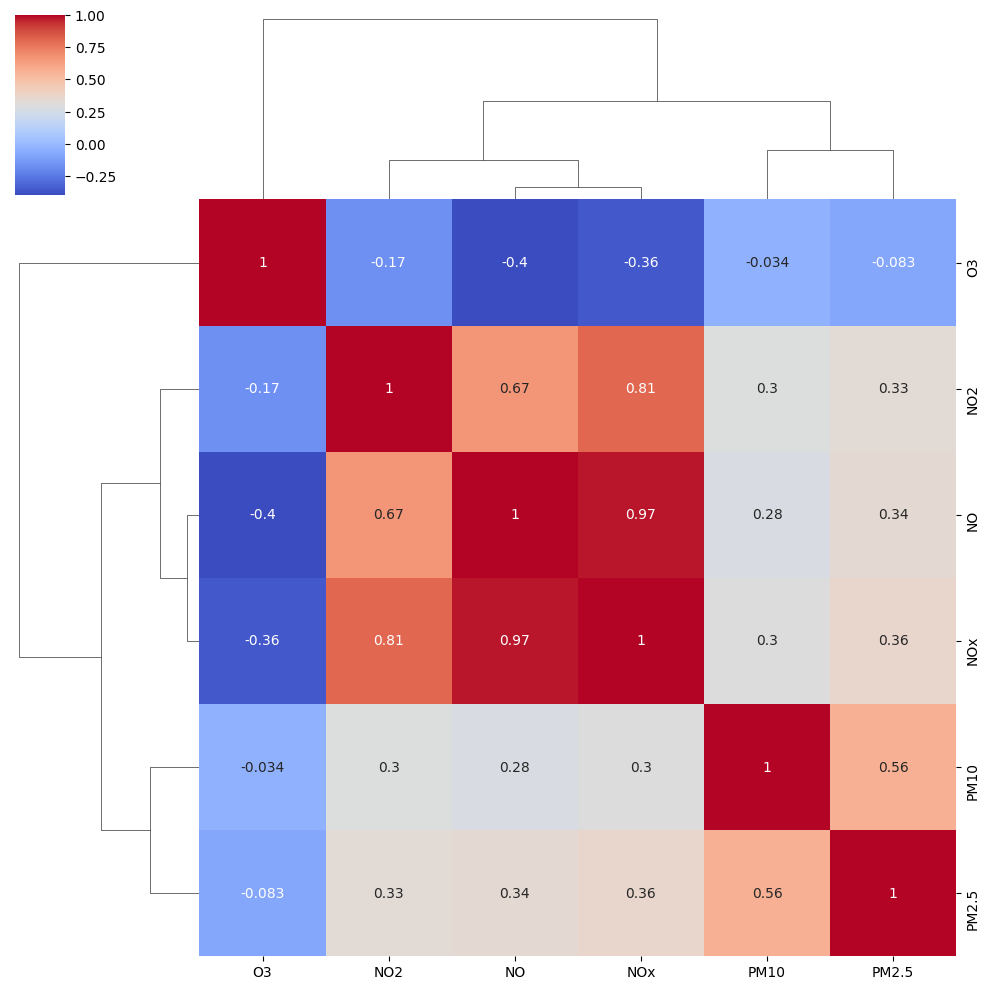

In [127]:
sns.clustermap(df_ica[contaminantes].corr(), annot=True, cmap="coolwarm")

____
#### ANÁLISIS POR FENÓMENOS METEOROLÓGICOS

In [128]:
vars_meteo = ['humedad_relativa', 'precipitacion', 'presion_atmosferica',
              'radiación_solar', 'temperatura', 'velocidad_viento']

df_ica[vars_meteo].describe().T

count        mean         std    min      25%     50%  \
humedad_relativa     47990.0   55.662981   21.416245    0.0   38.080   54.88   
precipitacion        47990.0    0.040850    0.225223    0.0    0.000    0.00   
presion_atmosferica  47990.0  882.773199  112.892172  549.2  908.880  936.38   
radiación_solar      47990.0  182.892401  103.867093    0.0   97.055  169.48   
temperatura          47990.0   14.140663    7.855238  -40.0    8.010   12.93   
velocidad_viento     47990.0    1.540915    1.091472    0.0    0.800    1.36   

                        75%      max  
humedad_relativa      72.96   100.00  
precipitacion          0.00    30.92  
presion_atmosferica  947.58  1015.21  
radiación_solar      266.96  1258.11  
temperatura           19.80    43.37  
velocidad_viento       1.98    35.60

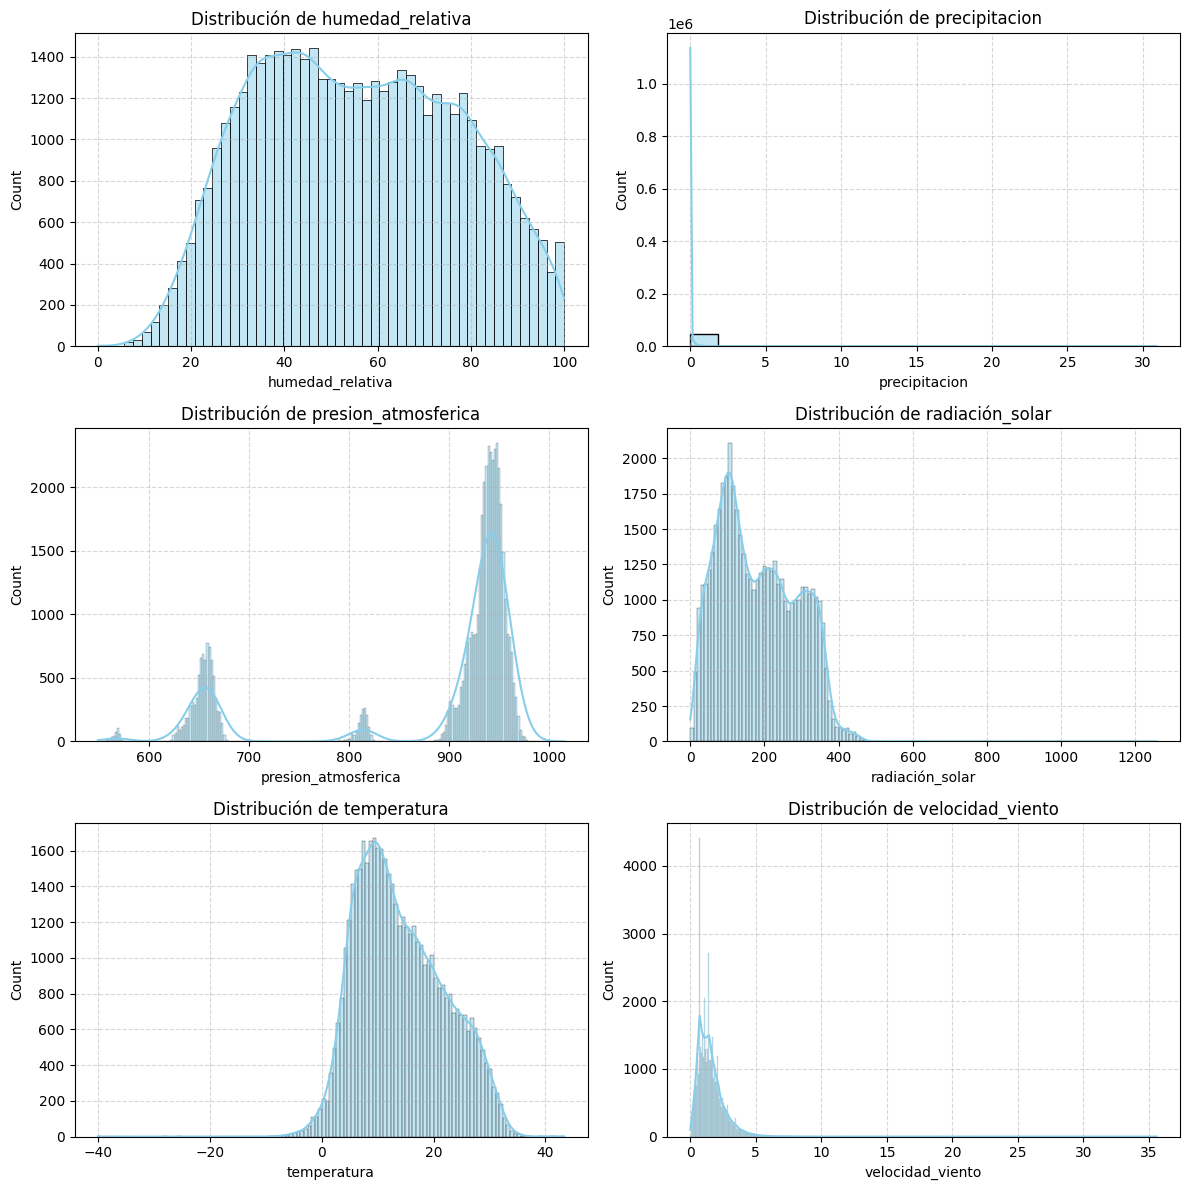

In [129]:
n = len(vars_meteo)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(vars_meteo):
    sns.histplot(df_ica[var], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribución de {var}")
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [130]:
skewness_dict = {var: df_ica[var].skew() for var in vars_meteo}
df_skew = pd.DataFrame.from_dict(skewness_dict, orient='index', columns=['Skewness']).sort_values('Skewness', ascending=False)
df_skew

Skewness
precipitacion        59.891635
velocidad_viento      4.778675
radiación_solar       0.427350
temperatura           0.349289
humedad_relativa      0.091986
presion_atmosferica  -1.506504

La precipitación es extremadamente alta y positiva. Por ello es altamente asimétrica debido a muchos valores muy bajos bajos y algunos valores extremadamente altos. Esto se traduciría en que la mayoría de los días no llueve o llueve poco, y hay picos puntuales de lluvias intensas.

La velovidad del viento es alta, pero no tanto como la precipitación. Esto supone que la mayoría se centra en valores bastante bajos de viento, pero hay valores extremos con ráfagas de viento altas.

La radiación_solar y la temperatura son distribuciones más simétricas simétricas (0.43 y 0.35), pero aún con asimetrías de leve a moderada hacia la derecha. Esto indica que hay más valores ligeramente por debajo del promedio que por encima. La traducción sería que tiene a haber un clima templado durante el año, pero con episodios de altas temperaturas.

La humedad relativa es casi simétrica, por lo que tiene my buen balance entre los registros de los datos. Por último, la presión atmosferica, con skewness de -1.51, presenta una asimetría negativa, con cola larga hacia los valores bajos. Esto podría deberse a eventos meteorológicos donde la presión cae mucho (por ejemplo, tormentas), mientras la mayoría de los días tiene una presión estable o alta.

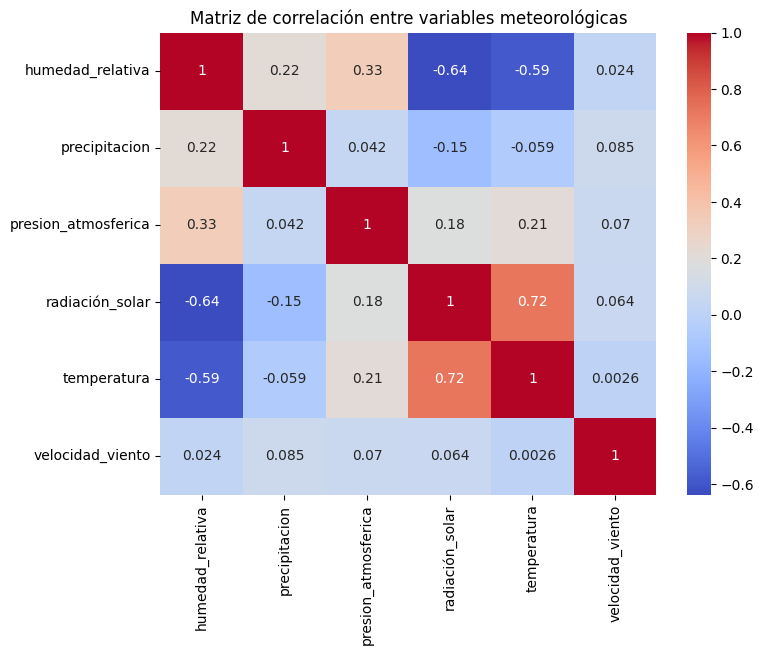

In [131]:
plt.figure(figsize=(8, 6))
corr = df_ica[vars_meteo].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables meteorológicas")
plt.show()

Las correlaciones más claras son entre el viento y el ICA, la humedad y la radiación y la temperatura, como ya vimos, que es inversa. Y esta también con la presión y las precipitaciones. Con el ICA tiene correlaciones muy bajas, por lo que no influyen tanto en el valor de la calidad del aire, menos la velocidad del aire, que es una variable de importancia moderada para el ICA

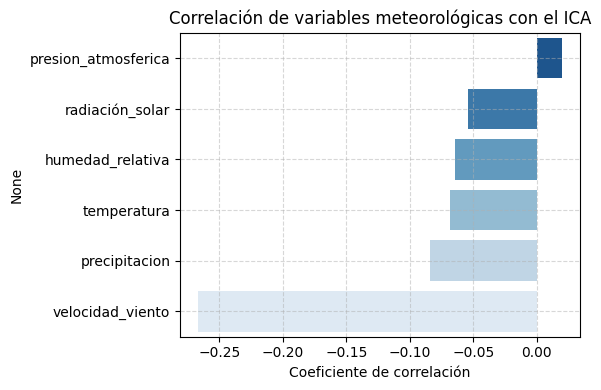

presion_atmosferica    0.019847
radiación_solar       -0.054399
humedad_relativa      -0.064608
temperatura           -0.068492
precipitacion         -0.083937
velocidad_viento      -0.266653
Name: ICA, dtype: float64

In [132]:
corr_meteo_ica = df_ica[vars_meteo + ['ICA']].corr()['ICA'].drop('ICA').sort_values(ascending=False)
corr_meteo_ica.to_frame(name='Correlación con ICA')

plt.figure(figsize=(6, 4))
sns.barplot(x=corr_meteo_ica.values, y=corr_meteo_ica.index, palette="Blues_r")
plt.title("Correlación de variables meteorológicas con el ICA")
plt.xlabel("Coeficiente de correlación")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

corr_meteo_ica

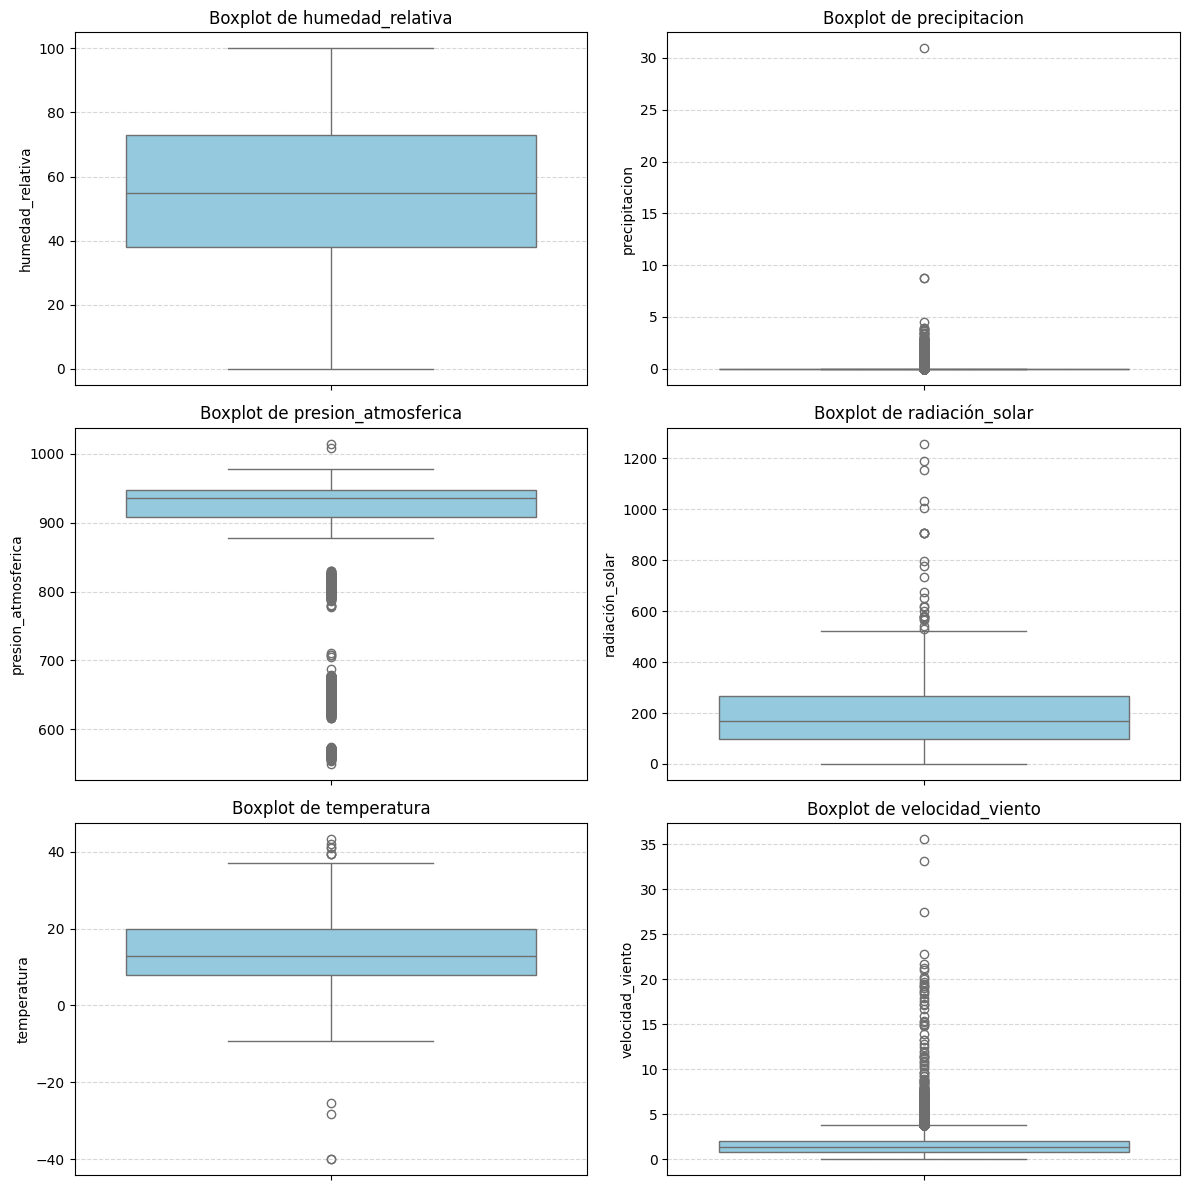

In [133]:
n = len(vars_meteo)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(vars_meteo):
    sns.boxplot(y=df_ica[var], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot de {var}")
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)

# Ocultar subgráficos vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Vemos bastantes valores atipicos y extremos: normales en la presión, debido dias aislados de menor presión, en la radiación por días de ola de calor con valores solares extremos y en la velocidad del viento, que tiene días concretos con ráfagas de aire. Sobre todo hay que prestar atención a la precipitación que tiene outliers mucho más altos, pero parece normal para esta variable, ya que practicamente es outlier el simple hecho de que llueva, tendiendo la mayoria a ser 0 (que no haya precipitación)

____
#### ANÁLISIS POR MUNICIPIOS

Los municipios con peor calidad de aire promedio (entre 150 y 175 de media) son Leganés, Getafe, Coslada, Rivas Vaciamadrid y Alcalá de Henares. Las conclusiones de esto es que son todo áreas metropolitanas de Madrid, casi todos en la zona sur, sur-este o este de la comunidad. Son ciudades dormitorio con dependencia laboral (trabajos) y de servicios (como el transporte) con Madrid centro. Son ciudades de gran crecimiento poblacional e industrial en los últimos 30 años.

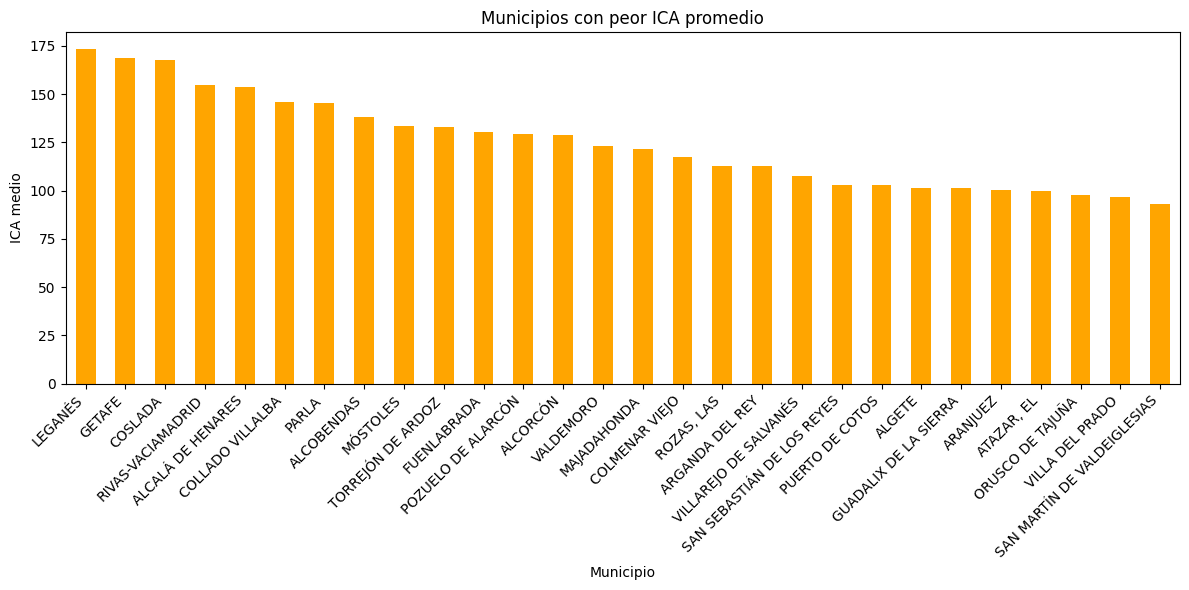

In [134]:
peor_ica_municipio = df_ica.groupby("municipio")["ICA"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
peor_ica_municipio.plot(kind="bar", color="orange")
plt.title("Municipios con peor ICA promedio")
plt.ylabel("ICA medio")
plt.xlabel("Municipio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Los municipios con mejor calidad de aire promedio (entre 90 y 105 de media) son San Martín de Valdeiglesias, Villa del prado, Orsuco de tajuña, El Atazar, Aranjuez y Guadalix de la Sierra. Las conclusiones de esto es que todas ellas NO pertencen al área metropolitana de Madrid, en la zona suroeste, norte y solo Aranjuez en el sur, pero pegado a Castilla la Mancha. Son ciudades relacionadas con la naturaleza, embalses, turismo rural y la agricultura. No dependen de la ciudad de Madrid y NO son ciudades cercanas o ciudades dormitorio. Todos ellos, salvo Aranjuez tienen baja densidad poblacional, con menos de 10.000 habitantes, cierto crecimiento urbano, pero con una estructura rural tradicional. Aranjuez es la excepción, pero geográficamente se sitúa en zona incluso fuera de la Comunidad de Madrid (es un apéndice), con menos población, tráfico e industria en los alrededores. Lo consideraríamos un lugar turístico cultural

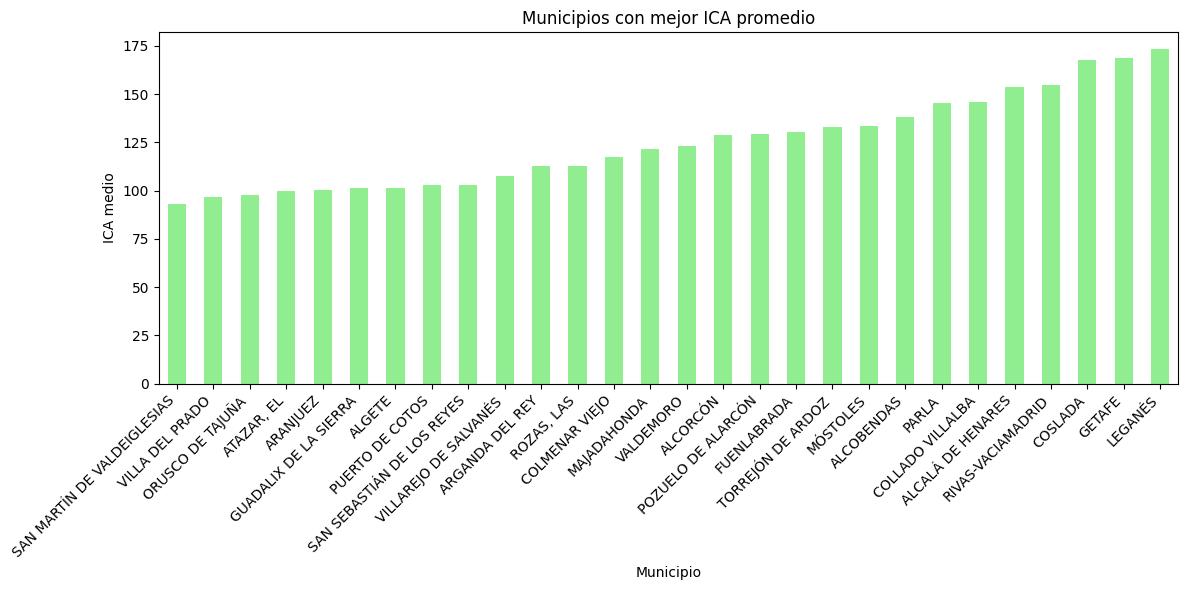

In [135]:
mejor_ica_municipio = df_ica.groupby("municipio")["ICA"].mean().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
mejor_ica_municipio.plot(kind="bar", color="lightgreen")
plt.title("Municipios con mejor ICA promedio")
plt.ylabel("ICA medio")
plt.xlabel("Municipio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

En cuanto a los municipios con más días con un ICA superior a 200 son casi los mismos que los de las medias más altas: Leganés, Getafe, Coslada, Rivas y cambia solo Villalba (en el noroeste y con una población muy grande, en aumento en los últimos años)

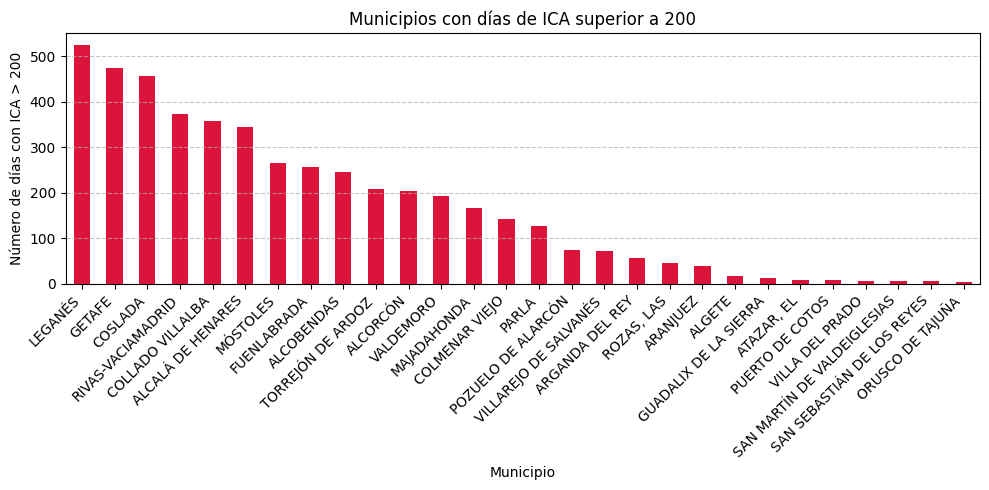

municipio  LEGANÉS  GETAFE  COSLADA  RIVAS-VACIAMADRID  COLLADO VILLALBA  \
count          525     474      456                373               357   

municipio  ALCALÁ DE HENARES  MÓSTOLES  FUENLABRADA  ALCOBENDAS  \
count                    344       266          257         245   

municipio  TORREJÓN DE ARDOZ  
count                    209

In [136]:
top_ica_municipios = df_ica[df_ica["ICA"] > 200]["municipio"].value_counts()

top_ica_municipios.plot(kind="bar", color="crimson", figsize=(10, 5))
plt.title("Municipios con días de ICA superior a 200")
plt.xlabel("Municipio")
plt.ylabel("Número de días con ICA > 200")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

top_ica_municipios.head(10).to_frame().T

En cuanto a los municipios con más días con un ICA inferior a 40 son exactamente los mismos que los de las medias más bajas

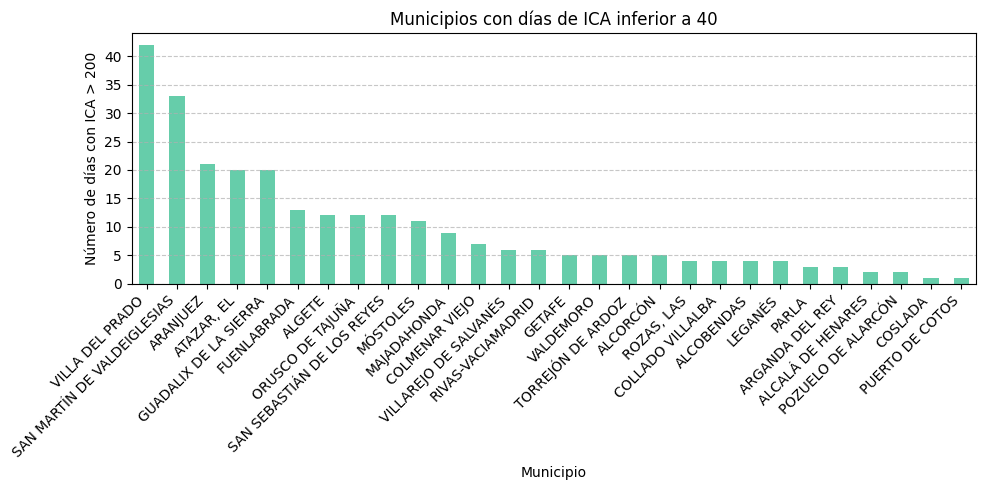

municipio  VILLA DEL PRADO  SAN MARTÍN DE VALDEIGLESIAS  ARANJUEZ  ATAZAR, EL  \
count                   42                           33        21          20   

municipio  GUADALIX DE LA SIERRA  FUENLABRADA  ALGETE  ORUSCO DE TAJUÑA  \
count                         20           13      12                12   

municipio  SAN SEBASTIÁN DE LOS REYES  MÓSTOLES  
count                              12        11

In [137]:
menor_ica_municipios = df_ica[df_ica["ICA"] < 50]["municipio"].value_counts()

menor_ica_municipios.plot(kind="bar", color="mediumaquamarine", figsize=(10, 5))
plt.title("Municipios con días de ICA inferior a 40")
plt.xlabel("Municipio")
plt.ylabel("Número de días con ICA > 200")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

menor_ica_municipios.head(10).to_frame().T

In [138]:
df_ica.columns

Index(['fecha', 'municipio', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5',
       'SO2', 'ICA', 'categoria_ICA', 'humedad_relativa', 'precipitacion',
       'presion_atmosferica', 'radiación_solar', 'temperatura',
       'velocidad_viento', 'estacion', 'dia_semana', 'año'],
      dtype='object')

In [139]:
df_contaminantes_municipio = df_ica.groupby('municipio')[['O3', 'NO', 'NO2', 'PM10', 
                                                          'PM2.5','SO2', 'CO', 'ICA']].mean()

for col in df_contaminantes_municipio.columns:
    print(f"\nMunicipios con mayor concentración media de {col}:")
    display(df_contaminantes_municipio[[col]].sort_values(by=col, ascending=False).head(5))


Municipios con mayor concentración media de O3:


O3
municipio                             
PUERTO DE COTOS             100.655885
ATAZAR, EL                   98.402969
GUADALIX DE LA SIERRA        96.100742
ORUSCO DE TAJUÑA             96.015915
SAN SEBASTIÁN DE LOS REYES   94.400556


Municipios con mayor concentración media de NO:


NO
municipio                   
LEGANÉS            59.280488
COSLADA            58.670732
GETAFE             56.898727
RIVAS-VACIAMADRID  48.539851
COLLADO VILLALBA   46.965536


Municipios con mayor concentración media de NO2:


NO2
municipio                   
LEGANÉS            65.964475
COSLADA            62.292153
GETAFE             61.067338
RIVAS-VACIAMADRID  56.875664
ALCALÁ DE HENARES  56.318134


Municipios con mayor concentración media de PM10:


PM10
municipio                   
COSLADA            41.725875
ARGANDA DEL REY    40.430860
RIVAS-VACIAMADRID  40.338470
LEGANÉS            39.586426
TORREJÓN DE ARDOZ  38.729570


Municipios con mayor concentración media de PM2.5:


PM2.5
municipio                       
VILLAREJO DE SALVANÉS  24.994698
COLLADO VILLALBA       24.463415
COSLADA                23.477200
VALDEMORO              22.884411
TORREJÓN DE ARDOZ      22.004839


Municipios con mayor concentración media de SO2:


SO2
municipio                           
ALCALÁ DE HENARES           4.679215
POZUELO DE ALARCÓN          3.173239
SAN SEBASTIÁN DE LOS REYES  3.171071
PARLA                       3.130814
ROZAS, LAS                  3.113464


Municipios con mayor concentración media de CO:


CO
municipio                           
COLMENAR VIEJO              1.310870
ALCALÁ DE HENARES           0.736850
SAN SEBASTIÁN DE LOS REYES  0.724478
POZUELO DE ALARCÓN          0.721972
PARLA                       0.720058


Municipios con mayor concentración media de ICA:


ICA
municipio                    
LEGANÉS            173.294804
GETAFE             168.607105
COSLADA            167.569459
RIVAS-VACIAMADRID  154.925080
ALCALÁ DE HENARES  153.435313

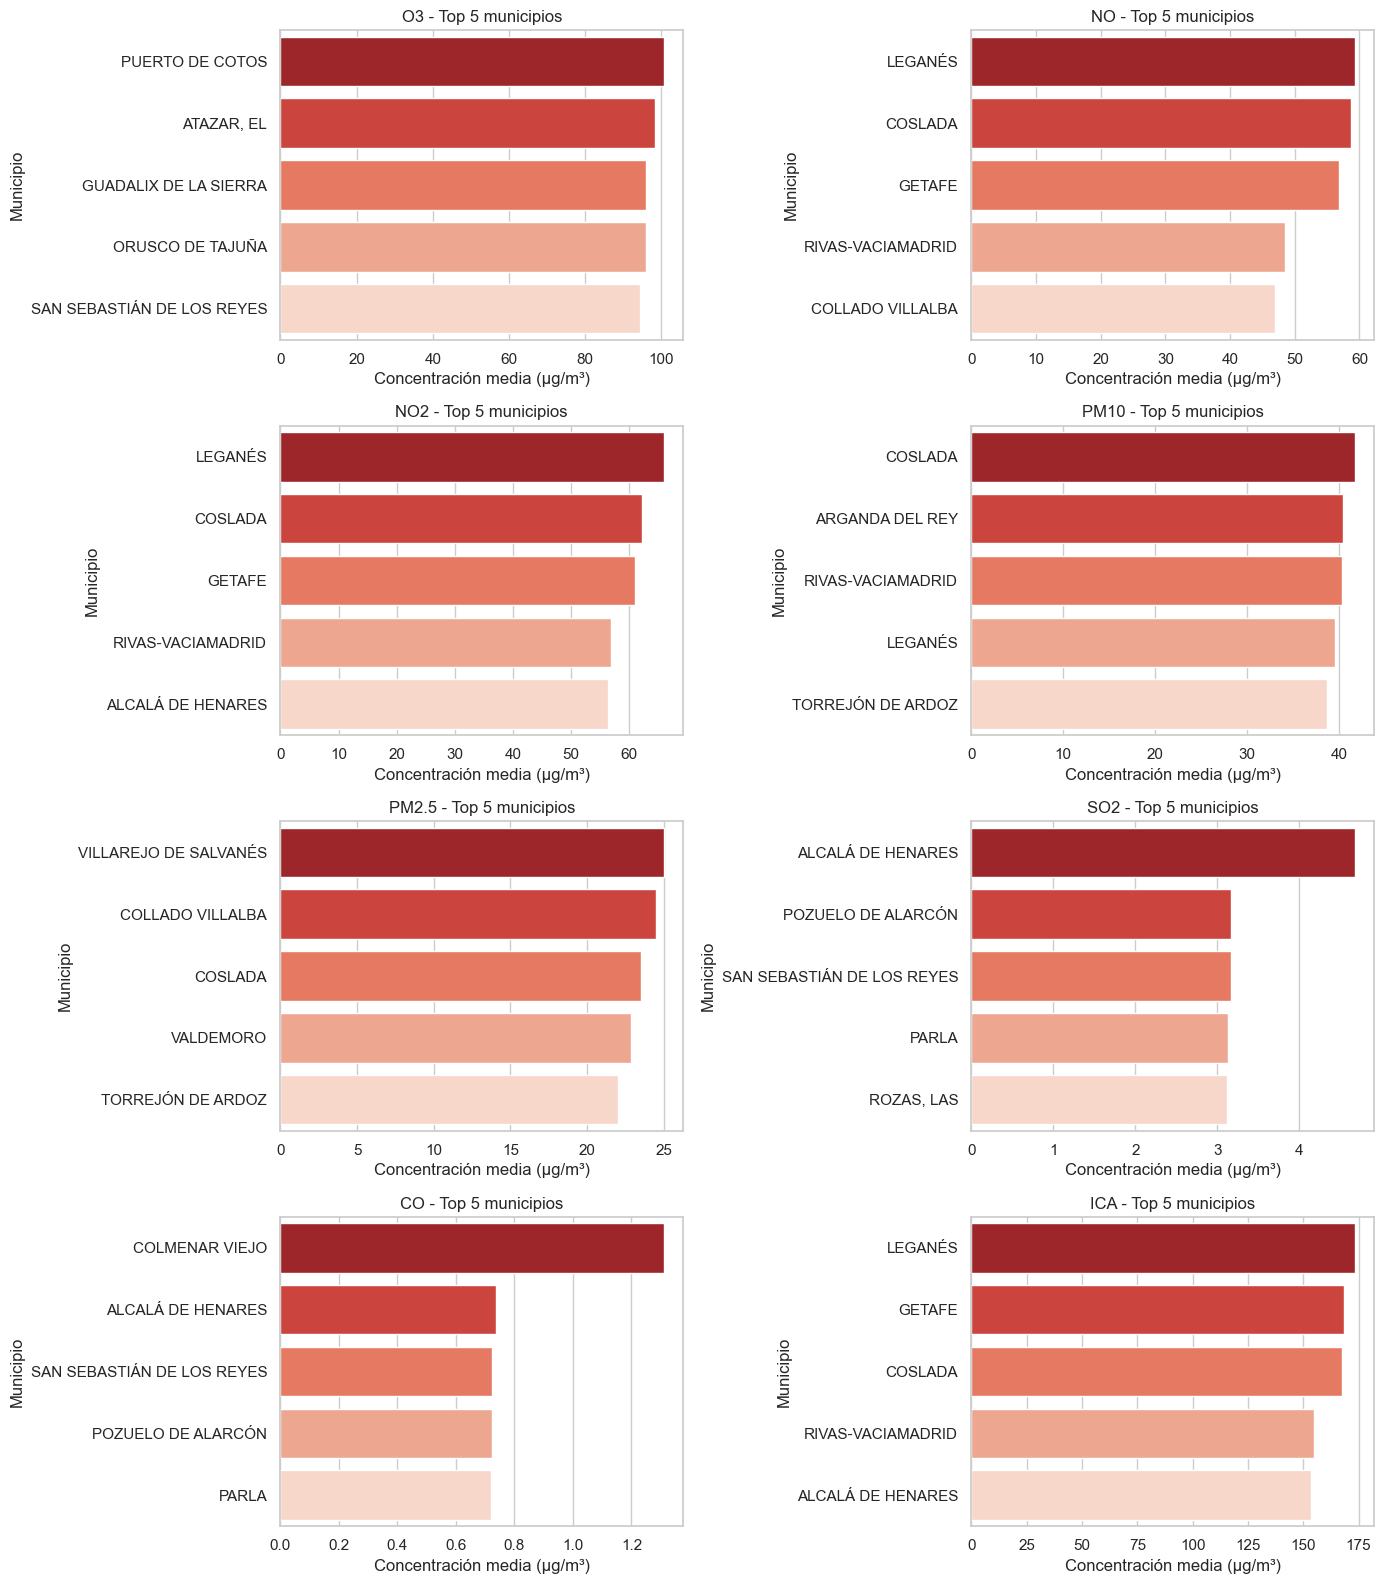

In [140]:
sns.set(style="whitegrid")

df_filtrado = df_contaminantes_municipio.drop(index=["cluster", "contaminacion_municipio"], errors="ignore")

contaminantes = df_filtrado.columns
n = len(contaminantes)

n_cols = 2
n_rows = (n + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(contaminantes):
    top_munis = df_filtrado[[col]].sort_values(by=col, ascending=False).head(5)
    sns.barplot(x=top_munis[col], y=top_munis.index, ax=axes[i], palette="Reds_r")
    axes[i].set_title(f"{col} - Top 5 municipios")
    axes[i].set_xlabel("Concentración media (µg/m³)")
    axes[i].set_ylabel("Municipio")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [141]:
df_contaminantes_municipio = df_ica.groupby('municipio')[['O3', 'NO', 'NO2', 'PM10', 
                                                          'PM2.5','SO2', 'CO', 'ICA']].mean()

for col in df_contaminantes_municipio.columns:
    print(f"\nMunicipios con menor concentración media de {col}:")
    display(df_contaminantes_municipio[[col]].sort_values(by=col, ascending=True).head(5))


Municipios con menor concentración media de O3:


O3
municipio            
ROZAS, LAS  84.113464
GETAFE      84.588547
MÓSTOLES    85.264502
LEGANÉS     85.291622
ARANJUEZ    85.572110


Municipios con menor concentración media de NO:


NO
municipio                            
PUERTO DE COTOS              1.591198
ATAZAR, EL                   2.132556
ORUSCO DE TAJUÑA             2.220690
VILLA DEL PRADO              3.853581
SAN MARTÍN DE VALDEIGLESIAS  6.049841


Municipios con menor concentración media de NO2:


NO2
municipio                             
PUERTO DE COTOS               3.683987
ATAZAR, EL                    7.262460
ORUSCO DE TAJUÑA              9.623873
VILLA DEL PRADO              11.145889
SAN MARTÍN DE VALDEIGLESIAS  15.904030


Municipios con menor concentración media de PM10:


PM10
municipio                            
PUERTO DE COTOS             19.385472
ATAZAR, EL                  19.647932
SAN SEBASTIÁN DE LOS REYES  23.995828
ORUSCO DE TAJUÑA            24.454642
ROZAS, LAS                  25.706505


Municipios con menor concentración media de PM2.5:


PM2.5
municipio                    
ATAZAR, EL          12.606575
PUERTO DE COTOS     14.483033
VILLA DEL PRADO     16.915650
ALGETE              18.065748
POZUELO DE ALARCÓN  18.295775


Municipios con menor concentración media de SO2:


SO2
municipio                 
MÓSTOLES          1.995210
ATAZAR, EL        2.088017
COLLADO VILLALBA  2.265642
VILLA DEL PRADO   2.772944
ARANJUEZ          2.852598


Municipios con menor concentración media de CO:


CO
municipio                 
ORUSCO DE TAJUÑA  0.346472
VILLA DEL PRADO   0.351141
ATAZAR, EL        0.512831
ARGANDA DEL REY   0.661826
ARANJUEZ          0.662142


Municipios con menor concentración media de ICA:


ICA
municipio                              
SAN MARTÍN DE VALDEIGLESIAS   92.986744
VILLA DEL PRADO               96.838727
ORUSCO DE TAJUÑA              97.798939
ATAZAR, EL                   100.004242
ARANJUEZ                     100.445387

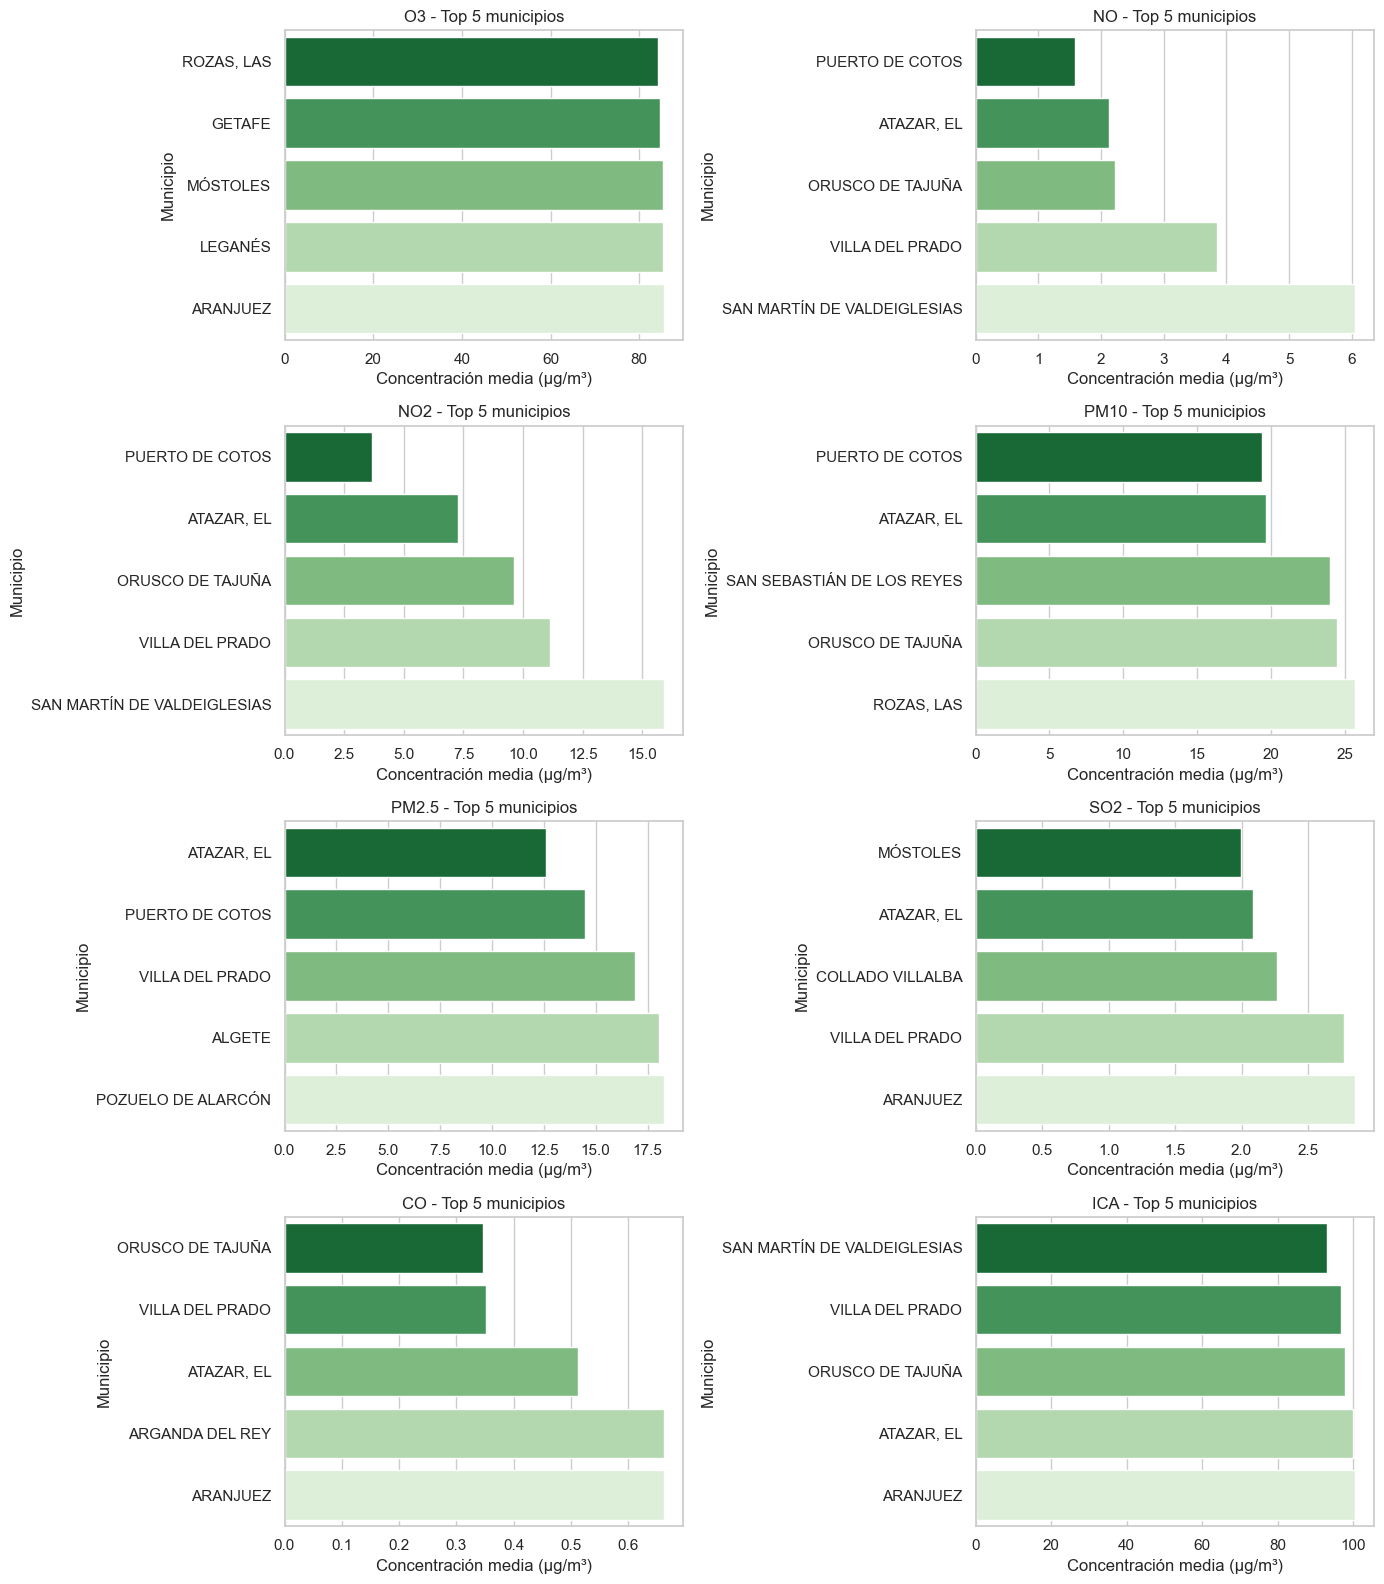

In [142]:
sns.set(style="whitegrid")

n_cols = 2
n_rows = (n + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(contaminantes):
    top_munis = df_filtrado[[col]].sort_values(by=col, ascending=True).head(5)
    sns.barplot(x=top_munis[col], y=top_munis.index, ax=axes[i], palette="Greens_r")
    axes[i].set_title(f"{col} - Top 5 municipios")
    axes[i].set_xlabel("Concentración media (µg/m³)")
    axes[i].set_ylabel("Municipio")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

El ICA mensual por municipio entre Abril y Septiembre es muy similar, sin mucho que destacar, se concentra en promedio entre 85 y 130. Marzo y Octubre son algo más dispersos, pero los más dispersos de todos son los meses Enero, Diciembre, Febrero y Noviembre (en ese orden). En estos la dispersión es muy grande y coinciden con los de las medias anuales, siendo Collado Villalba, Rivas-Vaciamadrid, Coslada, Leganés y Valdemoro. Los que menor ICA promedio en enero-febrero son El Atazar, Puerto de Cotos, Villa del Prado, Parla y San Sebastián de los Reyes. En Diciembre-Noviembre, coinciden: El Atazar, Puerto de Cotos y Villa del Prado. Y por altos: Valdemoro, Collado Villalba, Coslada y Villarejo de Salvanés

<Axes: title={'center': 'ICA mensual por municipio'}, xlabel='mes'>

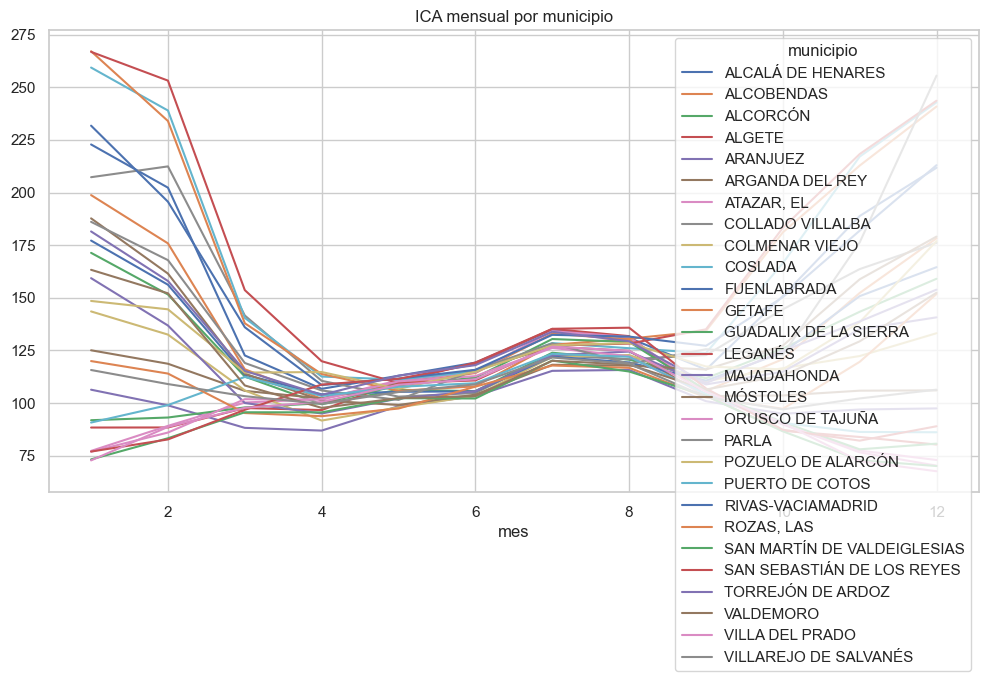

In [143]:
df_ica['mes'] = df_ica['fecha'].dt.month
df_mensual = df_ica.groupby(['municipio', 'mes'])['ICA'].mean().unstack(0)
df_mensual.plot(figsize=(12, 6), title="ICA mensual por municipio")

### CLUSTERING PARA AGRUPAR MUNICIPIOS POR TIPO DE CONTAMINACIÓN

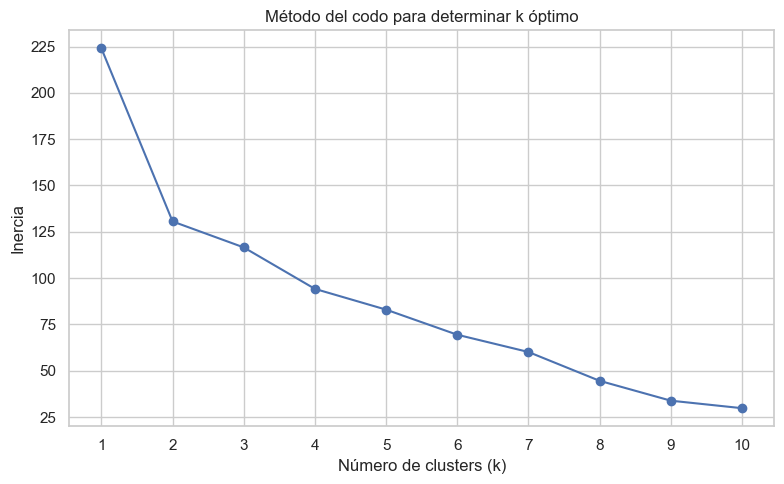

In [144]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df_contaminantes_municipio)

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar k óptimo')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

Con el método del codo vemos que aunque en 2 clusters hay un cambio grande es entre 3 y 4 donde la inercia deja de ser tan significativa, asi que haré 4 clusters

In [145]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

df_contaminantes_municipio['cluster'] = kmeans.labels_

In [146]:
df_contaminantes_municipio

O3         NO        NO2       PM10  \
municipio                                                                  
ALCALÁ DE HENARES             92.518028  46.582715  56.318134  36.033404   
ALCOBENDAS                    89.860021  34.112937  49.890774  30.601273   
ALCORCÓN                      86.430541  27.393425  55.771474  32.999470   
ALGETE                        94.388653   8.190880  28.384942  32.999470   
ARANJUEZ                      85.572110  14.465005  35.493107  38.181866   
ARGANDA DEL REY               91.658836  25.182061  37.806727  40.430860   
ATAZAR, EL                    98.402969   2.132556   7.262460  19.647932   
COLLADO VILLALBA              86.387063  46.965536  53.320785  32.999470   
COLMENAR VIEJO                88.589608  23.738070  43.149523  31.812831   
COSLADA                       85.842524  58.670732  62.292153  41.725875   
FUENLABRADA                   85.631495  32.328738  54.258749  36.570520   
GETAFE                        84.588547  56.898727  61.067338  38.230117   
GUADALIX DE LA SIERRA         96.100742  12.317603  22.917285  29.112937   
LEGANÉS                       85.291622  59.280488  65.964475  39.586426   
MAJADAHONDA                   87.975080  24.102333  46.275716  25.919936   
MÓSTOLES                      85.264502  32.606173  53.790846  36.080362   
ORUSCO DE TAJUÑA              96.015915   2.220690   9.623873  24.454642   
PARLA                         85.802326  40.662791  52.398256  28.988372   
POZUELO DE ALARCÓN            89.191549  35.197183  44.076056  28.864789   
PUERTO DE COTOS              100.655885   1.591198   3.683987  19.385472   
RIVAS-VACIAMADRID             90.863709  48.539851  56.875664  40.338470   
ROZAS, LAS                    84.113464  19.972769  45.829047  25.706505   
SAN MARTÍN DE VALDEIGLESIAS   90.280488   6.049841  15.904030  28.155355   
SAN SEBASTIÁN DE LOS REYES    94.400556  10.304590  28.367177  23.995828   
TORREJÓN DE ARDOZ             91.426344  33.516129  50.063978  38.729570   
VALDEMORO                     86.547720  29.438494  43.010604  32.999470   
VILLA DEL PRADO               94.313528   3.853581  11.145889  26.815915   
VILLAREJO DE SALVANÉS         93.072110  14.452280  34.642630  32.999470   

                                 PM2.5       SO2        CO         ICA  \
municipio                                                                
ALCALÁ DE HENARES            20.639449  4.679215  0.736850  153.435313   
ALCOBENDAS                   20.059915  2.852598  0.662142  137.908271   
ALCORCÓN                     20.316543  2.852598  0.662142  128.694592   
ALGETE                       18.065748  2.852598  0.662142  101.537116   
ARANJUEZ                     20.059915  2.852598  0.662142  100.445387   
ARGANDA DEL REY              19.977576  2.855312  0.661826  112.552589   
ATAZAR, EL                   12.606575  2.088017  0.512831  100.004242   
COLLADO VILLALBA             24.463415  2.265642  0.662142  145.980382   
COLMENAR VIEJO               20.059915  2.852598  1.310870  117.556204   
COSLADA                      23.477200  2.852598  0.662142  167.569459   
FUENLABRADA                  20.059915  2.852598  0.662142  130.580594   
GETAFE                       21.346235  2.852598  0.662142  168.607105   
GUADALIX DE LA SIERRA        20.059915  2.852598  0.662142  101.374337   
LEGANÉS                      20.407741  2.852598  0.662142  173.294804   
MAJADAHONDA                  20.059915  2.852598  0.662142  121.368505   
MÓSTOLES                     20.058542  1.995210  0.700692  133.369345   
ORUSCO DE TAJUÑA             20.064721  2.989920  0.346472   97.798939   
PARLA                        19.699128  3.130814  0.720058  145.388081   
POZUELO DE ALARCÓN           18.295775  3.173239  0.721972  129.483099   
PUERTO DE COTOS              14.483033  2.852598  0.662142  102.766702   
RIVAS-VACIAMADRID            20.069607  2.853348  0.662274  154.925080   
ROZAS, LAS                   20.390318  3.113464  0.71

Comprobamos los tamaños de los clusters 

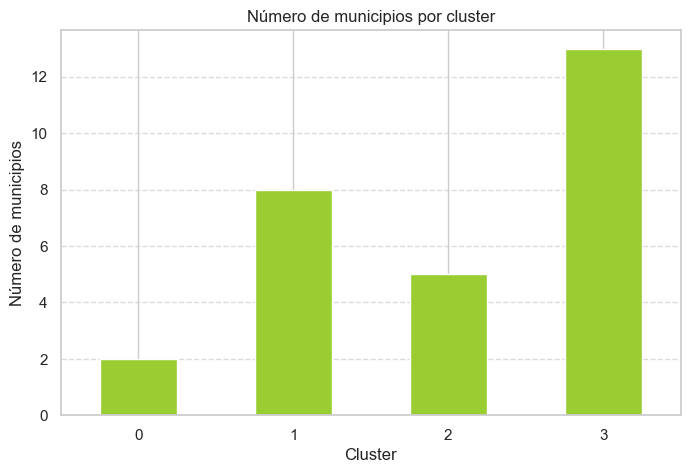

cluster
0     2
1     8
2     5
3    13
Name: count, dtype: int64

In [147]:
cluster_counts = df_contaminantes_municipio['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='yellowgreen')
plt.title("Número de municipios por cluster")
plt.xlabel("Cluster")
plt.ylabel("Número de municipios")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

cluster_counts

In [148]:
cluster_describe = df_contaminantes_municipio.groupby('cluster').describe()
cluster_describe

O3                                                        \
        count       mean       std        min        25%        50%   
cluster                                                               
0         2.0  85.825782  0.793770  85.264502  85.545142  85.825782   
1         8.0  95.569842  3.086684  90.280488  94.369872  95.208236   
2         5.0  87.820886  3.608359  84.588547  85.291622  85.842524   
3        13.0  88.143939  2.766215  84.113464  85.802326  87.975080   

                                  NO             ...        CO            \
               75%         max count       mean  ...       75%       max   
cluster                                          ...                       
0        86.106423   86.387063   2.0  39.785855  ...  0.691054  0.700692   
1        96.676299  100.655885   8.0   5.832617  ...  0.662142  0.724478   
2        90.863709   92.518028   5.0  53.994503  ...  0.662274  0.736850   
3        89.860021   93.072110  13.0  27.274017  ...  0.713313  1.310870   

          ICA                                                             \
        count        mean        std         min         25%         50%   
cluster                                                                    
0         2.0  139.674864   8.917349  133.369345  136.522104  139.674864   
1         8.0   99.525660   3.433686   92.986744   97.558886  100.689290   
2         5.0  163.566352   8.851361  153.435313  154.925080  167.569459   
3        13.0  123.146049  12.700408  100.445387  112.971256  123.306999   

                                 
                75%         max  
cluster                          
0        142.827623  145.980382  
1        101.844512  102.898470  
2        168.607105  173.294804  
3        130.580594  145.388081  

[4 rows x 64 columns]

In [149]:
cluster_describe = df_contaminantes_municipio.groupby('cluster').mean()
cluster_describe.T

cluster           0          1           2           3
O3        85.825782  95.569842   87.820886   88.143939
NO        39.785855   5.832617   53.994503   27.274017
NO2       53.555815  15.911205   60.503553   45.589742
PM10      34.539916  25.570944   39.182858   32.677302
PM2.5     22.260978  17.784552   21.188046   20.681759
SO2        2.130426   2.804043    3.218071    2.919195
CO         0.681417   0.572936    0.677110    0.725076
ICA      139.674864  99.525660  163.566352  123.146049

Hacemos un describe de las variables para poder comparar en sus concentraciones medias y ver patrones que indiquen el tipo de cluster que tenemos. Visualizando observamos una distribución (forma poligonal) muy parecida pero que va en aumento, por lo que indicaría el nivel ascendente de contaminación en cada cluster. Los contaminantes que más van aumentando en general son NO y NO2, que son producto principalmente de la contaminación urbano por tçrafico e industria. Solo PM2.5 supera de un cluster a otro (0 y 2), pero es mínimo. Así que podemos proceder a nombrar a cada cluster basándonos en el nivel de contaminantes y contaminación general, de hecho al comparar los resultados con la media del ICA (139.674864,	99.525660,	163.566352,	123.146049) se correspond con el nivel de contaminantes y contaminación. El cluster 2 es el de más contaminación, después eñ cluster 0, el 3 y el 1 el que menos (con valores de NO muy bajos en comparación, qu explica que sean entornos naturales sin tanto tráfico)

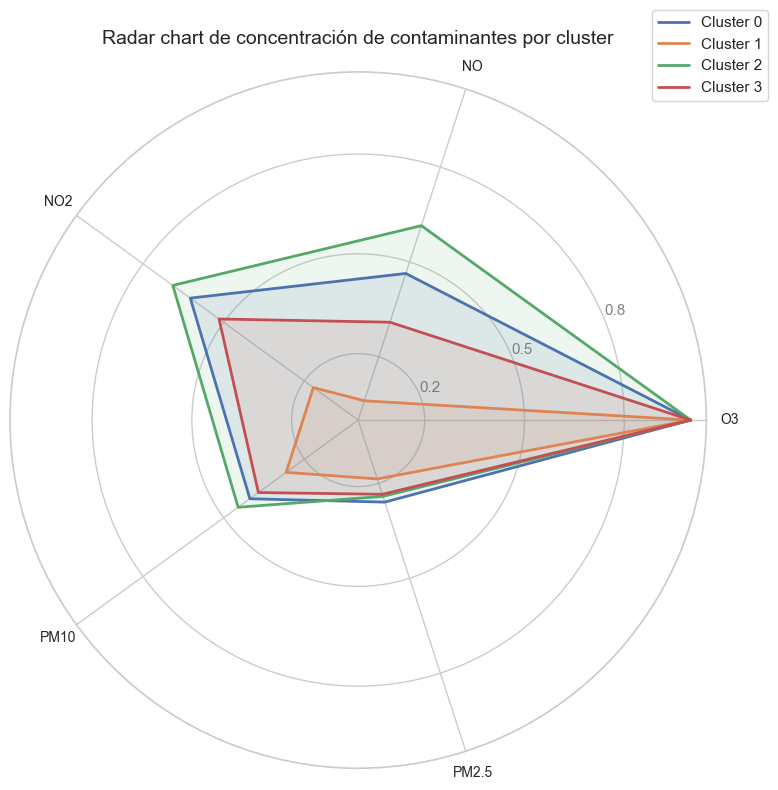

In [150]:
columnas_numericas = df_contaminantes_municipio.select_dtypes(include='number').columns.tolist()

columnas_excluir = ['cluster', 'ICA','CO', 'SO2']
contaminantes = [col for col in columnas_numericas if col not in columnas_excluir]

df_cluster_means = df_contaminantes_municipio.groupby('cluster')[contaminantes].mean()

df_norm = df_cluster_means.div(df_cluster_means.max(axis=1), axis=0)

labels = contaminantes
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]


plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for idx, row in df_norm.iterrows():
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_yticklabels(['0.2', '0.5', '0.8'], color='gray')
ax.set_title("Radar chart de concentración de contaminantes por cluster", size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

In [151]:
cluster_nombres = {
    0: "Contaminación alta",
    1: "Contaminación baja",
    2: "Contaminación muy alta",
    3: "Contaminación media"
}

df_contaminantes_municipio['contaminacion_municipio'] = df_contaminantes_municipio['cluster'].map(cluster_nombres)

df_contaminantes_municipio

O3         NO        NO2       PM10  \
municipio                                                                  
ALCALÁ DE HENARES             92.518028  46.582715  56.318134  36.033404   
ALCOBENDAS                    89.860021  34.112937  49.890774  30.601273   
ALCORCÓN                      86.430541  27.393425  55.771474  32.999470   
ALGETE                        94.388653   8.190880  28.384942  32.999470   
ARANJUEZ                      85.572110  14.465005  35.493107  38.181866   
ARGANDA DEL REY               91.658836  25.182061  37.806727  40.430860   
ATAZAR, EL                    98.402969   2.132556   7.262460  19.647932   
COLLADO VILLALBA              86.387063  46.965536  53.320785  32.999470   
COLMENAR VIEJO                88.589608  23.738070  43.149523  31.812831   
COSLADA                       85.842524  58.670732  62.292153  41.725875   
FUENLABRADA                   85.631495  32.328738  54.258749  36.570520   
GETAFE                        84.588547  56.898727  61.067338  38.230117   
GUADALIX DE LA SIERRA         96.100742  12.317603  22.917285  29.112937   
LEGANÉS                       85.291622  59.280488  65.964475  39.586426   
MAJADAHONDA                   87.975080  24.102333  46.275716  25.919936   
MÓSTOLES                      85.264502  32.606173  53.790846  36.080362   
ORUSCO DE TAJUÑA              96.015915   2.220690   9.623873  24.454642   
PARLA                         85.802326  40.662791  52.398256  28.988372   
POZUELO DE ALARCÓN            89.191549  35.197183  44.076056  28.864789   
PUERTO DE COTOS              100.655885   1.591198   3.683987  19.385472   
RIVAS-VACIAMADRID             90.863709  48.539851  56.875664  40.338470   
ROZAS, LAS                    84.113464  19.972769  45.829047  25.706505   
SAN MARTÍN DE VALDEIGLESIAS   90.280488   6.049841  15.904030  28.155355   
SAN SEBASTIÁN DE LOS REYES    94.400556  10.304590  28.367177  23.995828   
TORREJÓN DE ARDOZ             91.426344  33.516129  50.063978  38.729570   
VALDEMORO                     86.547720  29.438494  43.010604  32.999470   
VILLA DEL PRADO               94.313528   3.853581  11.145889  26.815915   
VILLAREJO DE SALVANÉS         93.072110  14.452280  34.642630  32.999470   

                                 PM2.5       SO2        CO         ICA  \
municipio                                                                
ALCALÁ DE HENARES            20.639449  4.679215  0.736850  153.435313   
ALCOBENDAS                   20.059915  2.852598  0.662142  137.908271   
ALCORCÓN                     20.316543  2.852598  0.662142  128.694592   
ALGETE                       18.065748  2.852598  0.662142  101.537116   
ARANJUEZ                     20.059915  2.852598  0.662142  100.445387   
ARGANDA DEL REY              19.977576  2.855312  0.661826  112.552589   
ATAZAR, EL                   12.606575  2.088017  0.512831  100.004242   
COLLADO VILLALBA             24.463415  2.265642  0.662142  145.980382   
COLMENAR VIEJO               20.059915  2.852598  1.310870  117.556204   
COSLADA                      23.477200  2.852598  0.662142  167.569459   
FUENLABRADA                  20.059915  2.852598  0.662142  130.580594   
GETAFE                       21.346235  2.852598  0.662142  168.607105   
GUADALIX DE LA SIERRA        20.059915  2.852598  0.662142  101.374337   
LEGANÉS                      20.407741  2.852598  0.662142  173.294804   
MAJADAHONDA                  20.059915  2.852598  0.662142  121.368505   
MÓSTOLES                     20.058542  1.995210  0.700692  133.369345   
ORUSCO DE TAJUÑA             20.064721  2.989920  0.346472   97.798939   
PARLA                        19.699128  3.130814  0.720058  145.388081   
POZUELO DE ALARCÓN           18.295775  3.173239  0.721972  129.483099   
PUERTO DE COTOS              14.483033  2.852598  0.662142  102.766702   
RIVAS-VACIAMADRID            20.069607  2.853348  0.662274  154.925080   
ROZAS, LAS                   20.390318  3.113464  0.71

### METEREOLOGÍA POR MUNICIPIO

In [152]:
df_meteo_municipio = df_ica.groupby('municipio')[['humedad_relativa', 'precipitacion',
       'presion_atmosferica', 'radiación_solar', 'temperatura',
       'velocidad_viento']].mean()

for col in df_meteo_municipio.columns:
    print(f"\nMunicipios con mayor concentración media de {col}:")
    display(df_meteo_municipio[[col]].sort_values(by=col, ascending=False).head(5))


Municipios con mayor concentración media de humedad_relativa:


humedad_relativa
municipio                                   
PUERTO DE COTOS                    66.068499
SAN SEBASTIÁN DE LOS REYES         65.045549
POZUELO DE ALARCÓN                 63.124014
GUADALIX DE LA SIERRA              61.234867
ROZAS, LAS                         59.780091


Municipios con mayor concentración media de precipitacion:


precipitacion
municipio                                 
PUERTO DE COTOS                   0.113659
POZUELO DE ALARCÓN                0.056070
ROZAS, LAS                        0.054962
SAN MARTÍN DE VALDEIGLESIAS       0.054645
VALDEMORO                         0.050896


Municipios con mayor concentración media de presion_atmosferica:


presion_atmosferica
municipio                                      
POZUELO DE ALARCÓN                   941.842380
PARLA                                941.629608
SAN SEBASTIÁN DE LOS REYES           939.680960
ROZAS, LAS                           934.482360
VILLA DEL PRADO                      906.938817


Municipios con mayor concentración media de radiación_solar:


radiación_solar
municipio                                  
ORUSCO DE TAJUÑA                 231.124939
PUERTO DE COTOS                  206.964067
GUADALIX DE LA SIERRA            199.335000
SAN SEBASTIÁN DE LOS REYES       194.234965
COLMENAR VIEJO                   190.749629


Municipios con mayor concentración media de temperatura:


temperatura
municipio              
PARLA         16.909215
ALCORCÓN      15.727937
ROZAS, LAS    15.548805
LEGANÉS       15.344571
ARANJUEZ      15.333611


Municipios con mayor concentración media de velocidad_viento:


velocidad_viento
municipio                                    
ATAZAR, EL                           2.814528
ORUSCO DE TAJUÑA                     2.658891
MAJADAHONDA                          2.168123
SAN MARTÍN DE VALDEIGLESIAS          1.984470
VALDEMORO                            1.867937

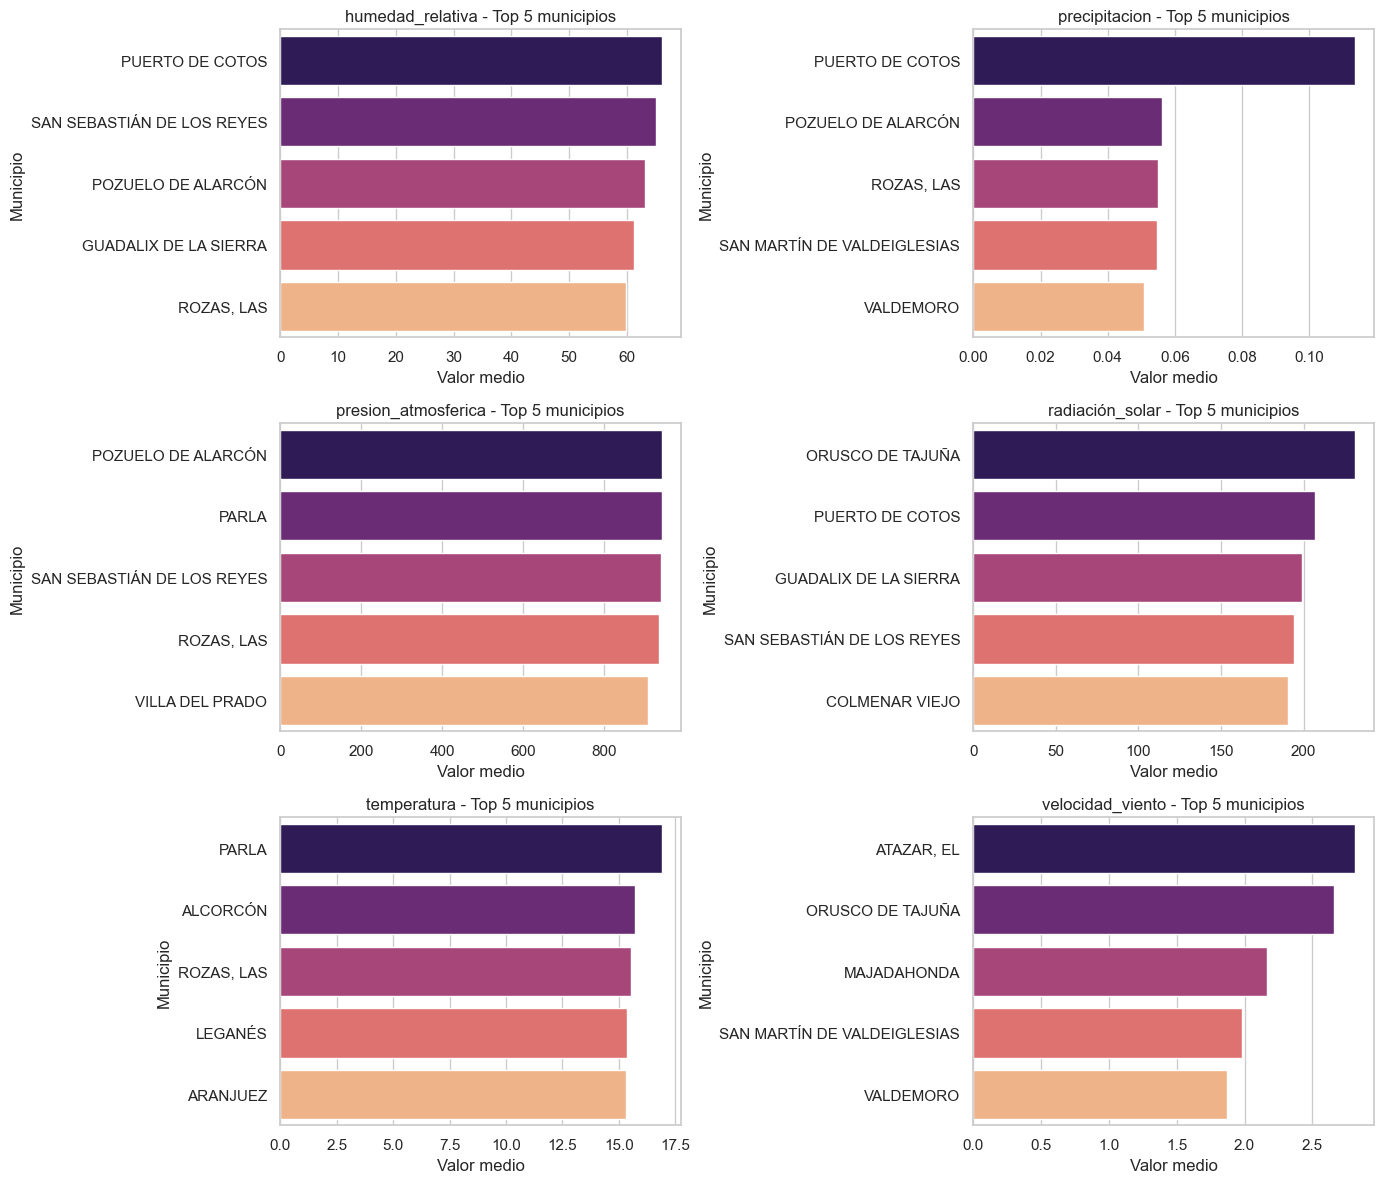

In [153]:
df_meteo_filtrado = df_meteo_municipio[~df_meteo_municipio.index.str.lower().str.contains("cluster|contaminacion")]

variables_meteo = df_meteo_filtrado.columns
n = len(variables_meteo)

n_cols = 2
n_rows = (n + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables_meteo):
    top_munis = df_meteo_filtrado[[col]].sort_values(by=col, ascending=False).head(5)
    sns.barplot(x=top_munis[col], y=top_munis.index, ax=axes[i], palette="magma")
    axes[i].set_title(f"{col} - Top 5 municipios")
    axes[i].set_xlabel("Valor medio")
    axes[i].set_ylabel("Municipio")

plt.tight_layout()
plt.show()

El mayor promedio de humedad y precipitación coinciden en el Puerto de Cotos, Pozuelo de Alarcón, Guadalix de la Sierra o Las Rozas. Este ayuda a mejores niveles de ICA, por lo que responde a valores más bajos de estos lugares. Estos son municipios del norte de Madrid, Cotos y Guadalix en la sierra, lo cual valida esa humedad y precipitacion mayor, son lugares más fríos, y los otros dos en el noroeste madrileño. Lugares entre la sierra y la capital con mucha población, pero no tan exagerado como en el sur. Son zonas más residenciales.

La radiación solar se observa que es mayor en los municipios con mayor altitud sobre el nivel del mar y todos situados al norte de la comunidad madrileña. La temperatura es mayor en zonas metropolitanas de Madrid situadas al sur, cerca del centro y muy pobladas (menos Las Rozas). Lugares como El Atazar y Orusco ven como al tener más viento coincide con valores más bajos del ICA


In [154]:
df_meteo_municipio = df_ica.groupby('municipio')[['humedad_relativa', 'precipitacion',
       'presion_atmosferica', 'radiación_solar', 'temperatura',
       'velocidad_viento']].mean()

for col in df_meteo_municipio.columns:
    print(f"\nMunicipios con menor concentración media de {col}:")
    display(df_meteo_municipio[[col]].sort_values(by=col, ascending=True).head(5))


Municipios con menor concentración media de humedad_relativa:


humedad_relativa
municipio                    
FUENLABRADA         48.971082
LEGANÉS             50.725838
ALCORCÓN            50.814274
ALCOBENDAS          50.867407
COSLADA             51.705286


Municipios con menor concentración media de precipitacion:


precipitacion
municipio                       
ALCORCÓN                0.025064
ALGETE                  0.027741
TORREJÓN DE ARDOZ       0.029419
ARGANDA DEL REY         0.029525
LEGANÉS                 0.031034


Municipios con menor concentración media de presion_atmosferica:


presion_atmosferica
municipio                                 
PUERTO DE COTOS                 766.207582
ATAZAR, EL                      849.507900
COLMENAR VIEJO                  860.947667
COLLADO VILLALBA                866.337259
GUADALIX DE LA SIERRA           867.612137


Municipios con menor concentración media de radiación_solar:


radiación_solar
municipio                          
POZUELO DE ALARCÓN       135.179042
ATAZAR, EL               166.352232
COSLADA                  167.517450
LEGANÉS                  168.271760
ALCALÁ DE HENARES        170.844274


Municipios con menor concentración media de temperatura:


temperatura
municipio                         
PUERTO DE COTOS           7.299698
ATAZAR, EL               11.996177
GUADALIX DE LA SIERRA    12.938478
COLLADO VILLALBA         13.036140
COLMENAR VIEJO           13.177216


Municipios con menor concentración media de velocidad_viento:


velocidad_viento
municipio                                   
POZUELO DE ALARCÓN                  0.347268
GETAFE                              0.816458
SAN SEBASTIÁN DE LOS REYES          0.868373
COSLADA                             0.924093
LEGANÉS                             0.983648

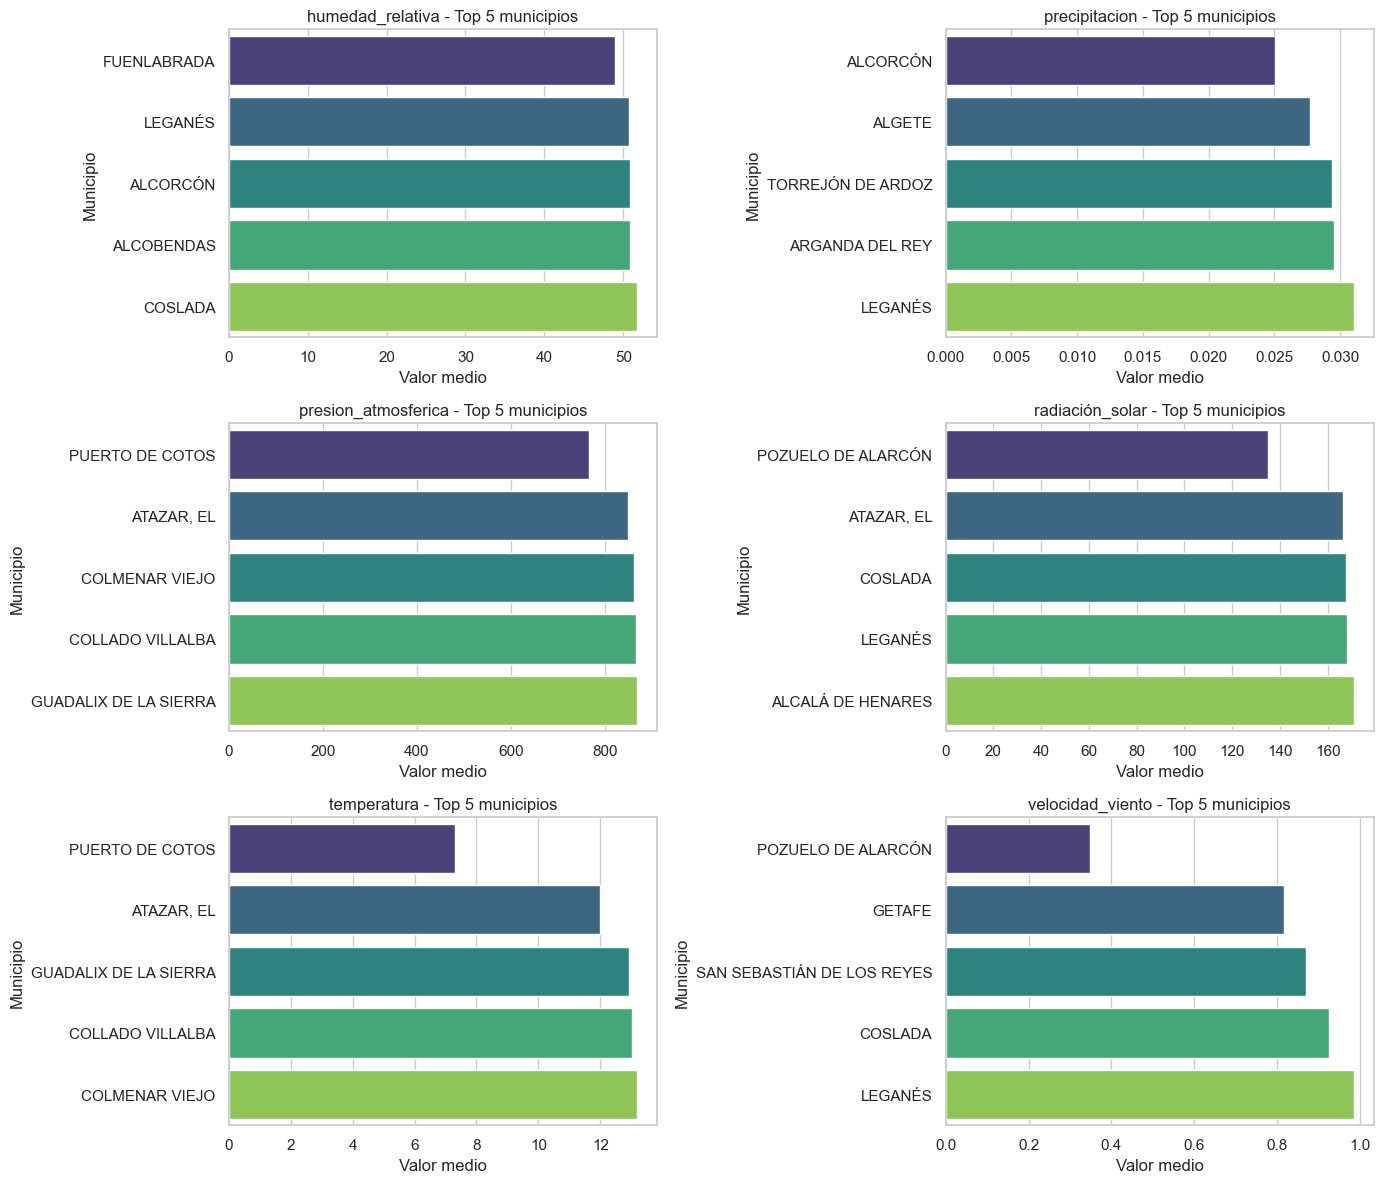

In [155]:
n_cols = 2
n_rows = (n + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables_meteo):
    top_munis = df_meteo_filtrado[[col]].sort_values(by=col, ascending=True).head(5)
    sns.barplot(x=top_munis[col], y=top_munis.index, ax=axes[i], palette="viridis")
    axes[i].set_title(f"{col} - Top 5 municipios")
    axes[i].set_xlabel("Valor medio")
    axes[i].set_ylabel("Municipio")

plt.tight_layout()
plt.show()

El menor promedio de humedad y precipitación coinciden en zonas del sur (Leganés, Alcorcón, Fuenlabrada...), zonas con más temperatura y menos precipitación. Son lugares con peores niveles de ICA. Son lugares del árera metropolitana, cercanos al centro de Madrid, con mucha población.

La radiación solar se observa que es menor en los municipios con mayor humedad y precipitación, como Pozuelo o el Atazar. La temperatura es menor en zonas NO metropolitanas de Madrid (lejos del centro), situadas al norte y no tan pobladas como en el sur.

### CONCLUSIONES ANALÍTICAS

Se presenta una tendencia estacional clara, con patrón de ICA es más alto en invierno (especialmente enero y diciembre), probablemente por condiciones de inversión térmica, baja dispersión y mayor uso de calefacción. En esta estación destaca la alta concentraciçon de óxiodos de nitrógeno (NOx) En verano también hay un repunte (causado por el aumneto del ozono a nivel de suelo), pero no al mismo nivel que en invierno. En primavera disminuye a los mínimos anuales del ICA. Los fines de semana se reduce el promedio del ICA, probablemente debido a que entre semana hay más contaminación por medios de transporte por el sector laboral y menos actividad insdustrial.

Los contaminantes más frecuentes como dominantes son PM10 y PM2.5 en meses fríos: asociados a calefacciones, tráfico y menor dispersión. También el NO2, más presente en áreas urbanas (tráfico denso) como Coslada, Getafe o Leganés. El O3 (ozono) como predomina en verano, especialmente en municipios periféricos como Rivas, Arganda o Aranjuez, y tiene un sentido inverso a los NO, de ahí su variabilidad entre verano e invierno. En invierno dominan partículas PM y el NO₂, mientras que en verano hay mayor presencia de ozono, especialmente en zonas soleadas y cálidas.

Municipios rurales y de sierra como El Atazar, Puerto de Cotos y Villa del Prado presentan sistemáticamente ICA más bajos, favorecidos por la altitud, viento más fuerte, menor densidad urbana y de tráfico. En contraposición, los municipios metropolitanos o del sur como Parla, Valdemoro, Coslada o Leganés tienen ICA más altos, en parte debido a la mayor presión atmosférica, el tráfico y actividad industrial/residencial, Condiciones meteorológicas menos favorables para dispersión (menos viento, más temperatura, etc).

Factores meteorológicos: El viento y las precipitaciones ayudan a reducir el ICA. mientras que la temperatura alta y presión elevada tienden a empeorar la calidad del aire. La radiación solar es un factor de riesgo en verano por formación de ozono, pero no es determinante en invierno. Los municipios con peor ICA suelen coincidir con valores altos en presión, temperatura y baja ventilación, mientras que los de mejor ICA destacan en viento, lluvia y menor densidad poblacional.